--- 1. 加载数据与缓存 ---
Loading cache from C:\机器学习材料\季鏻\cached_graphs_box64_cleaned.pt
--- 2. 复现数据集划分 (Train/Test) ---
Dataset 过滤情况: 原始 6753 -> 有效 6559
--- 3. 加载模型 ---
--- 4. 在测试集上进行预测 (6559 样本) ---


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [01:43<00:00,  1.99it/s]



开始绘图分析
图片将保存至: C:\Users\admin\Energymodel\2-9

正在分析目标: Binding Energy (kJ/mol Si)


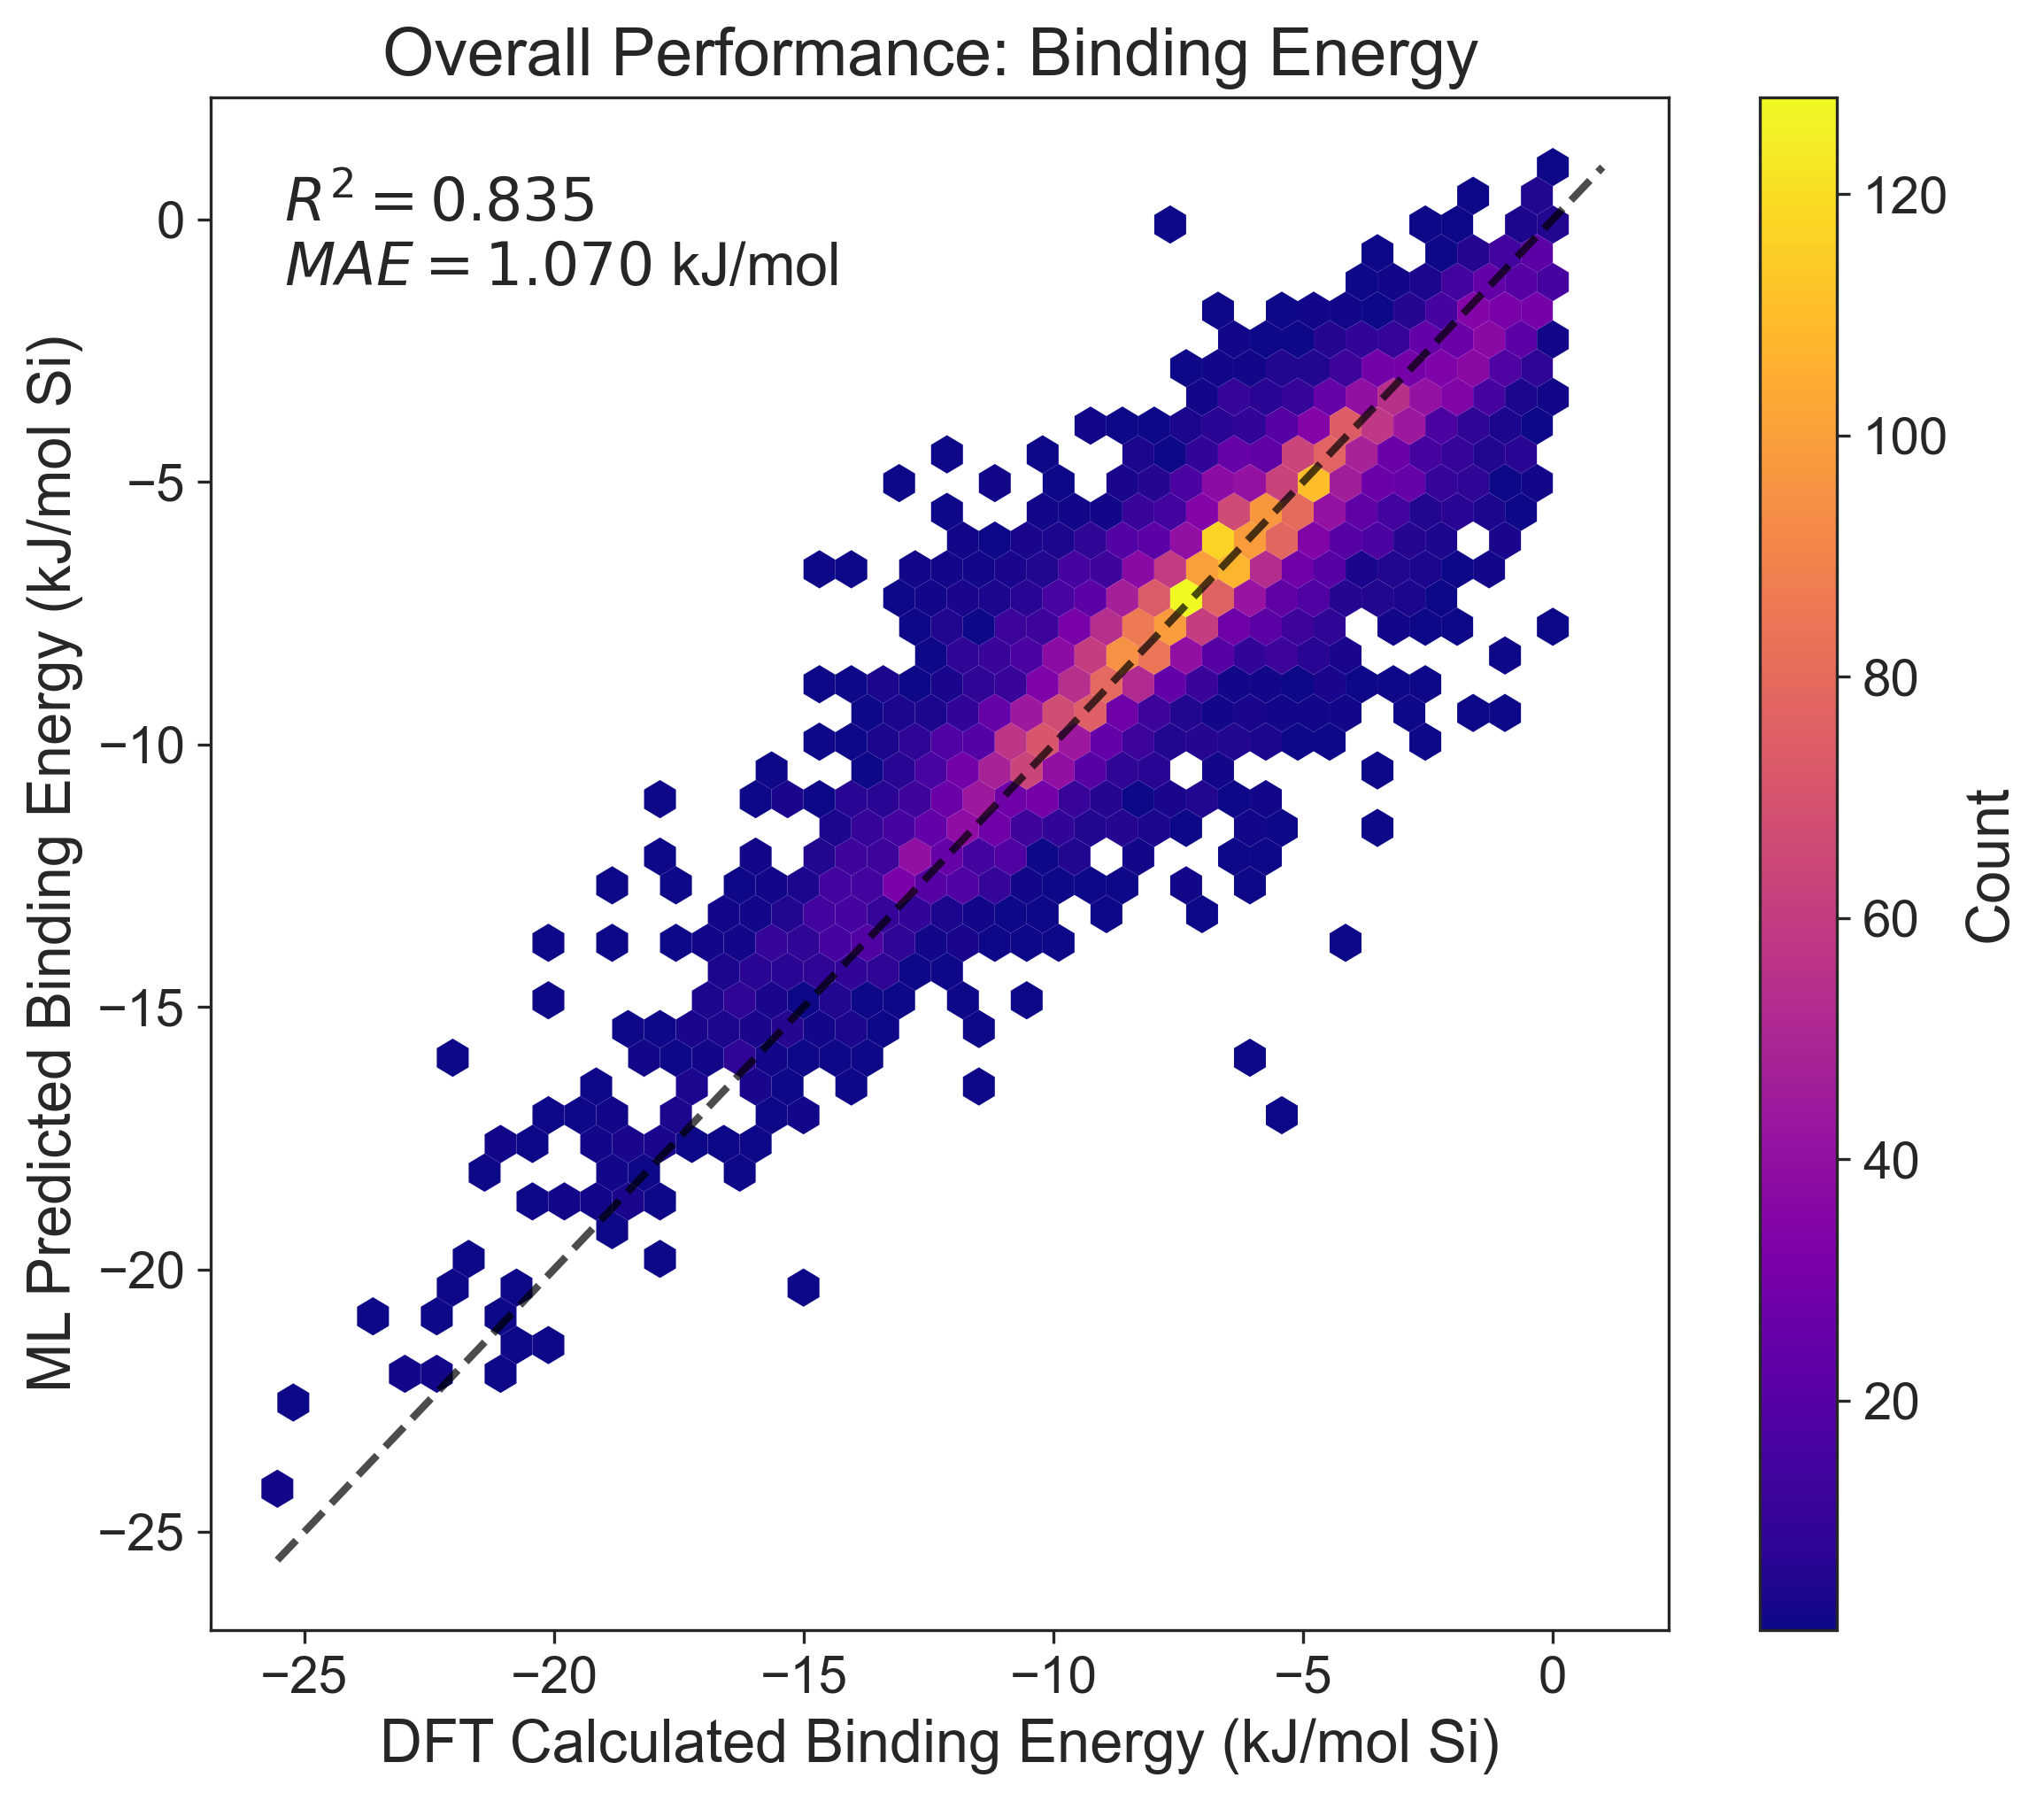

--- Topology Analysis for Binding Energy (kJ/mol Si) ---


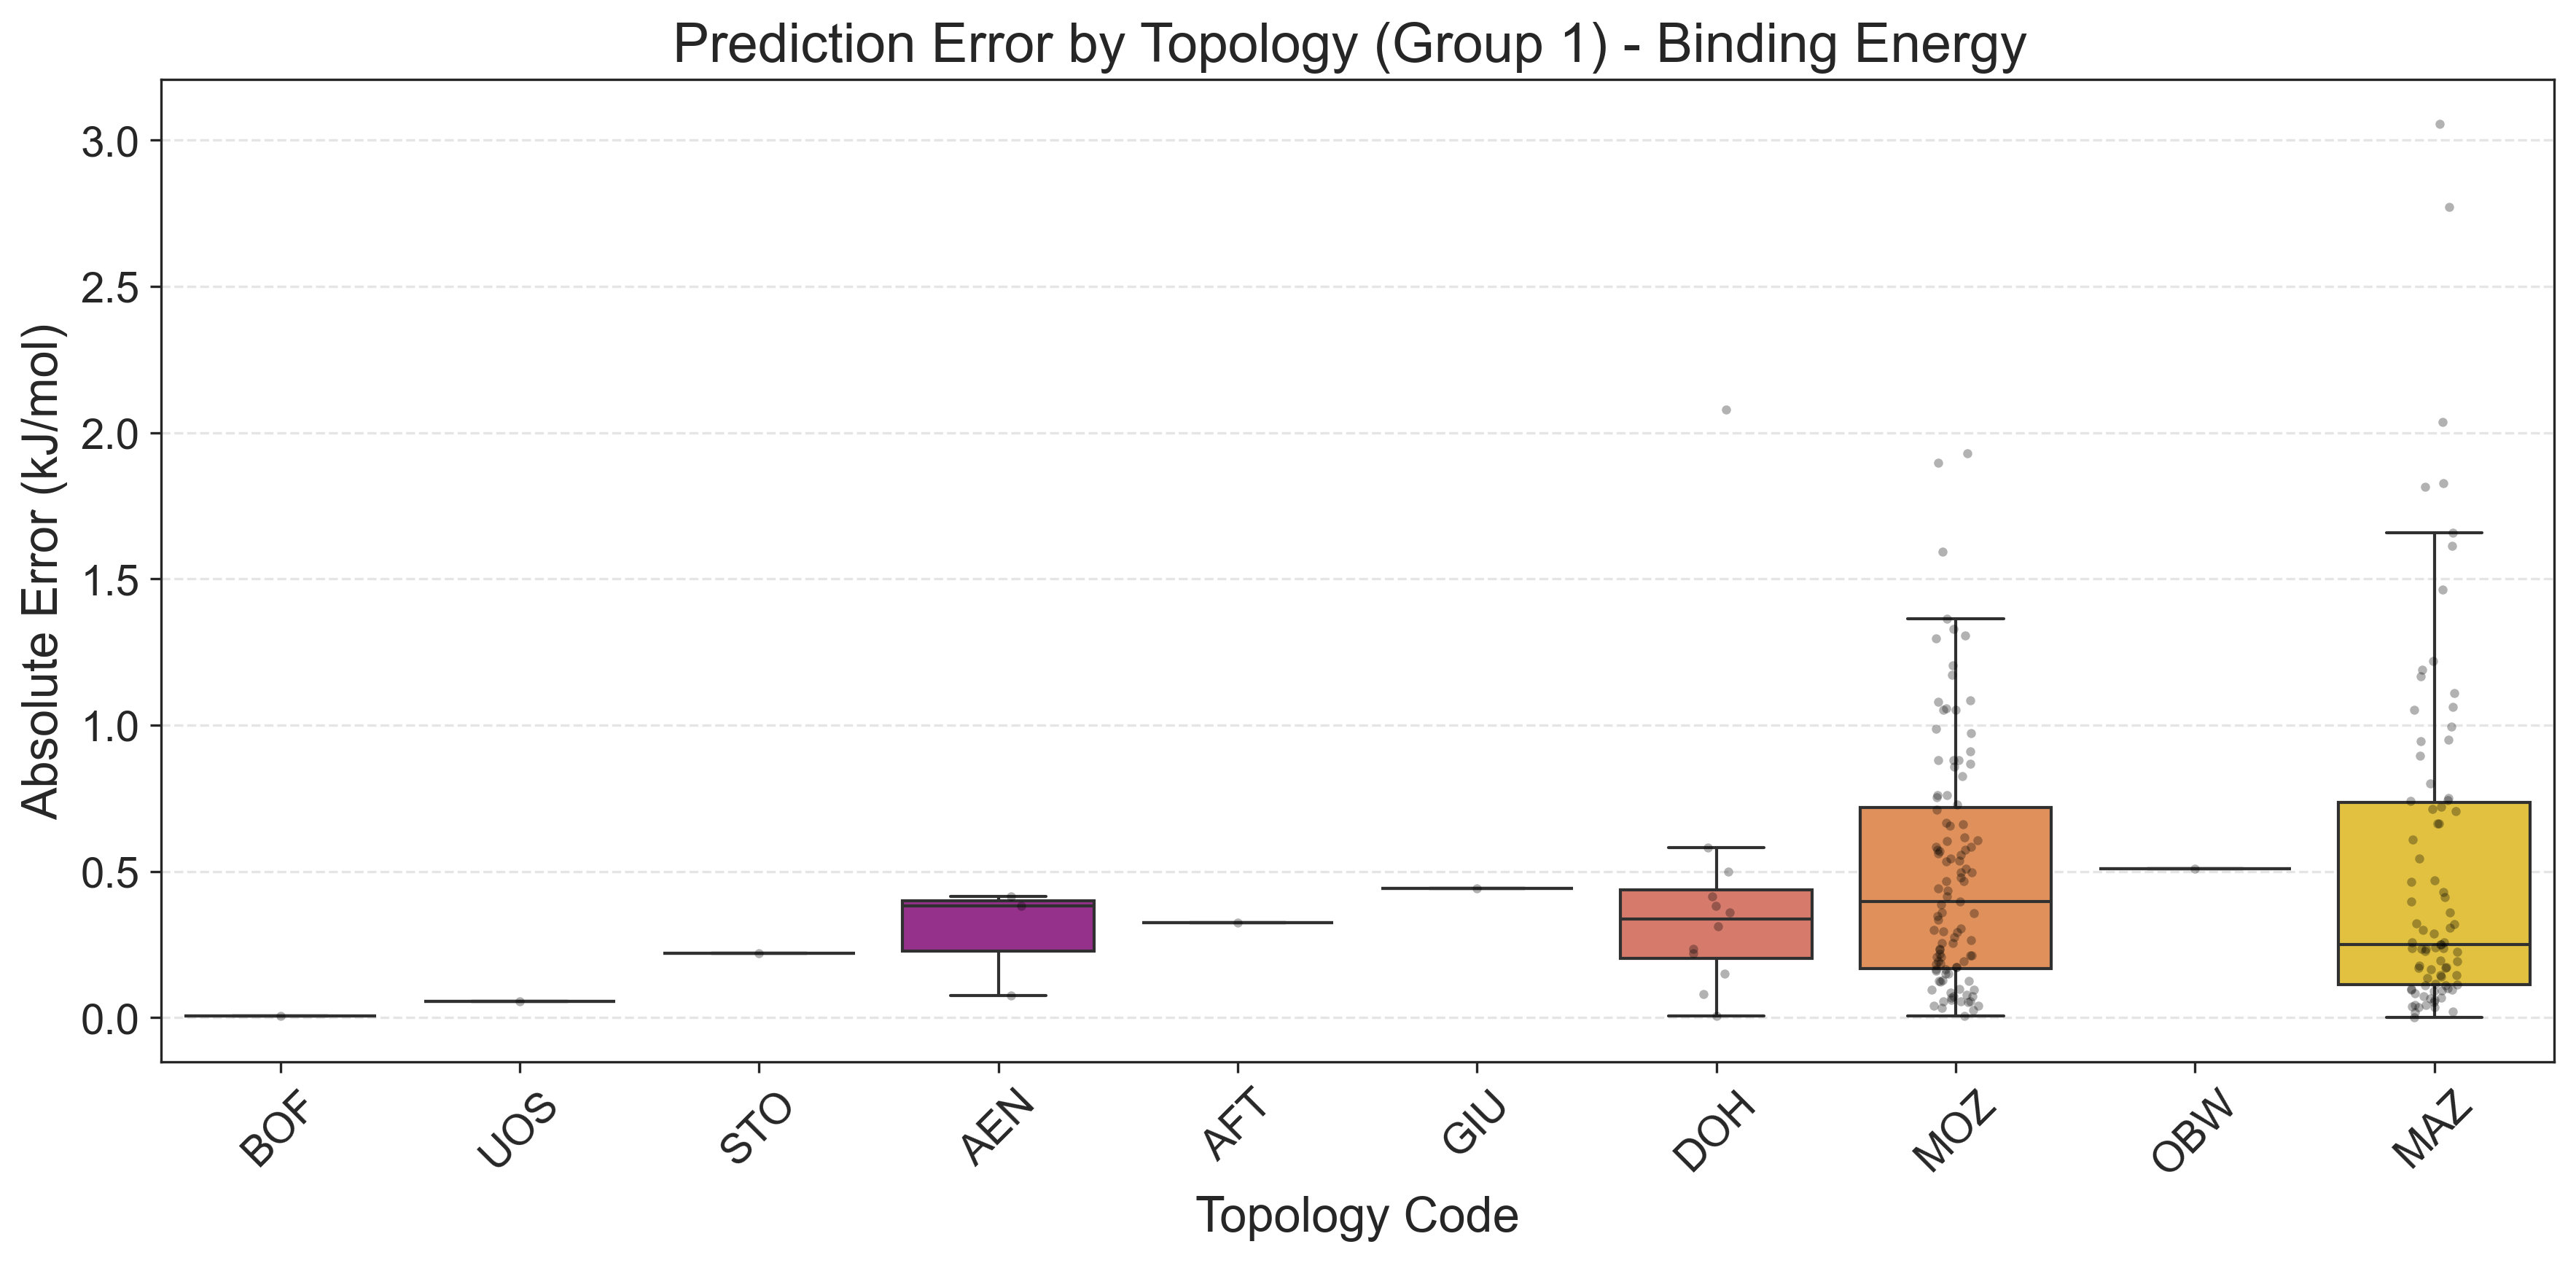

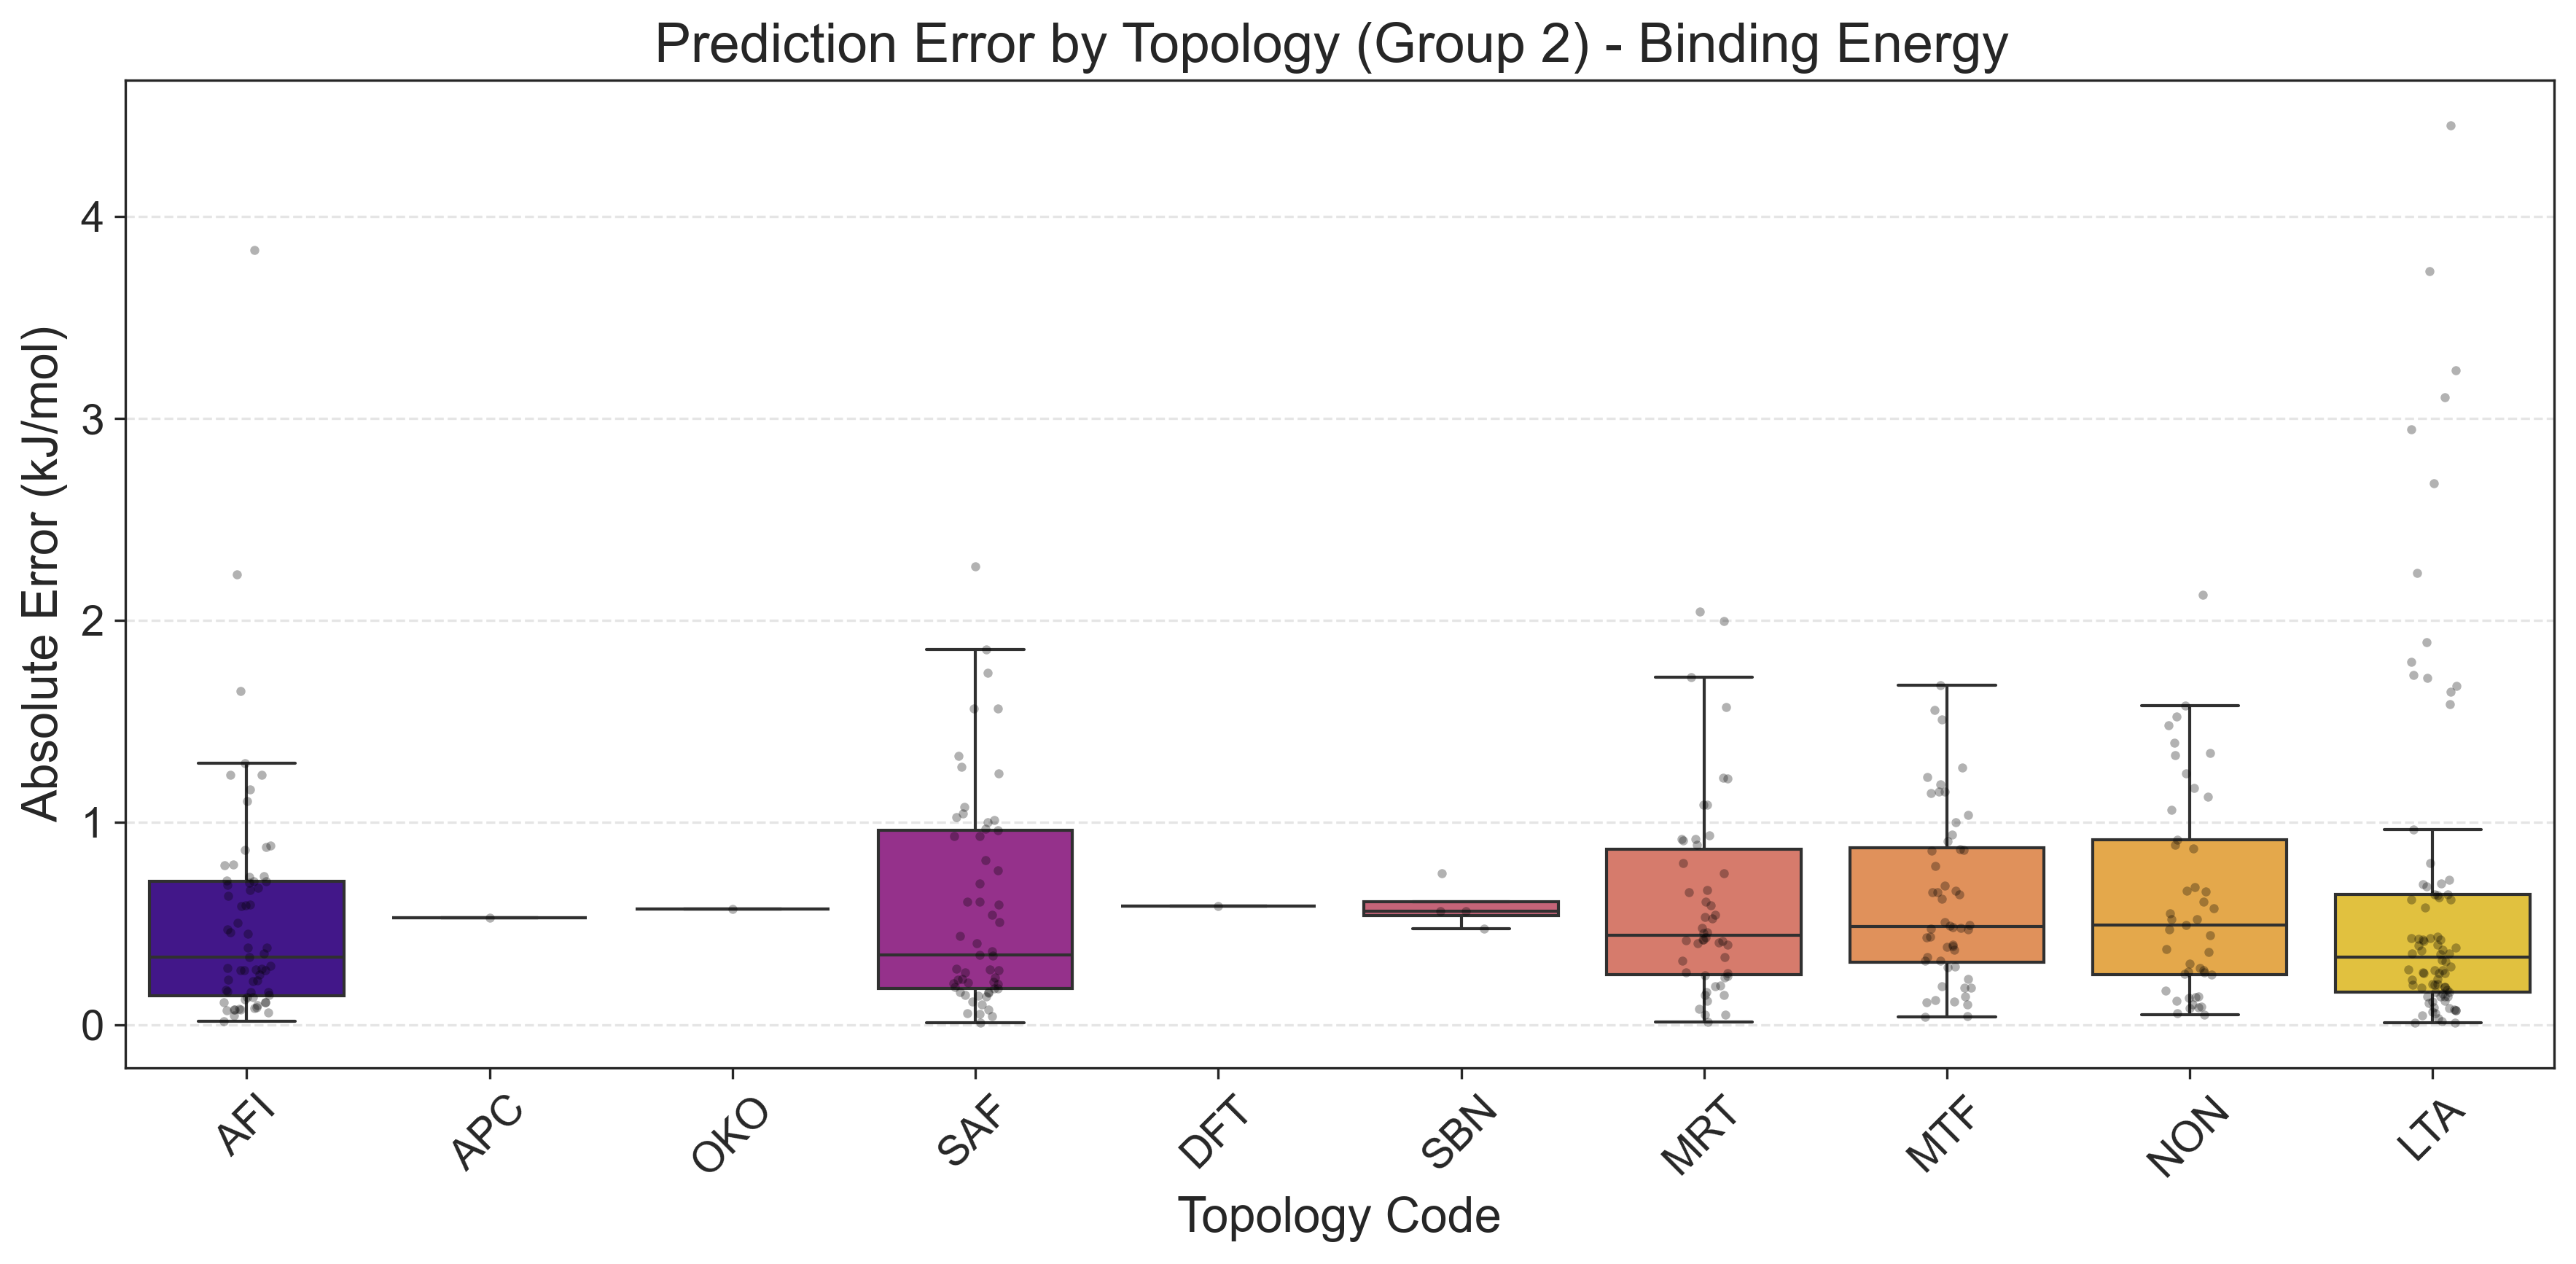

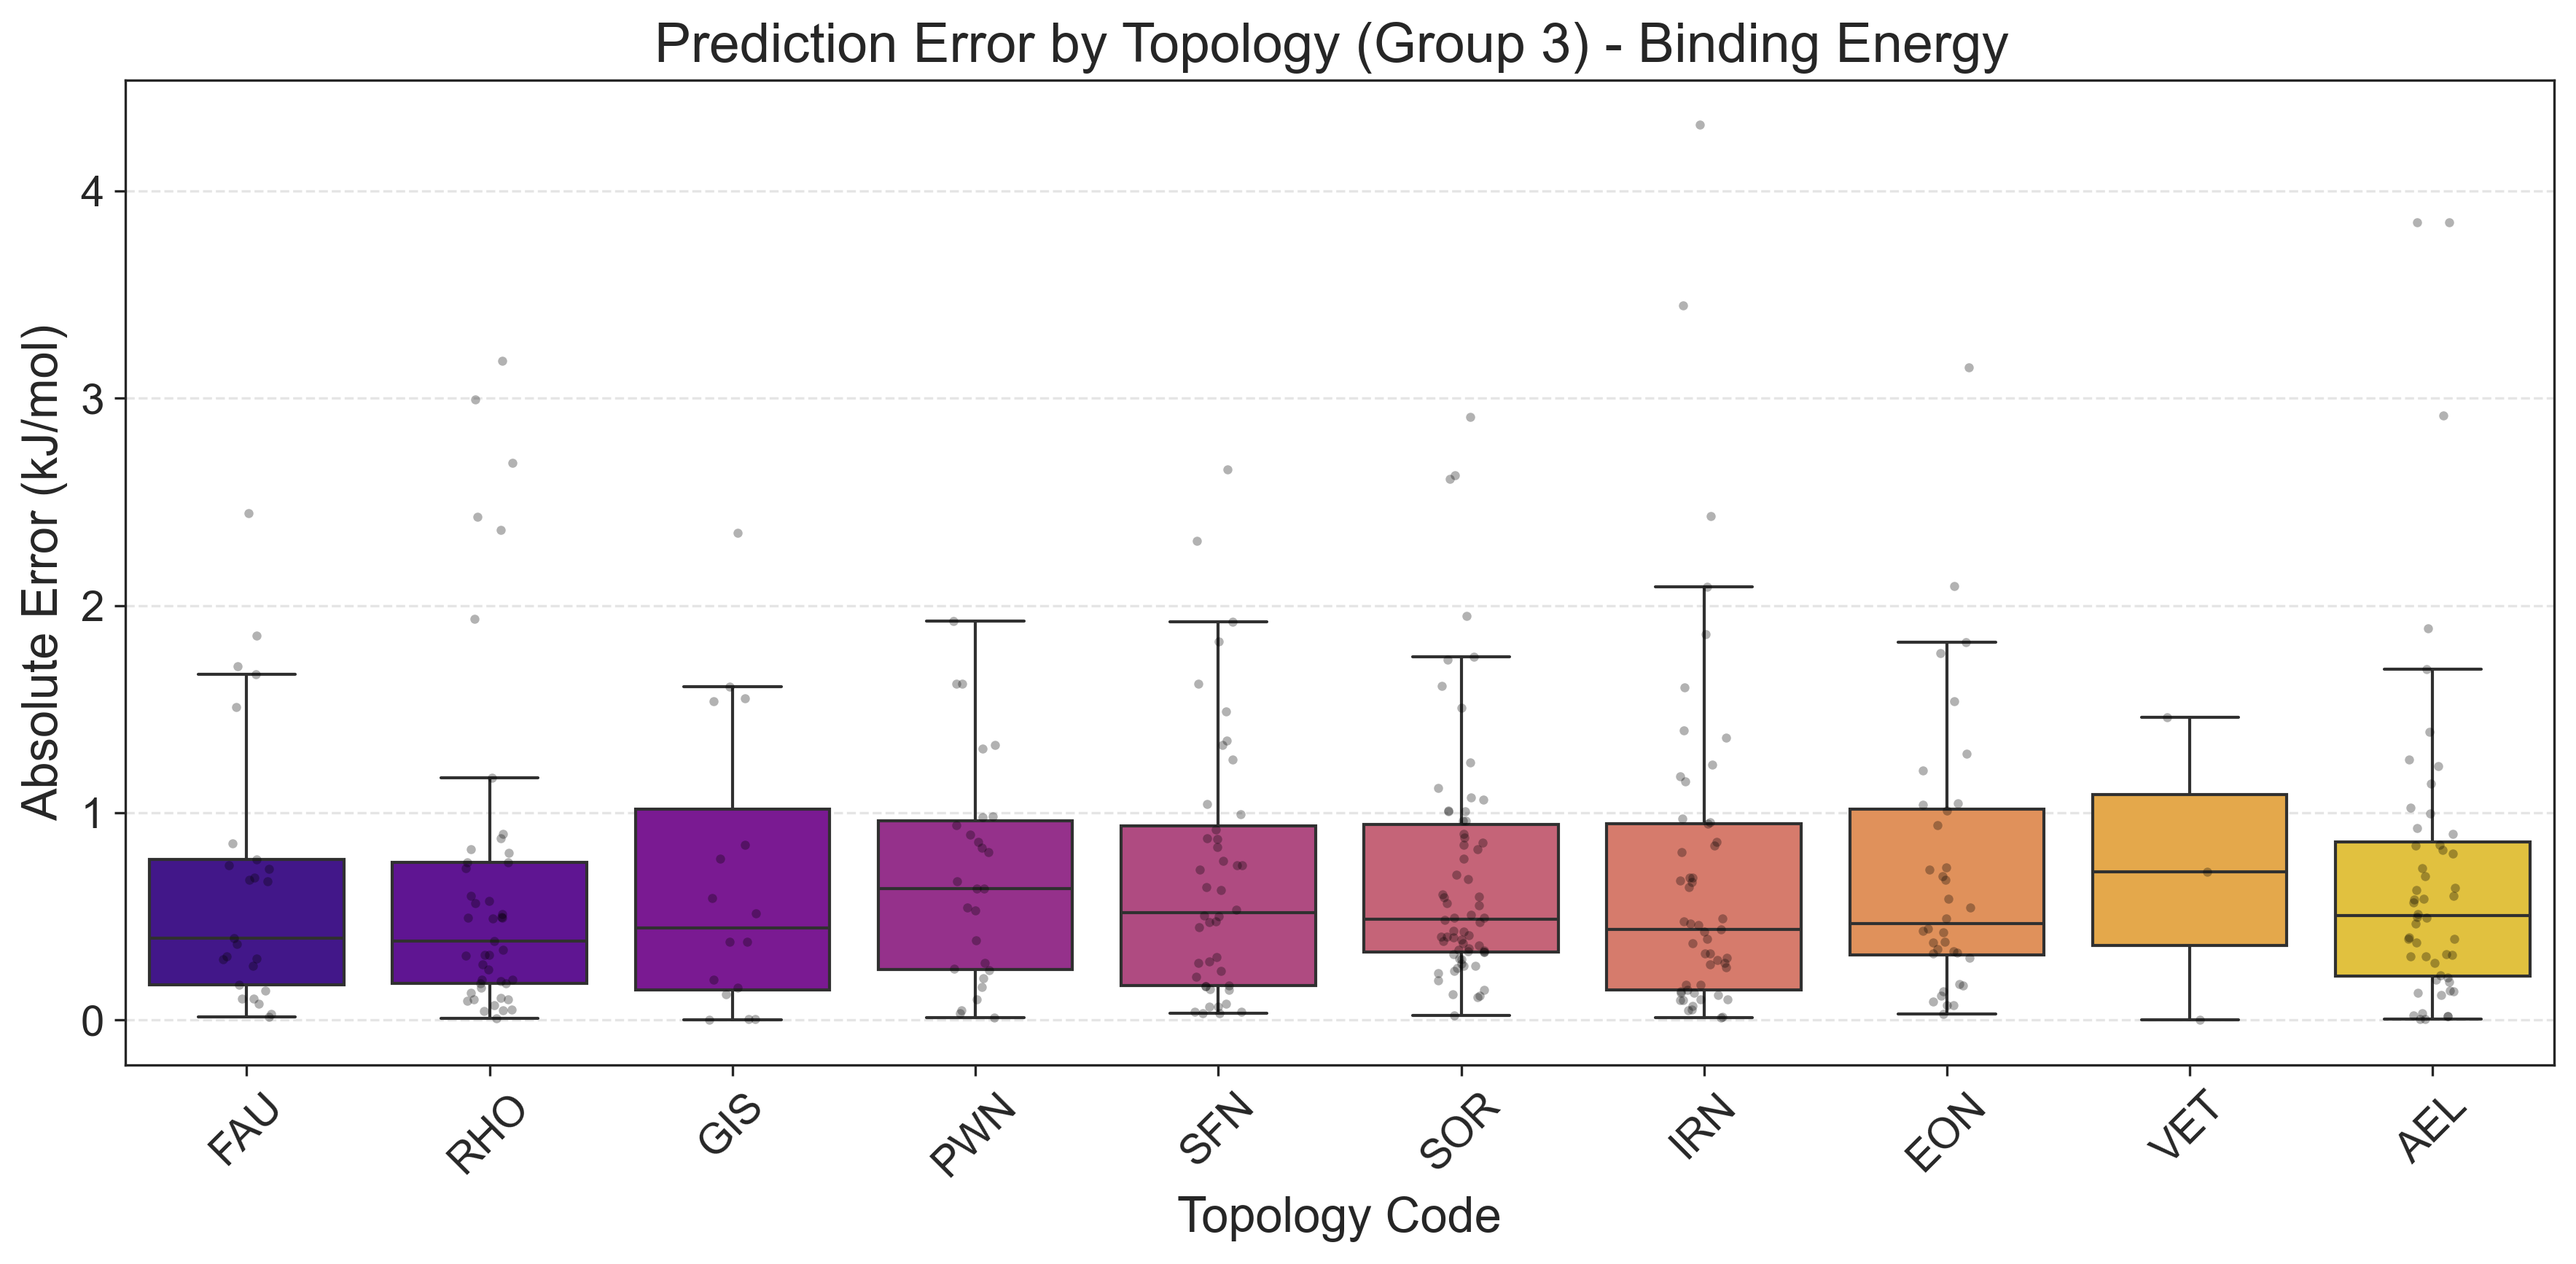

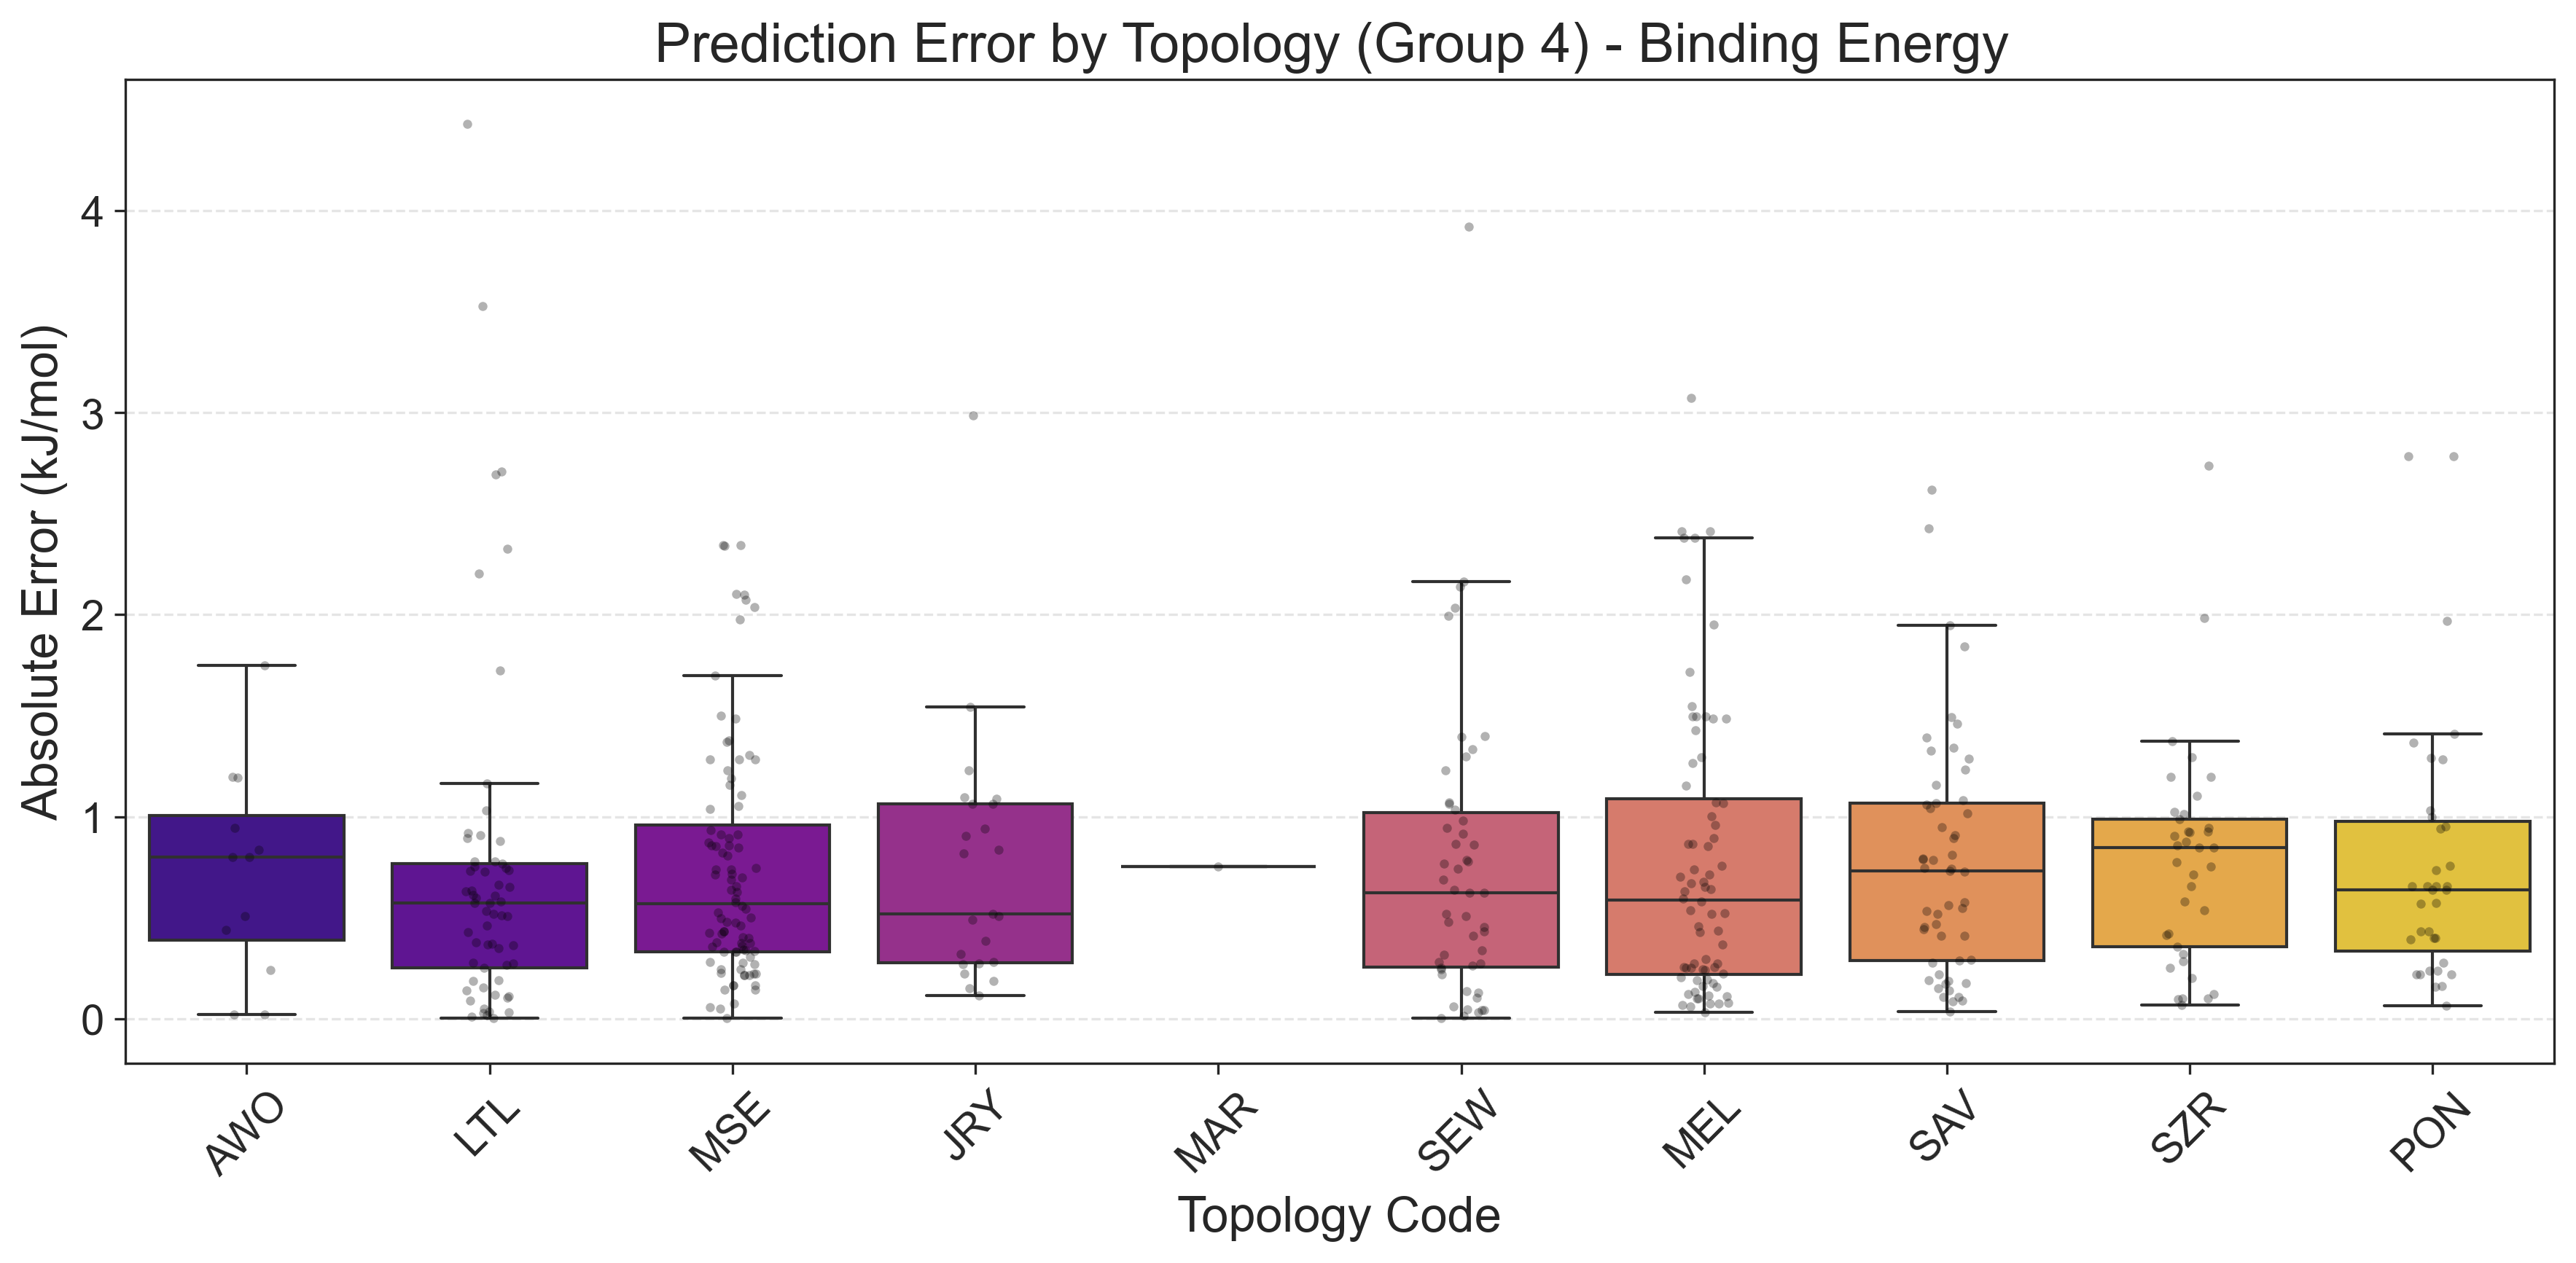

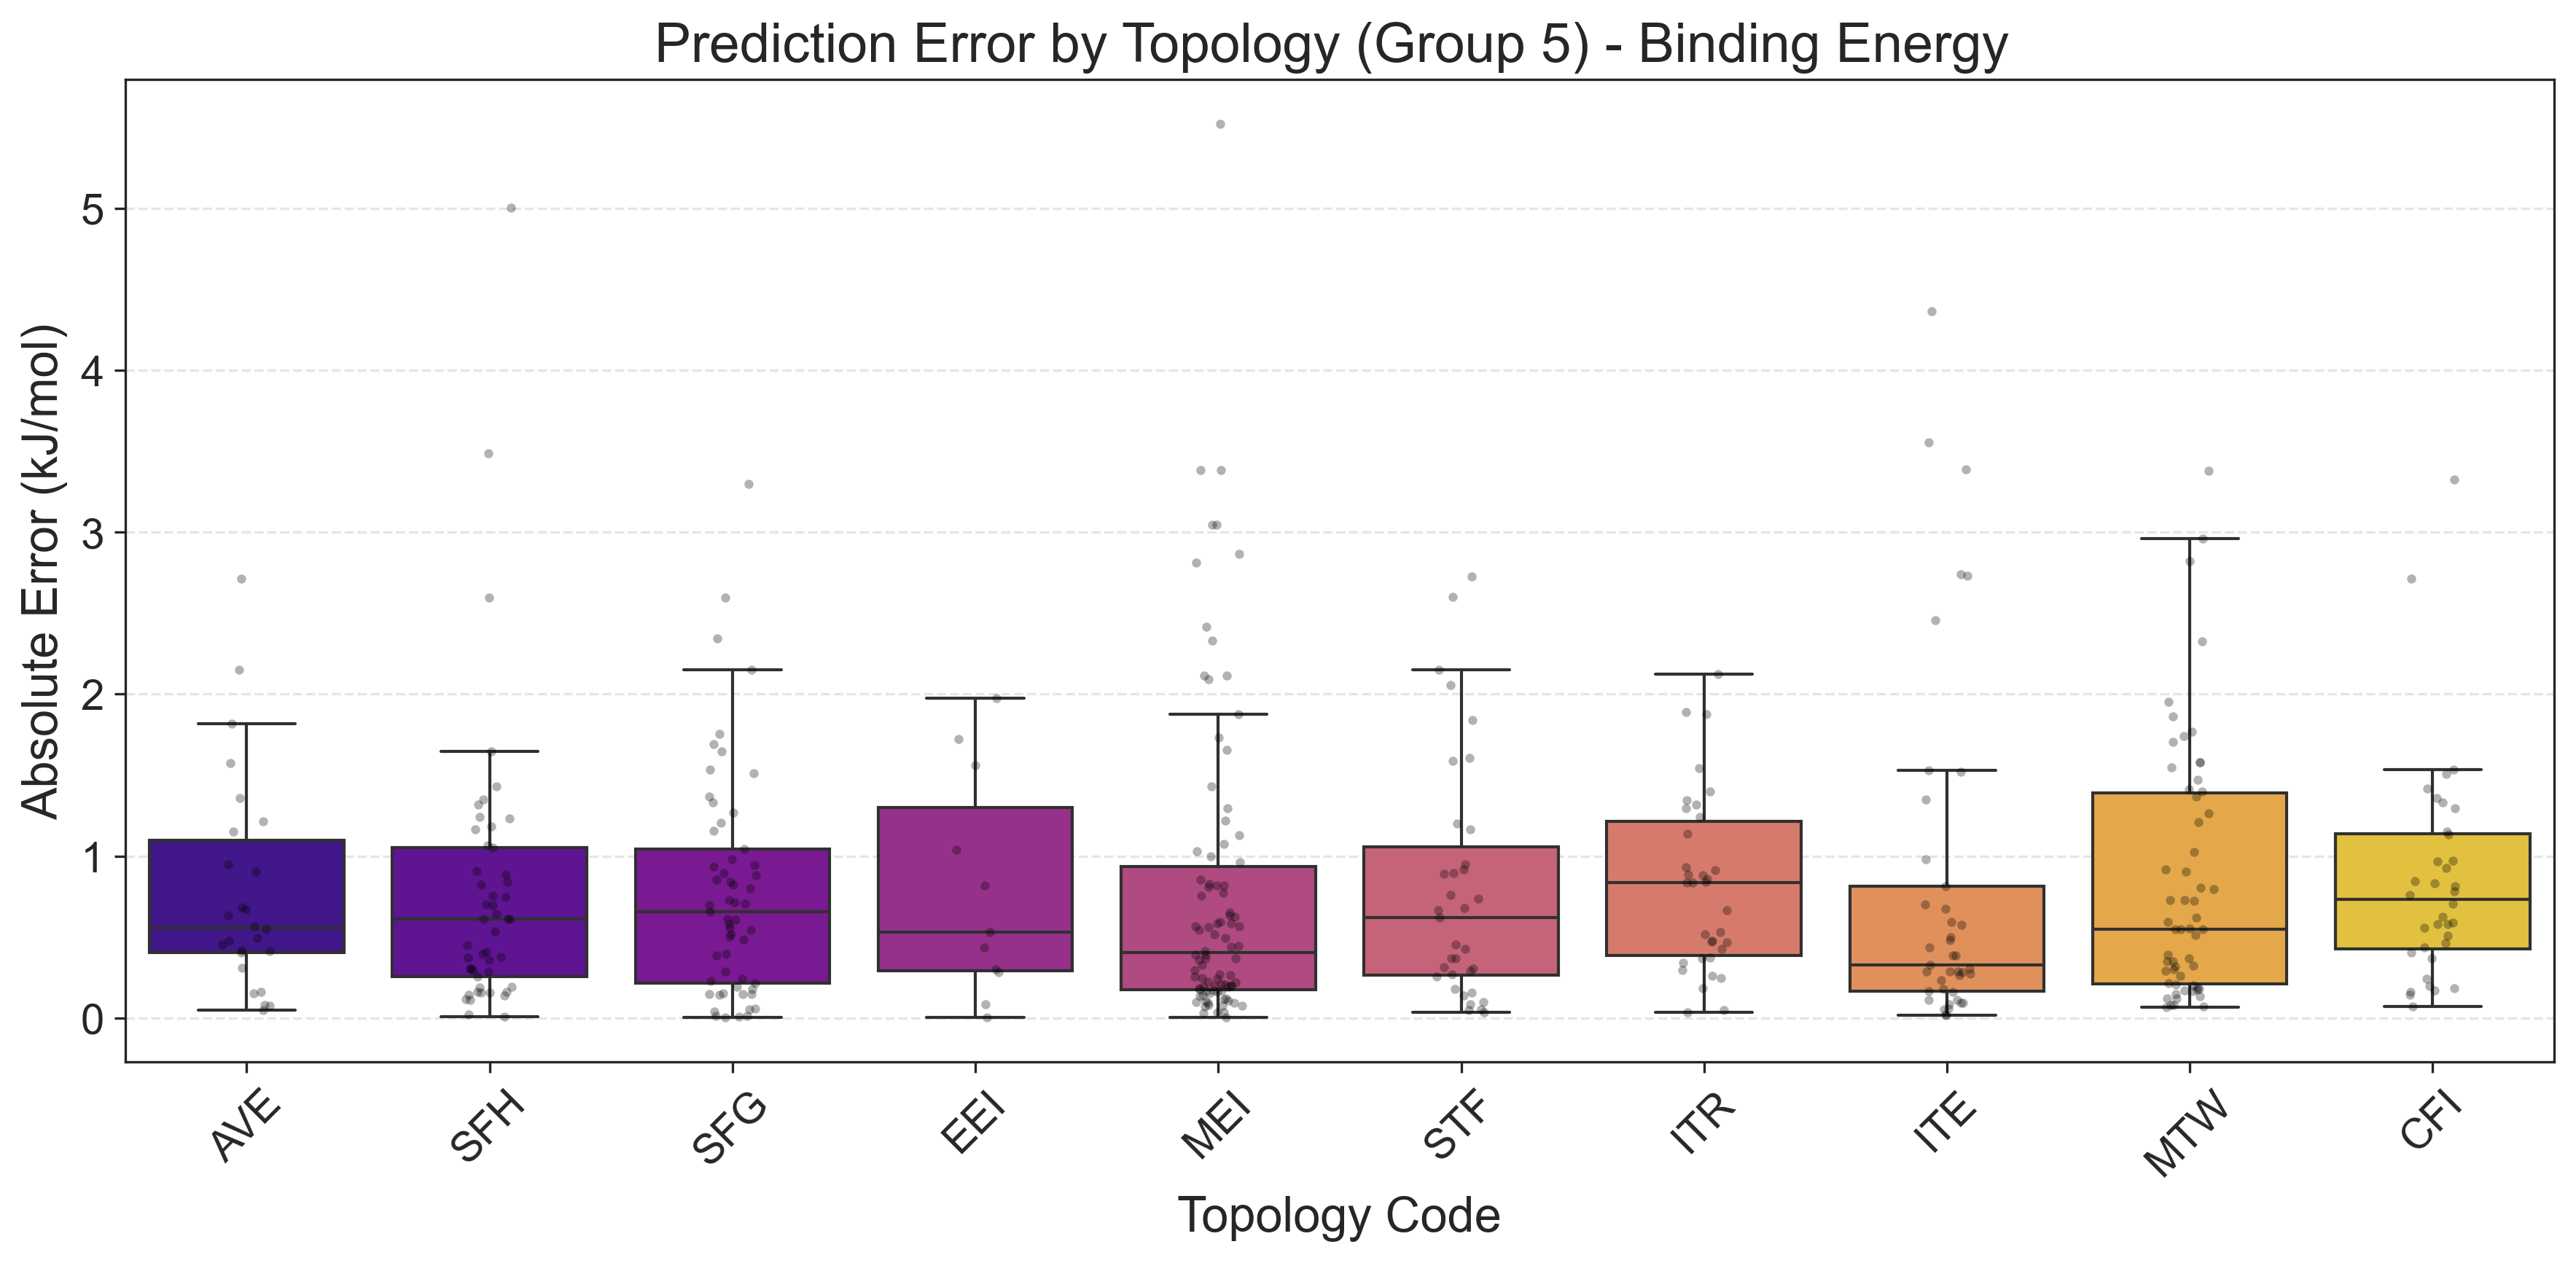

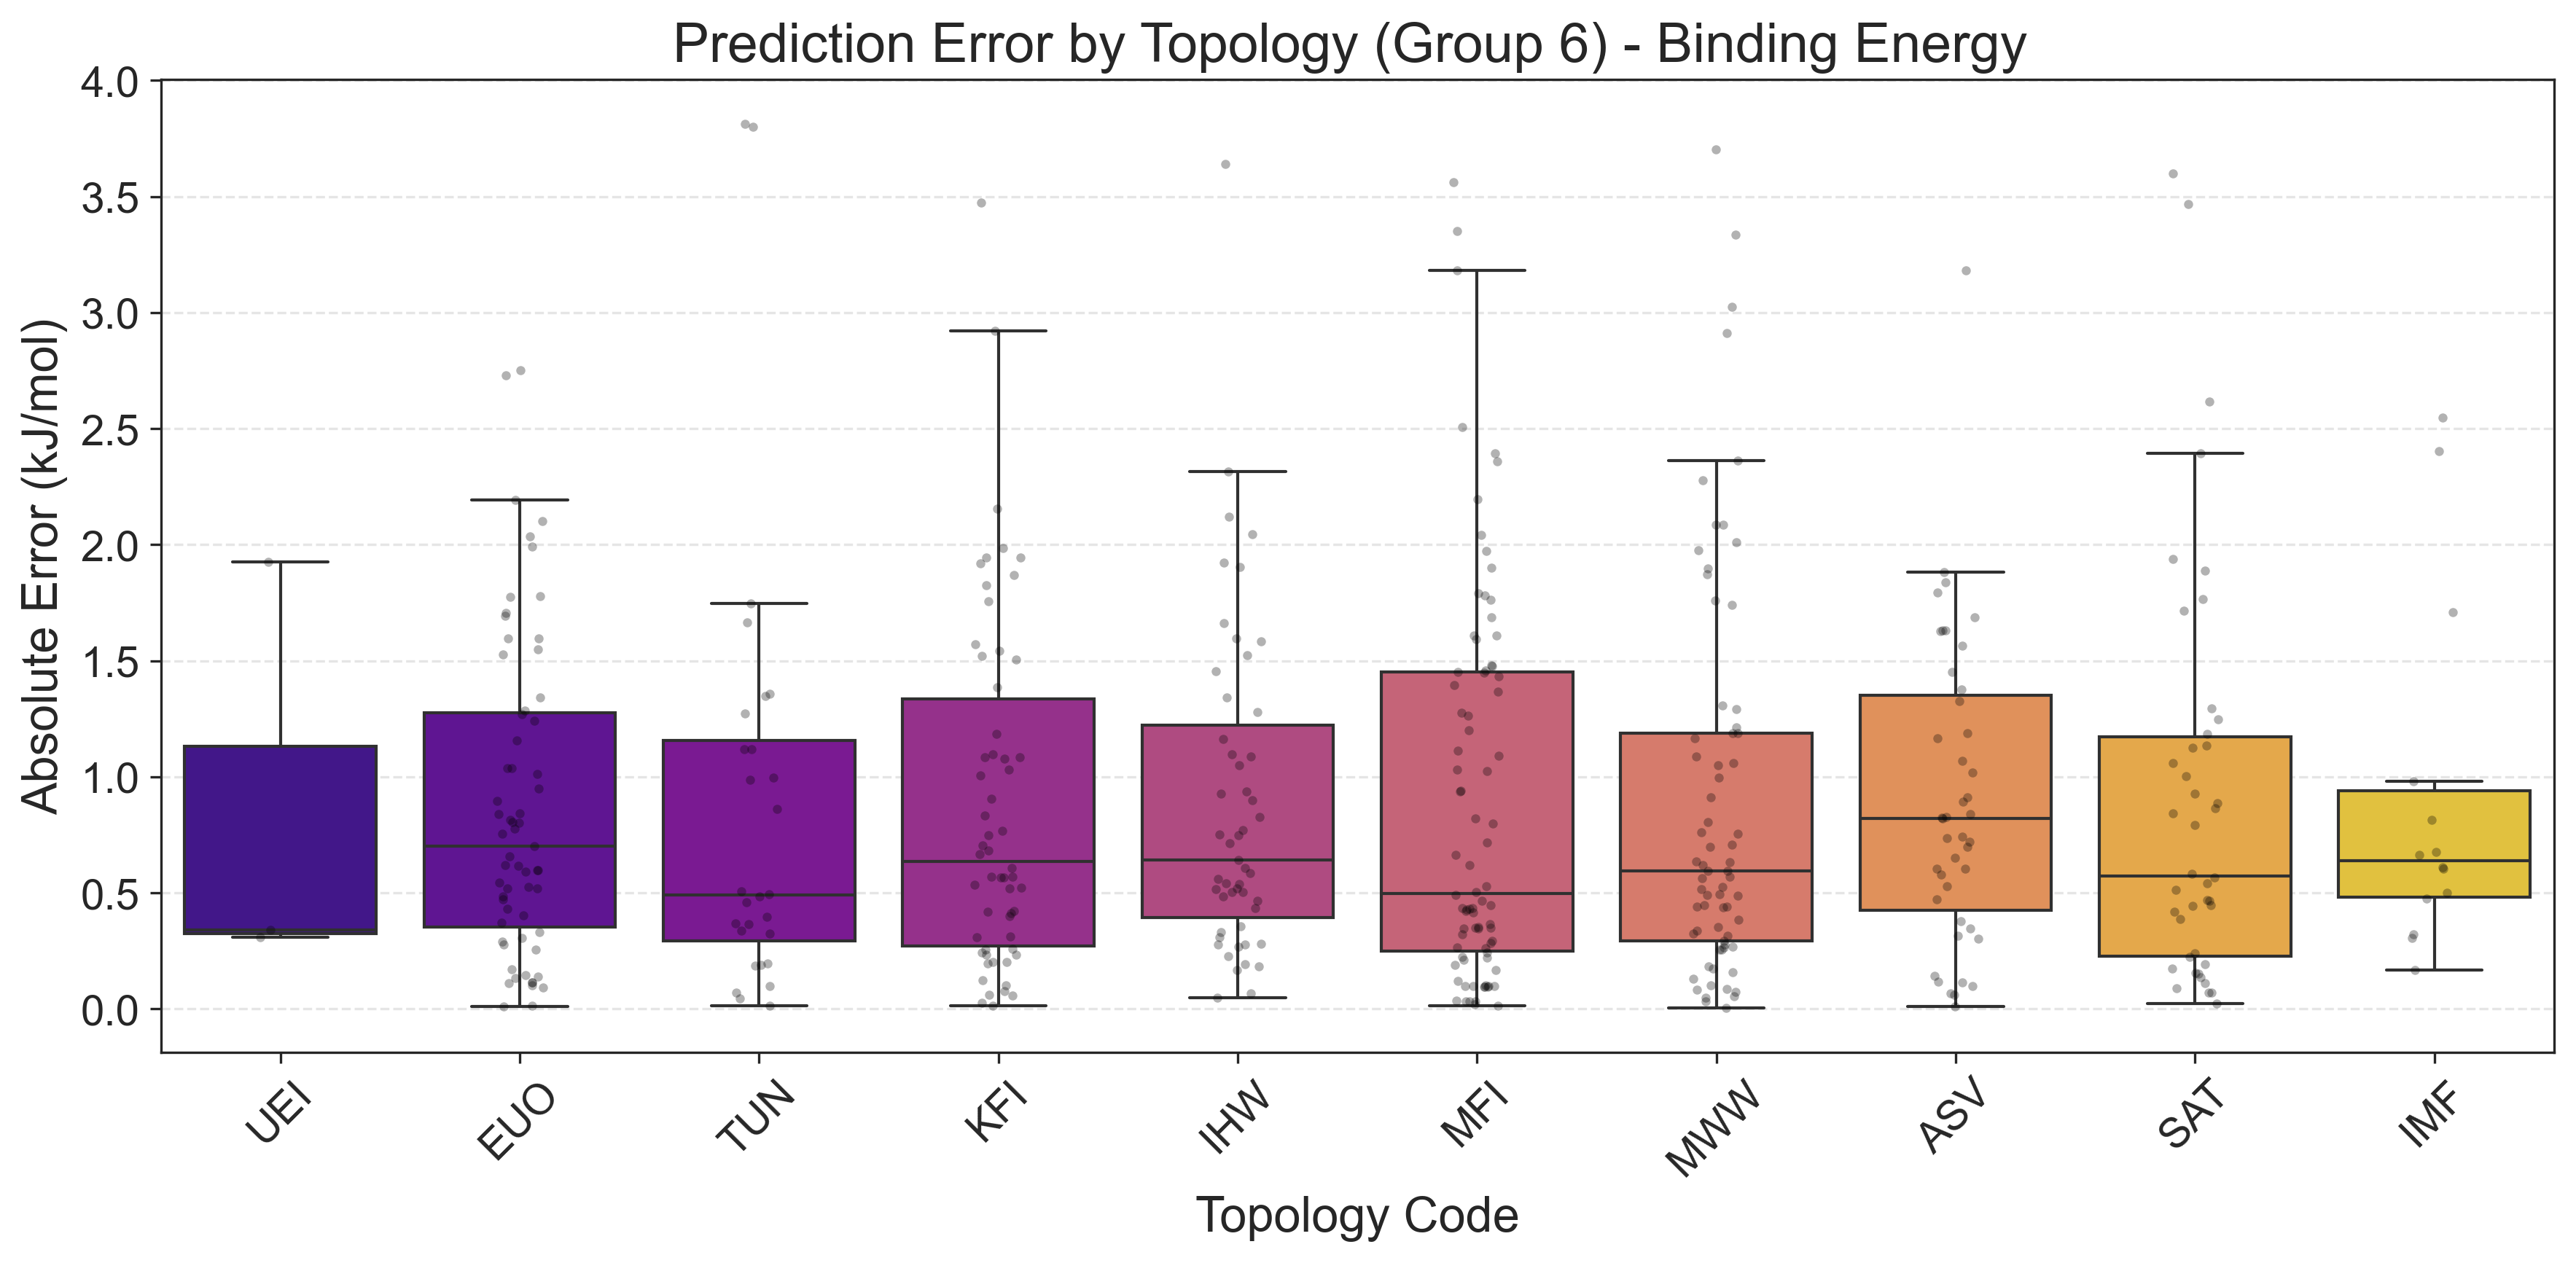

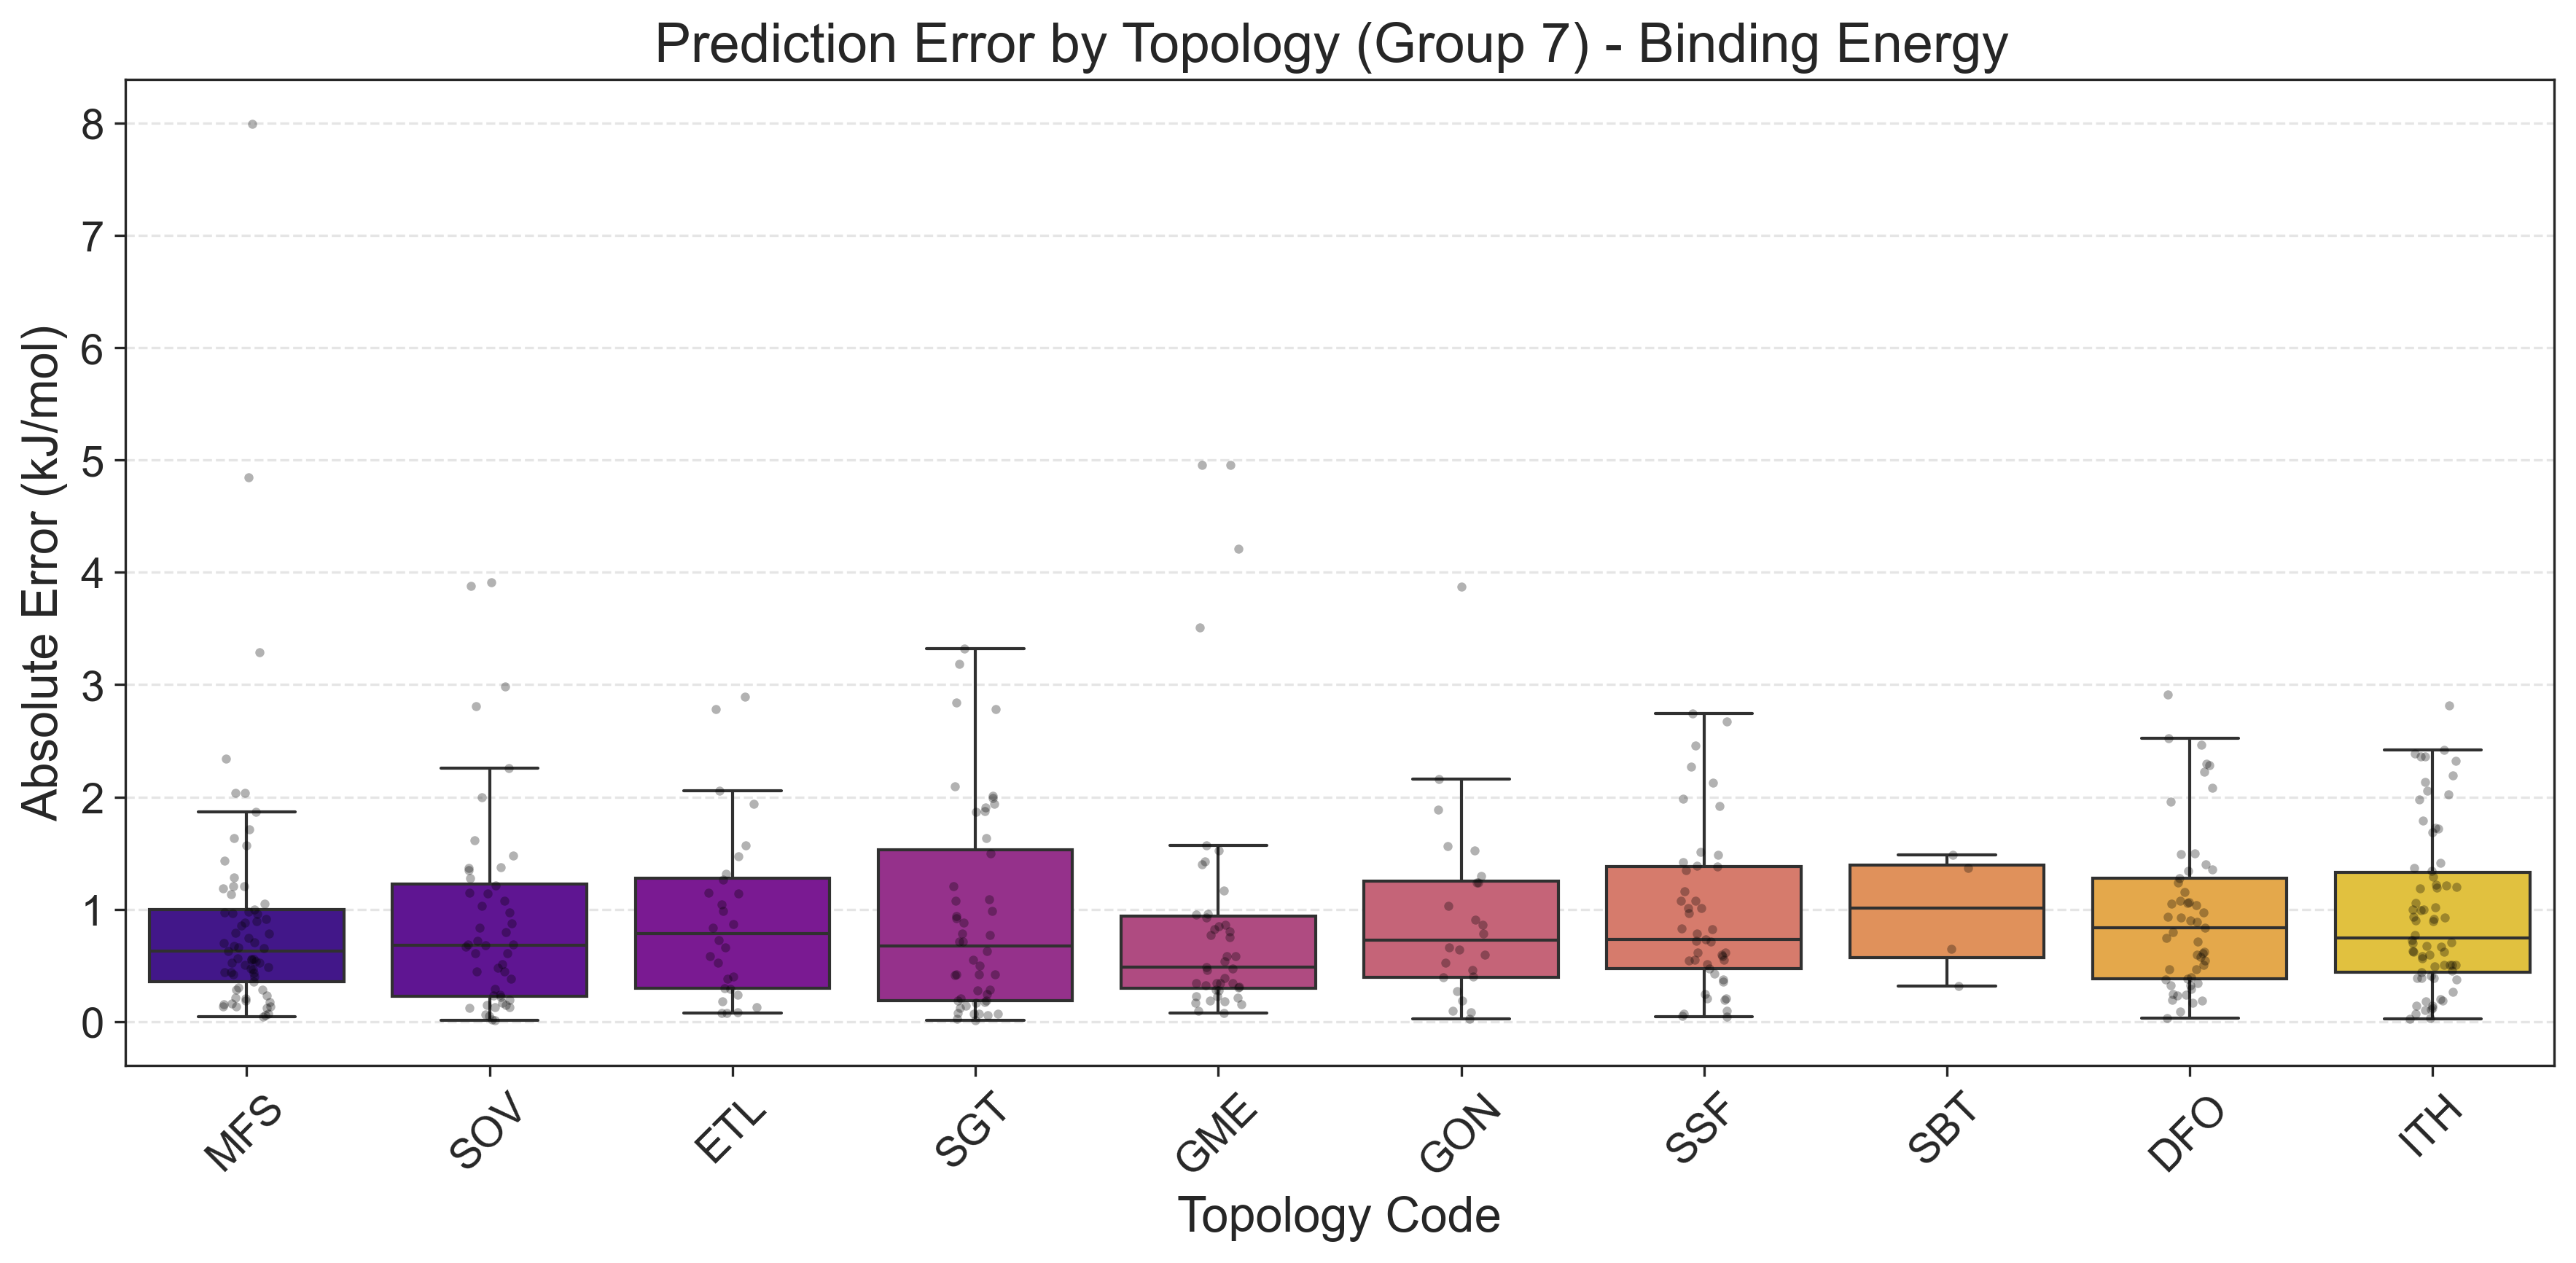

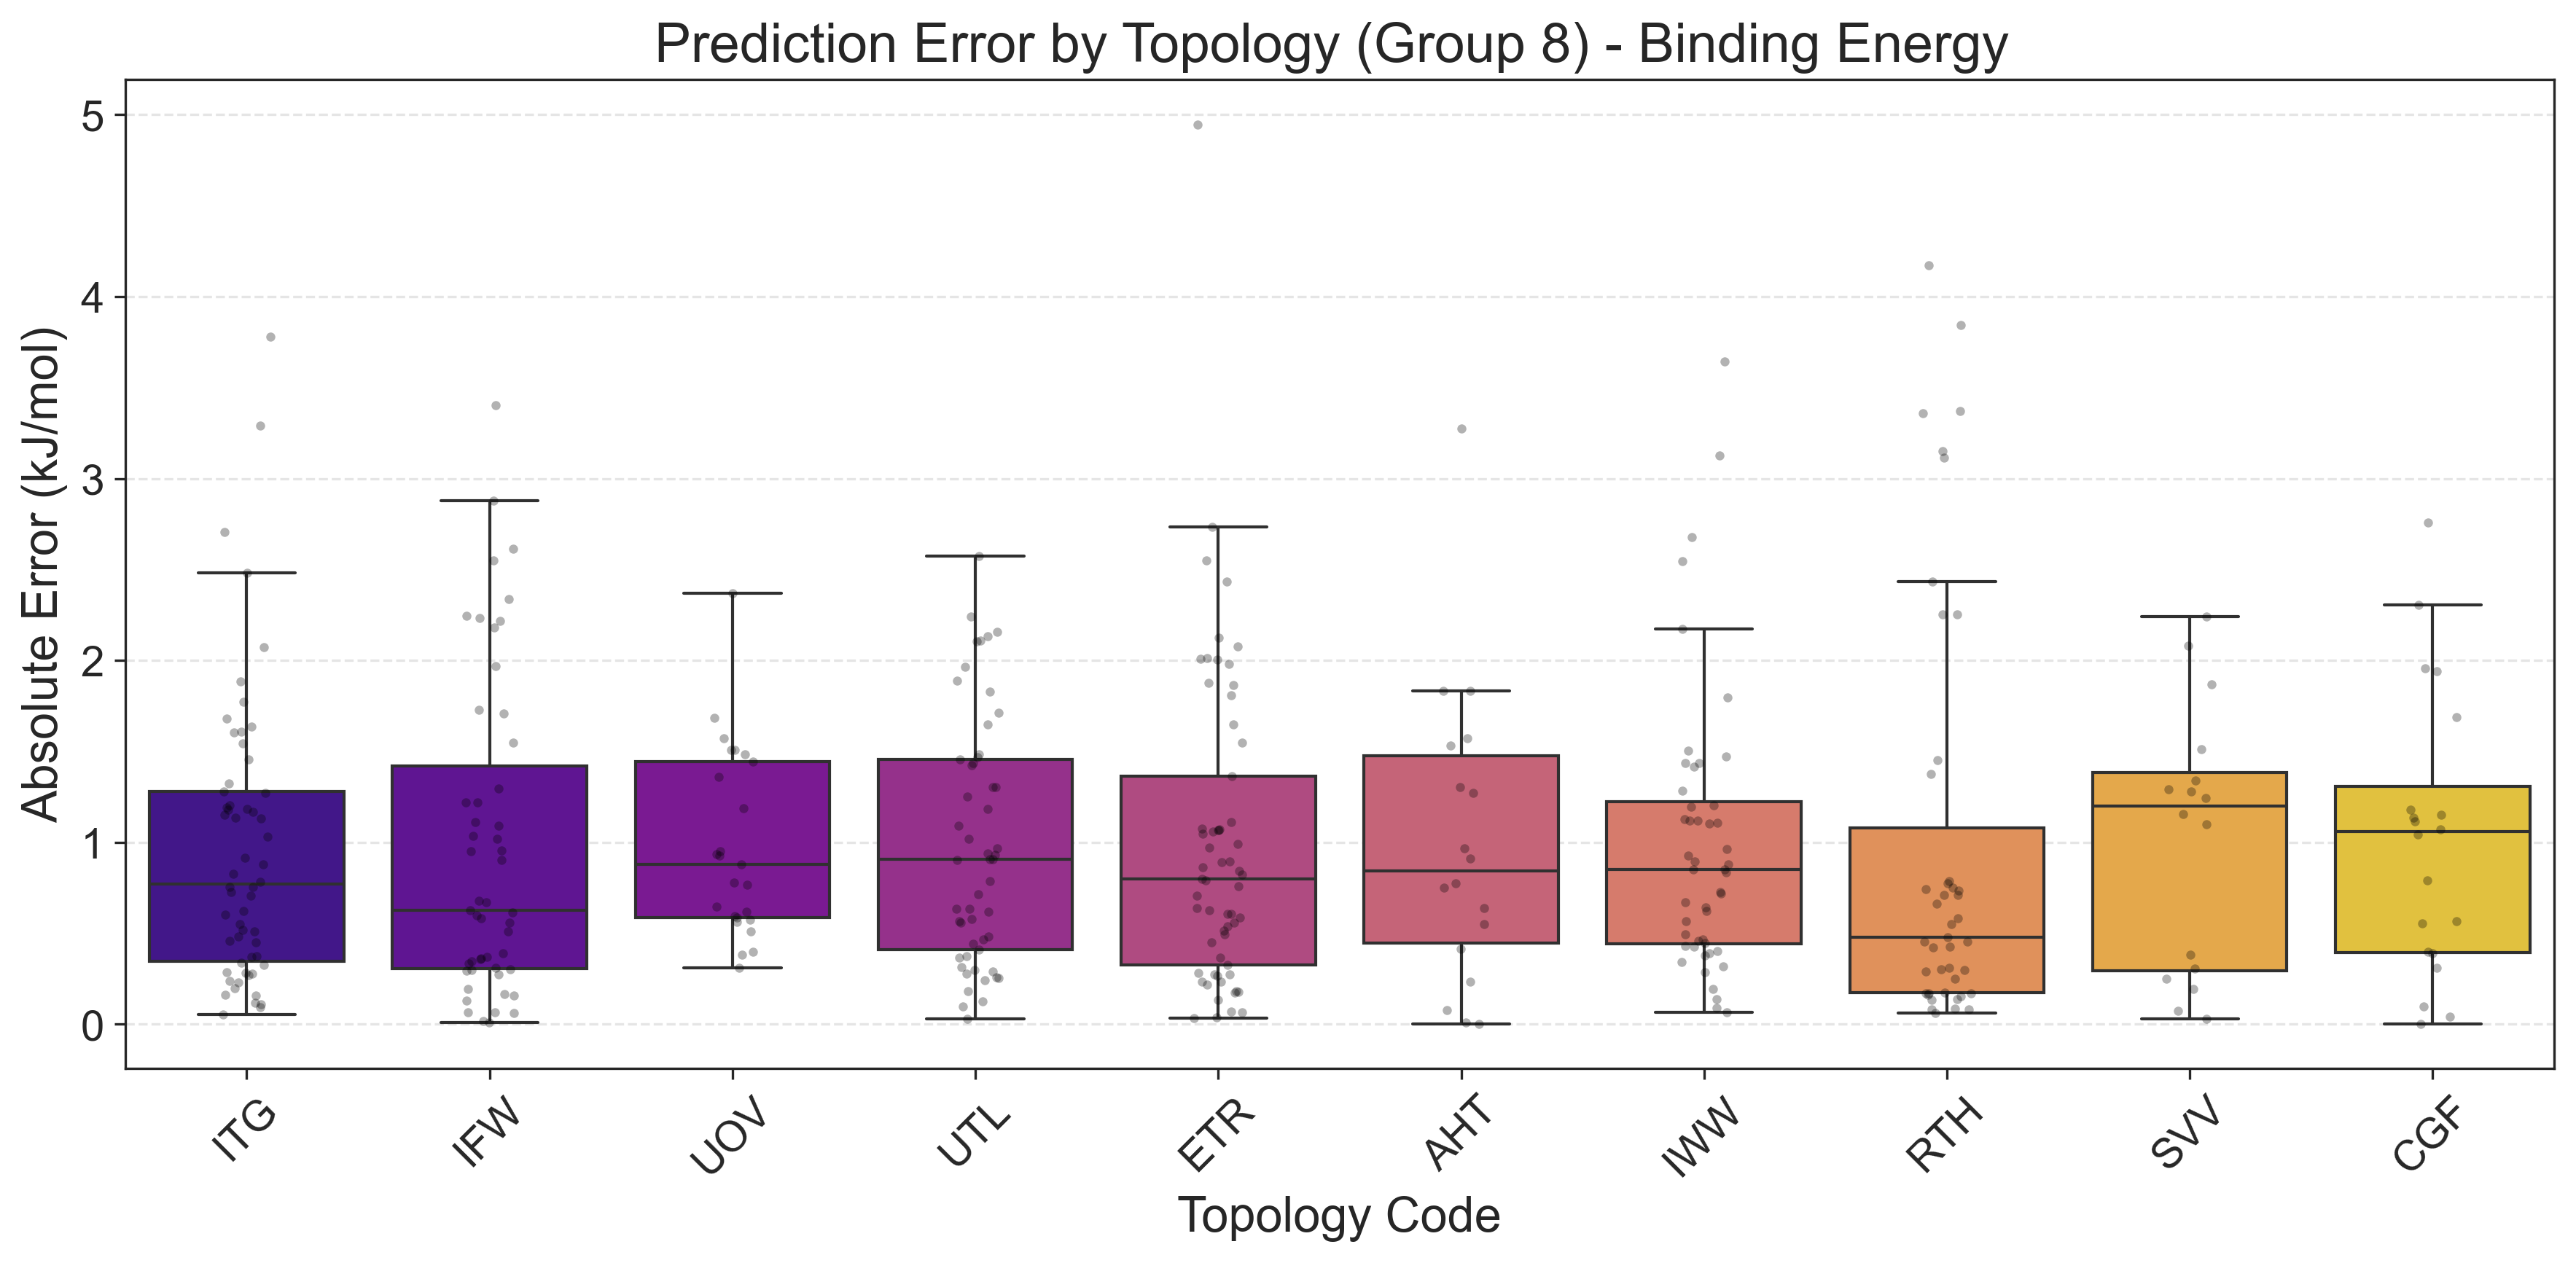

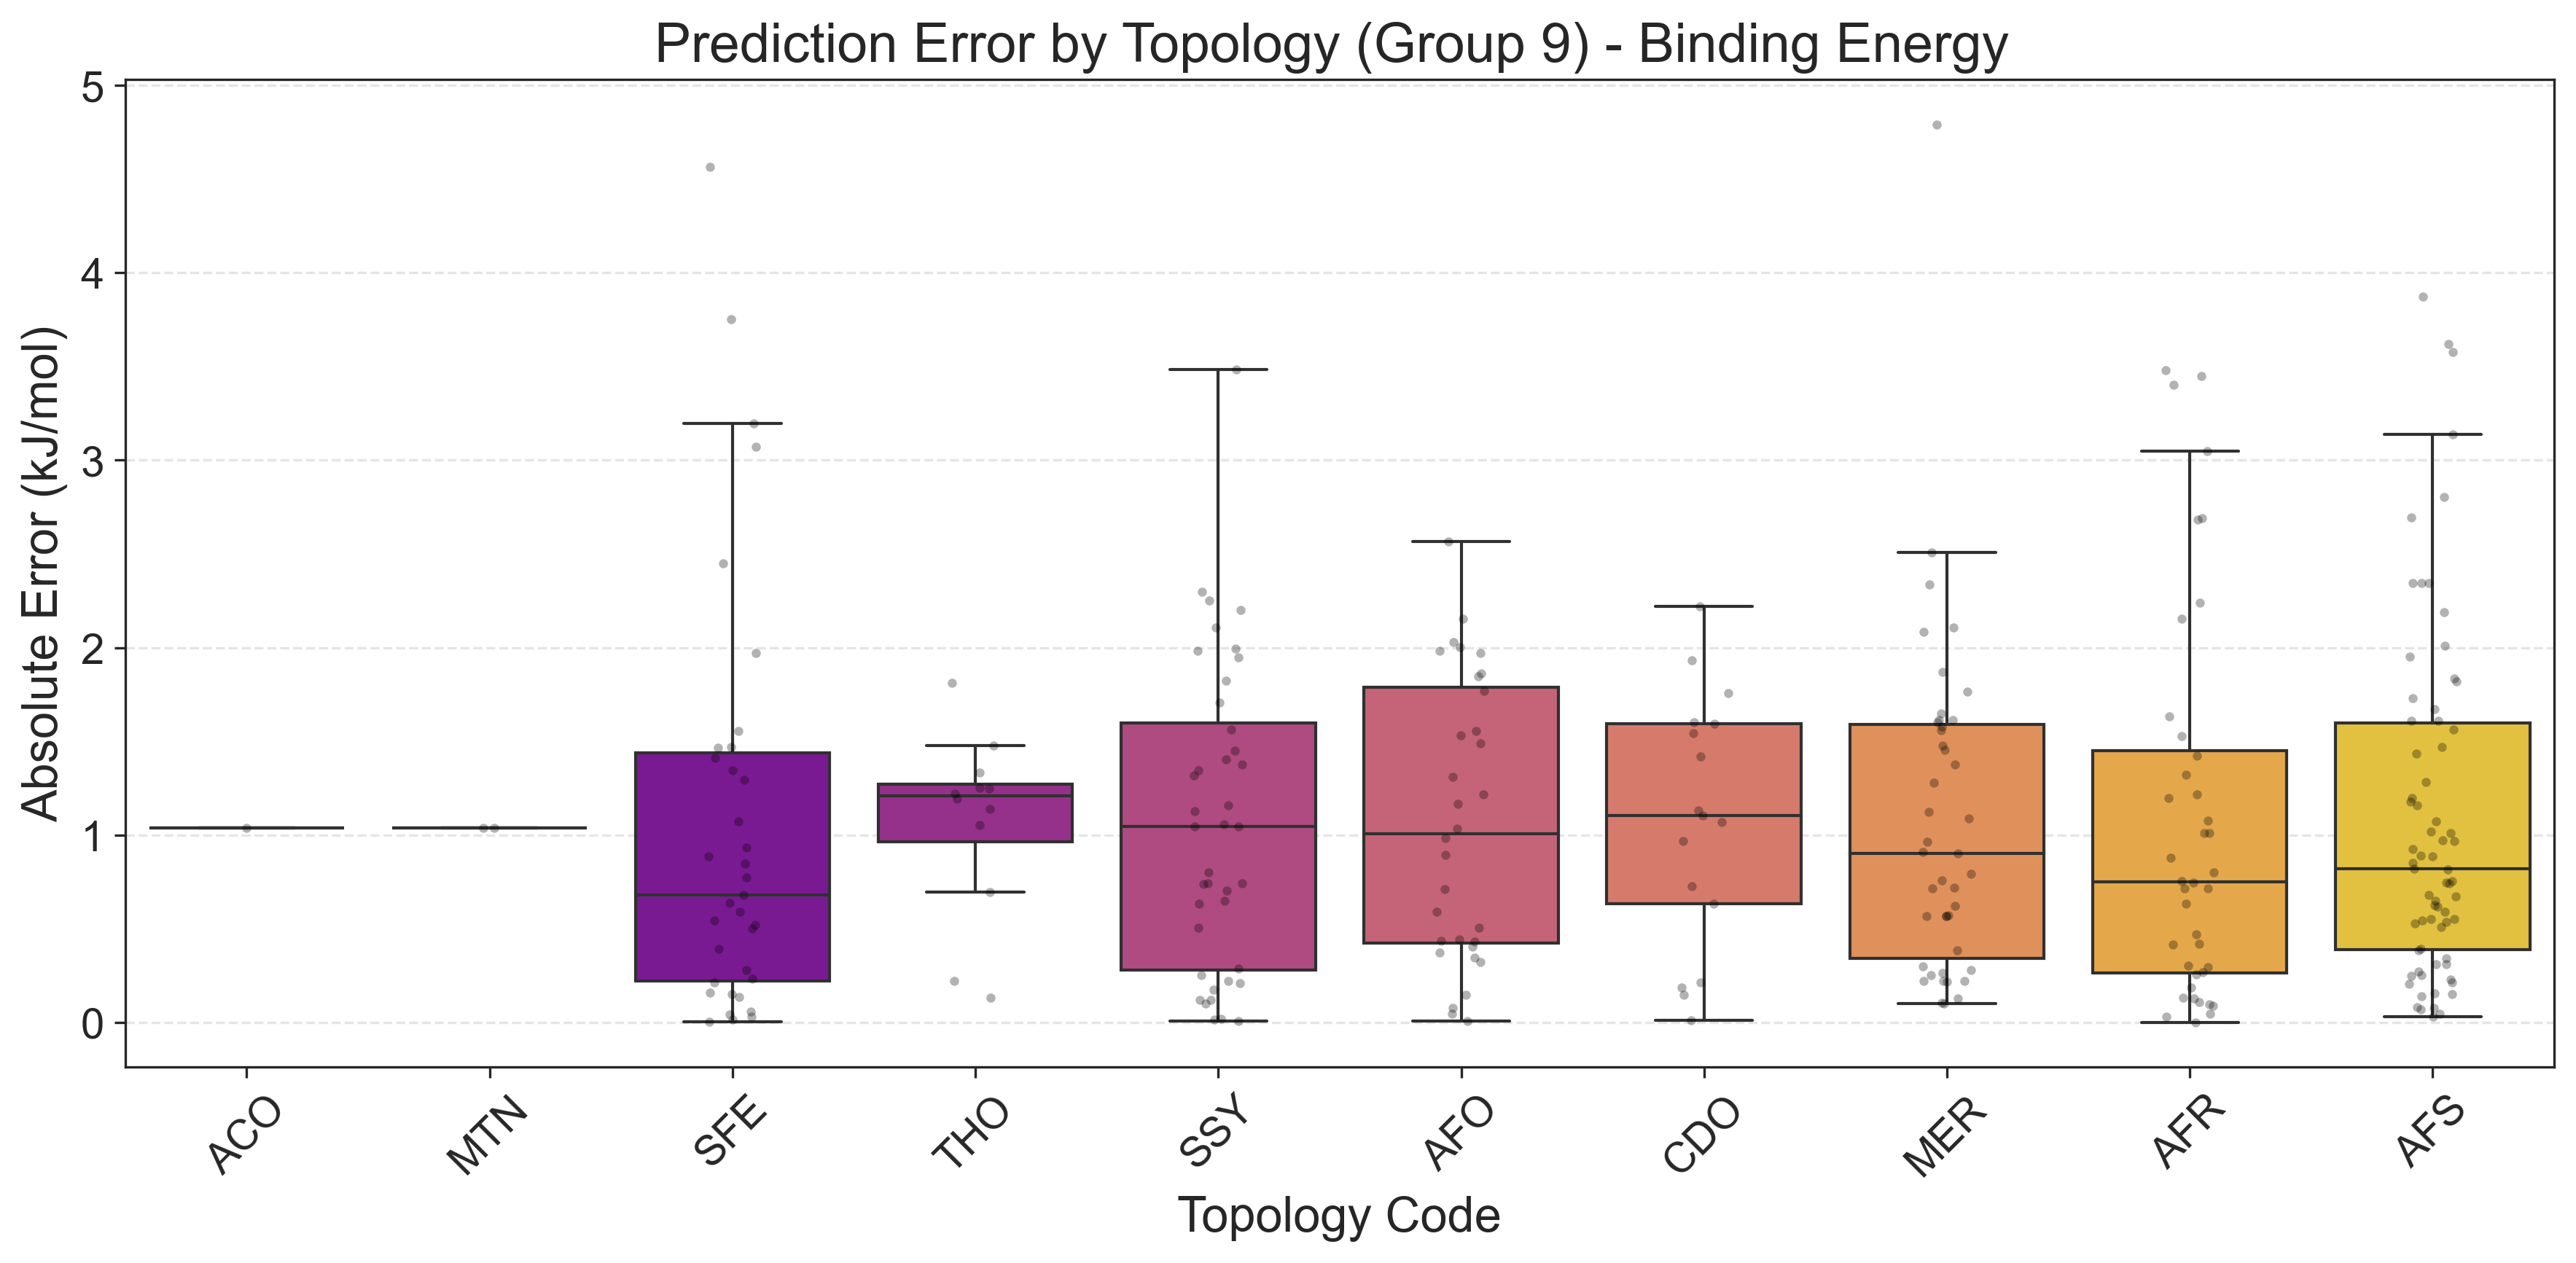

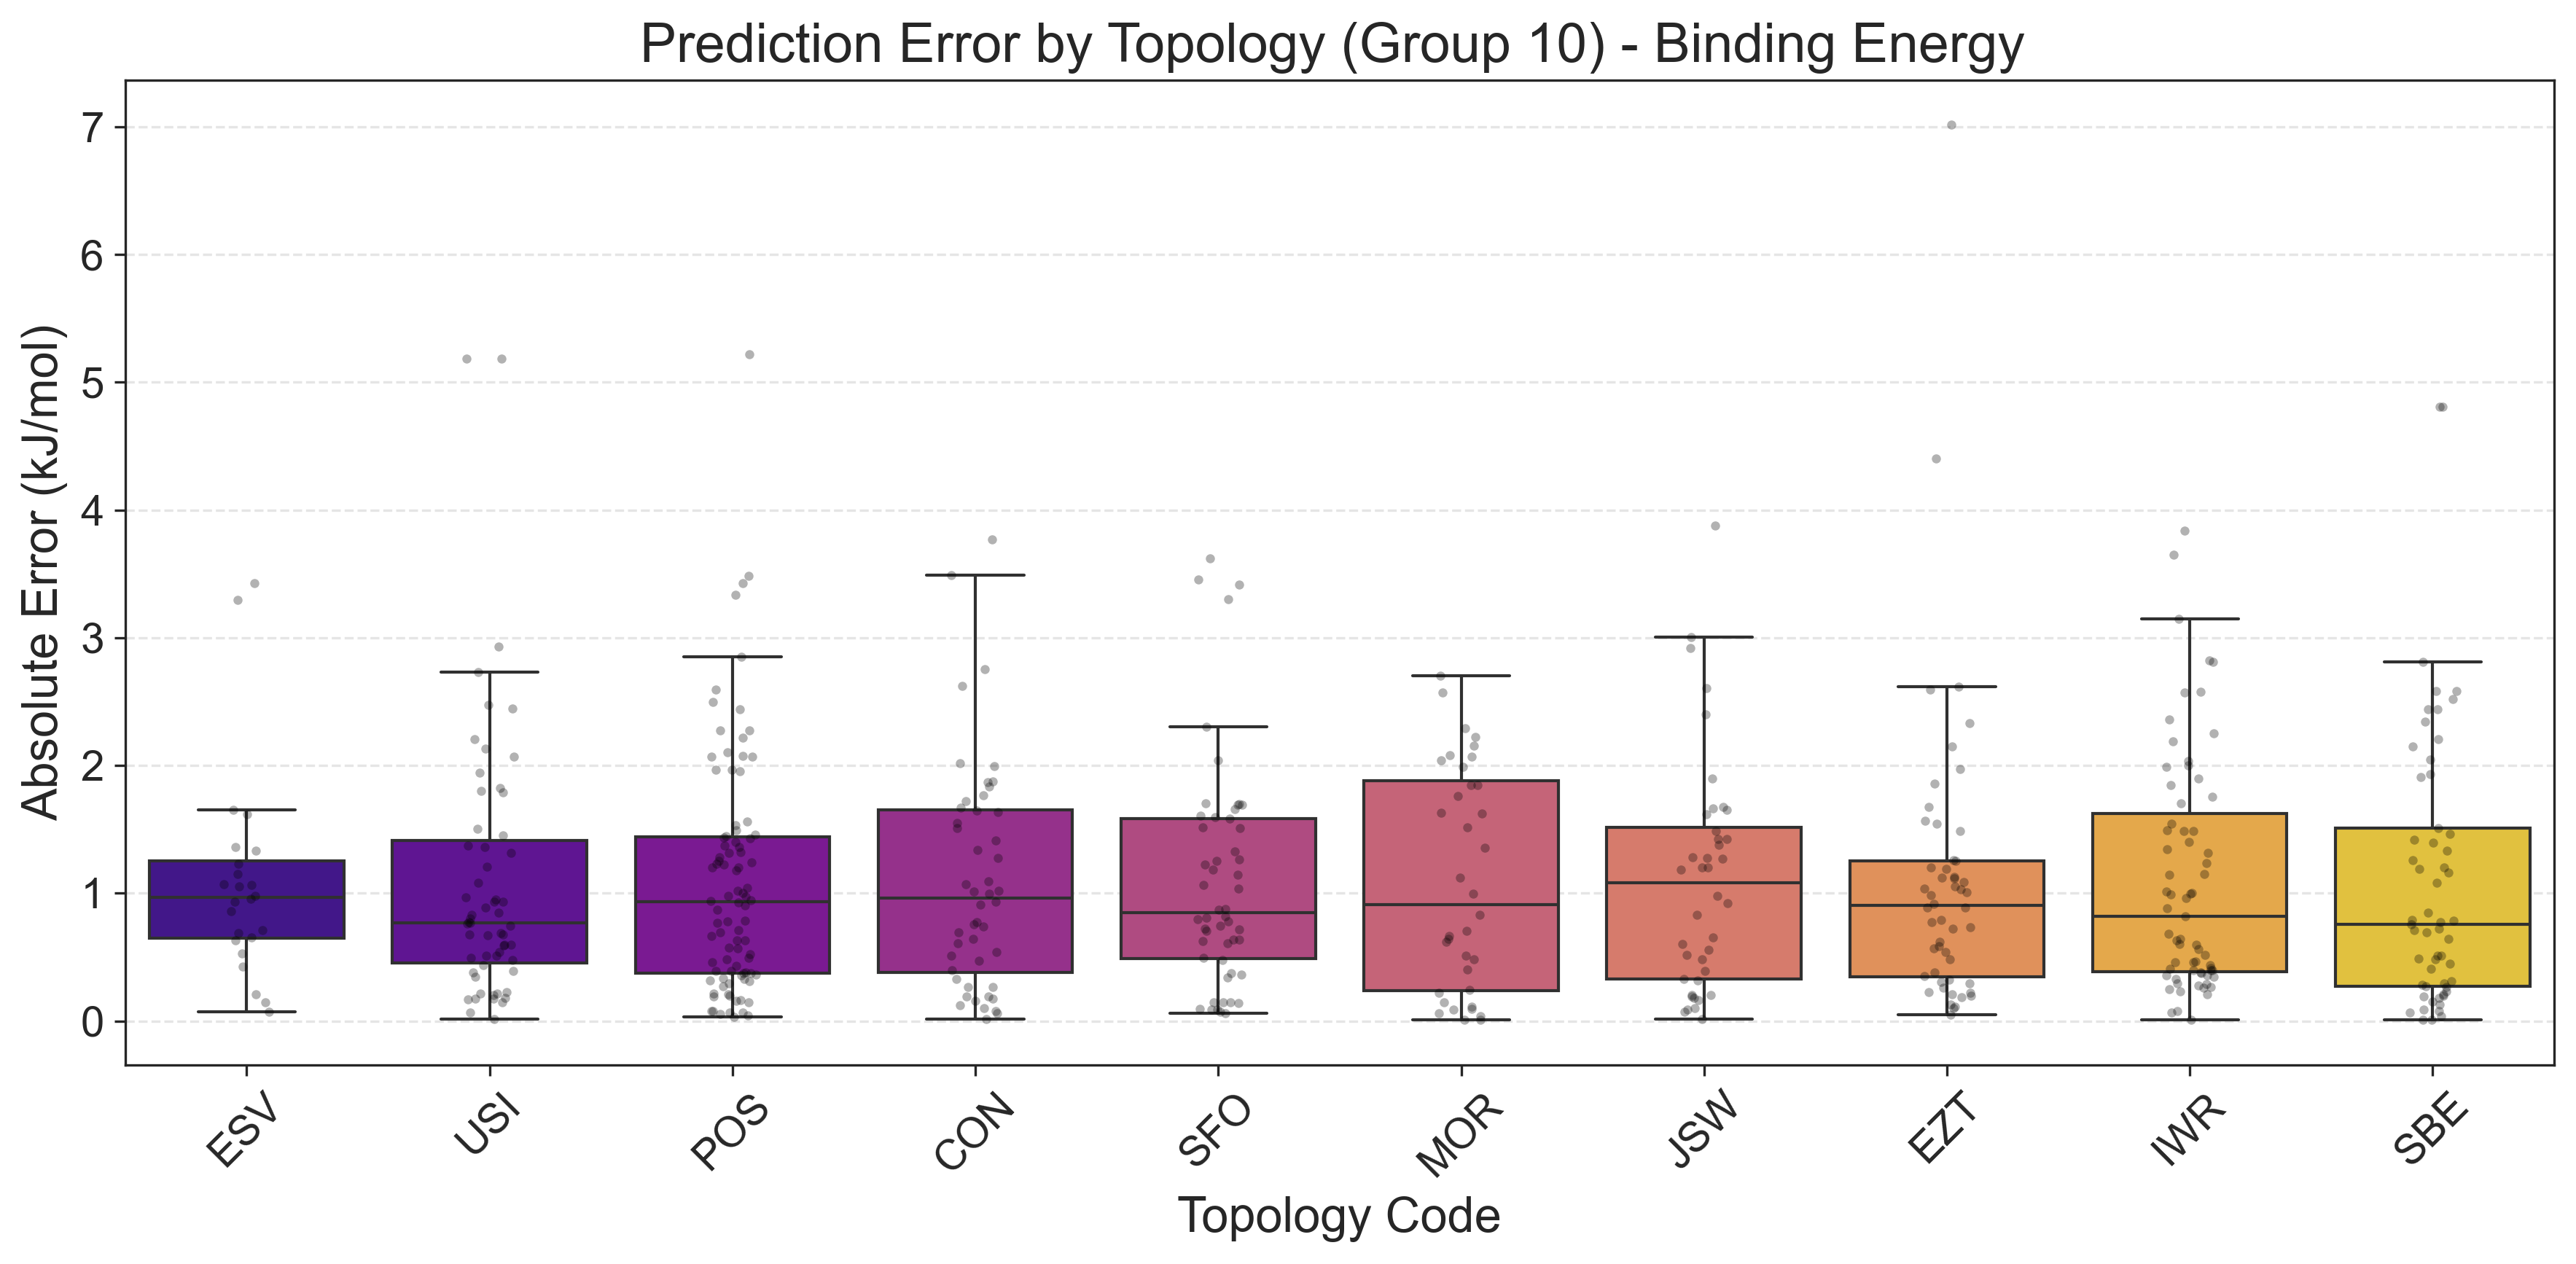

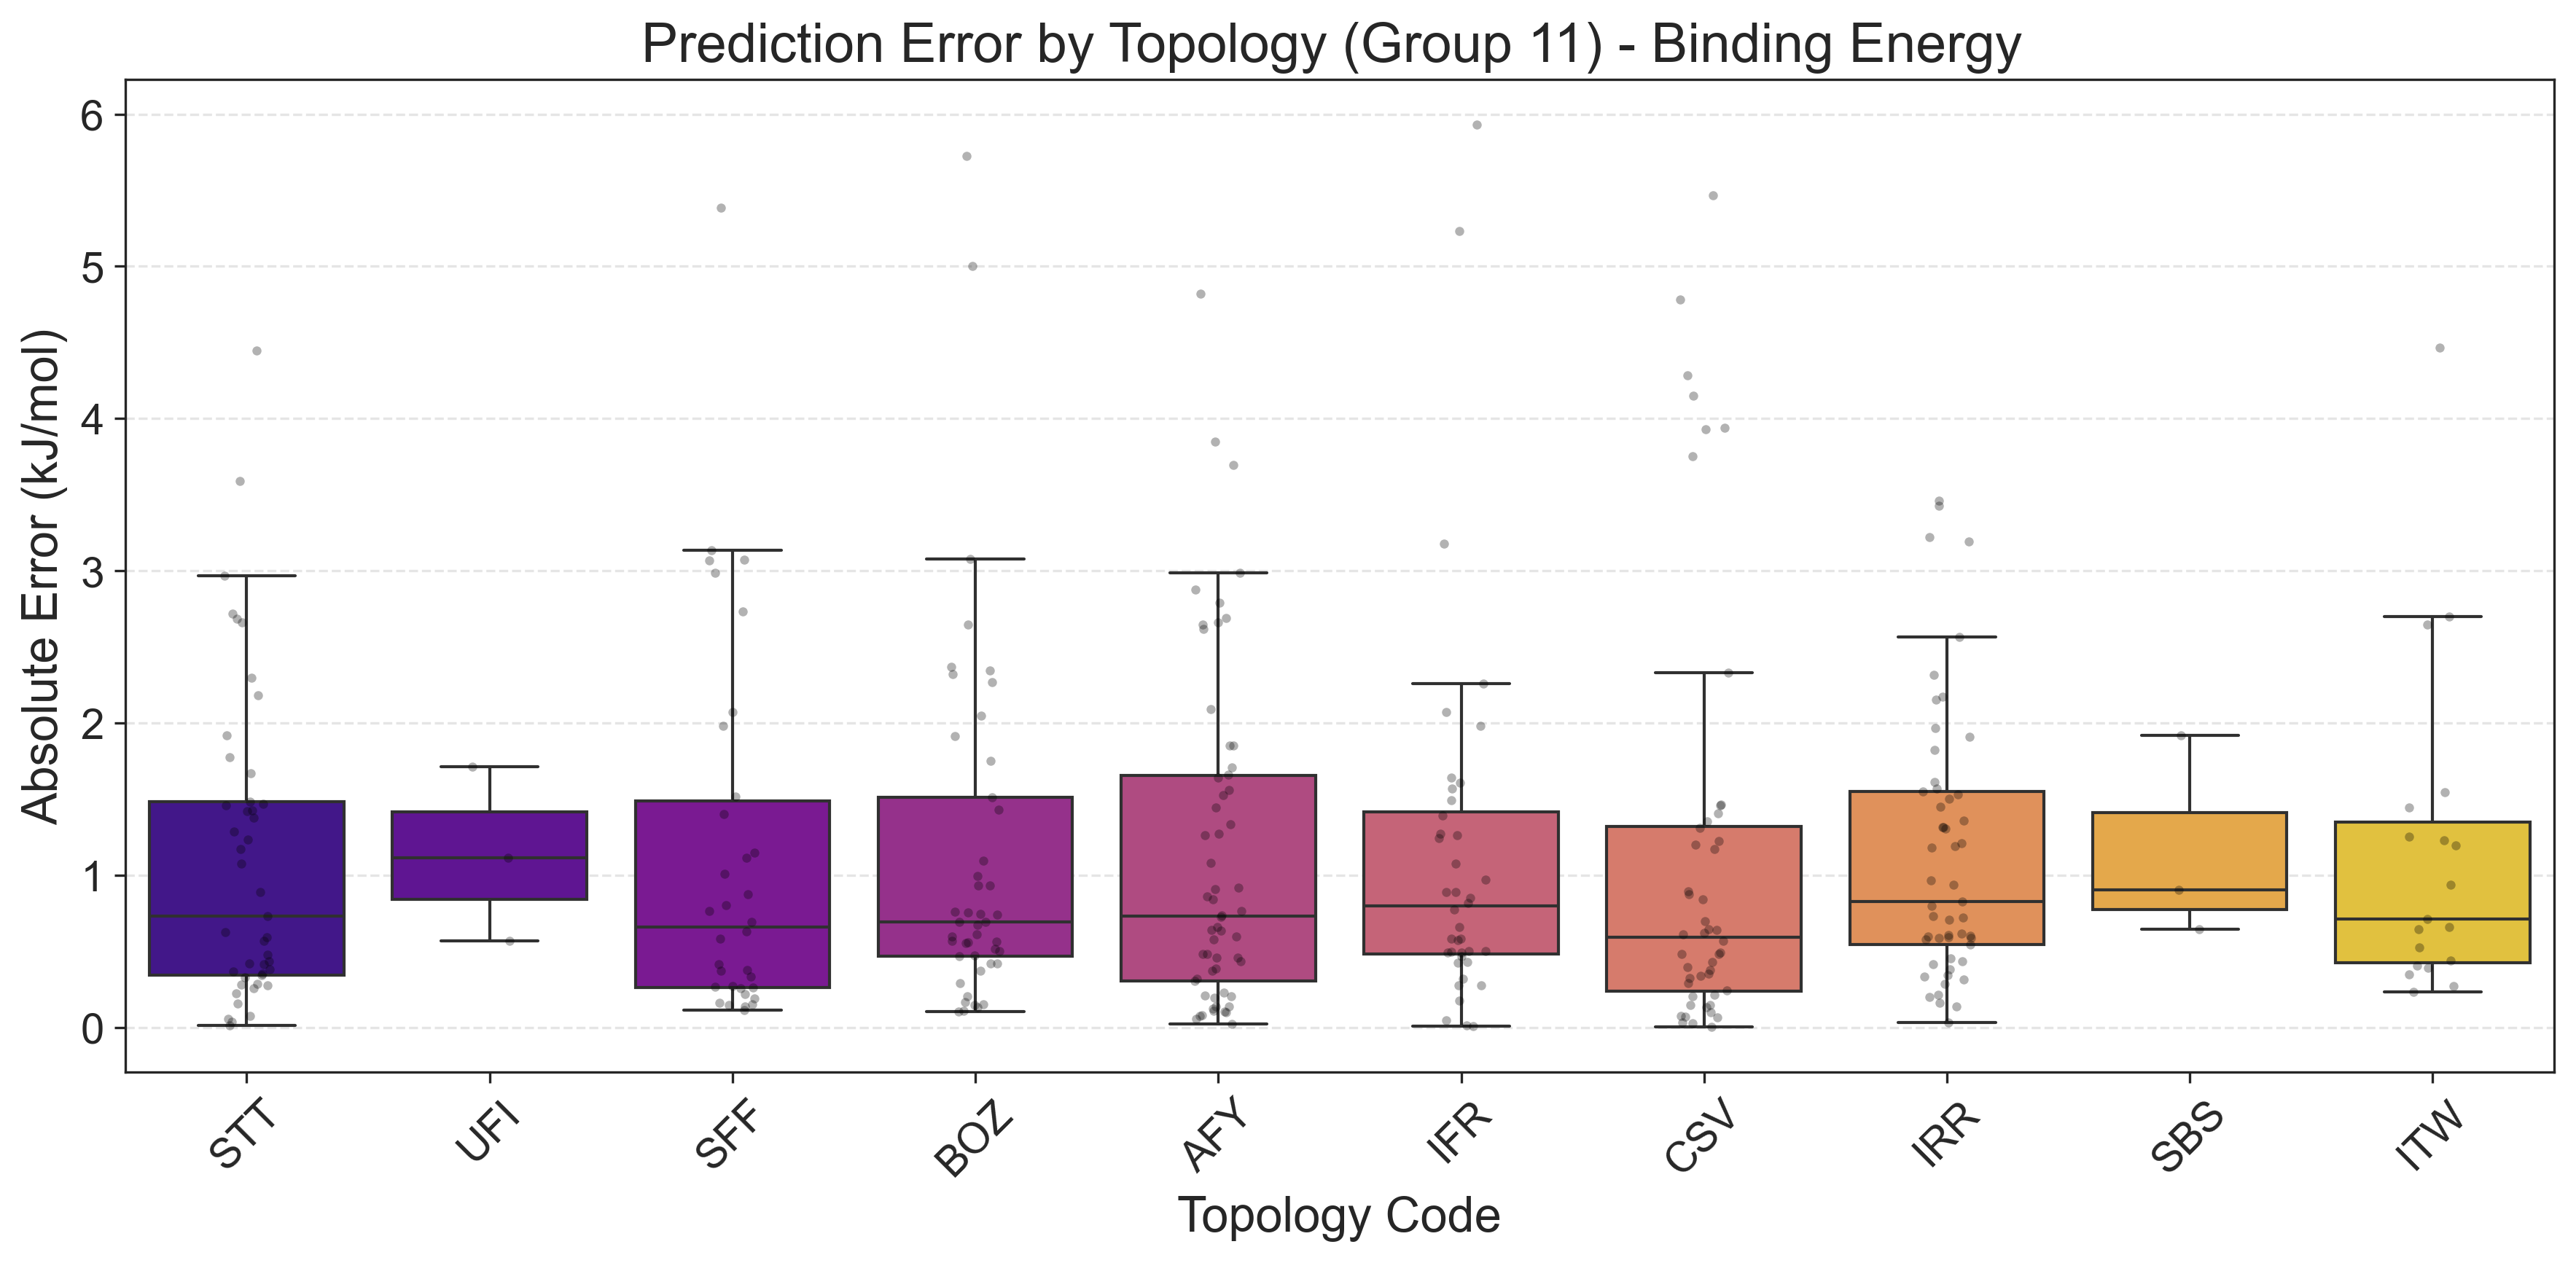

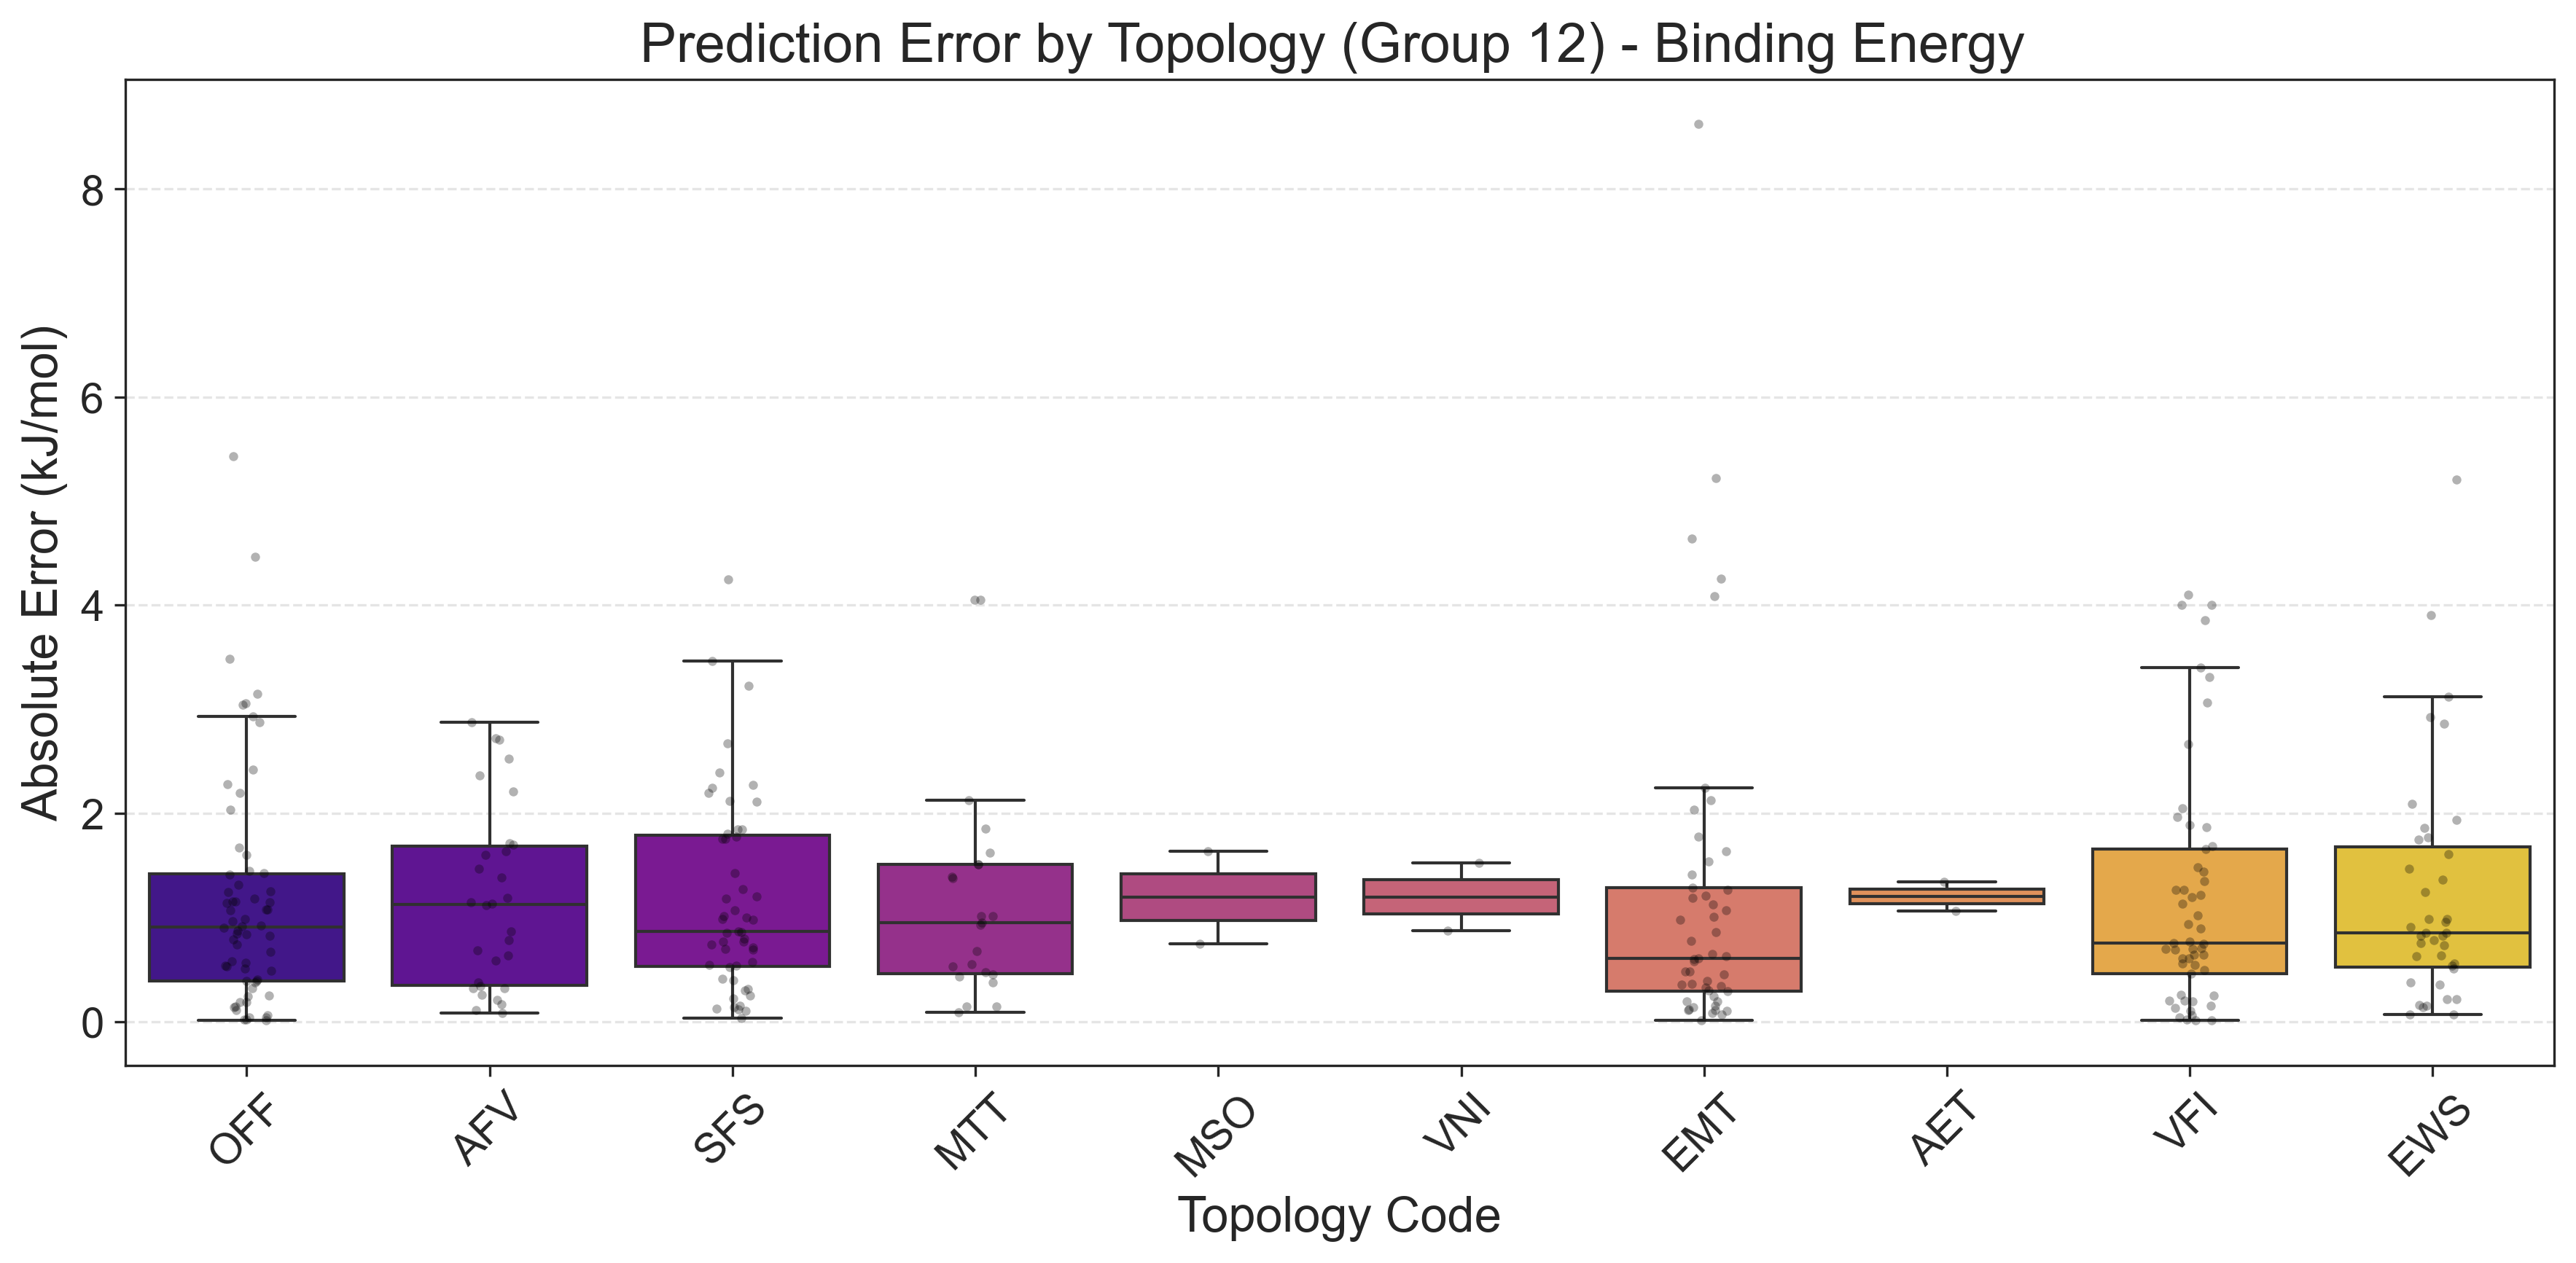

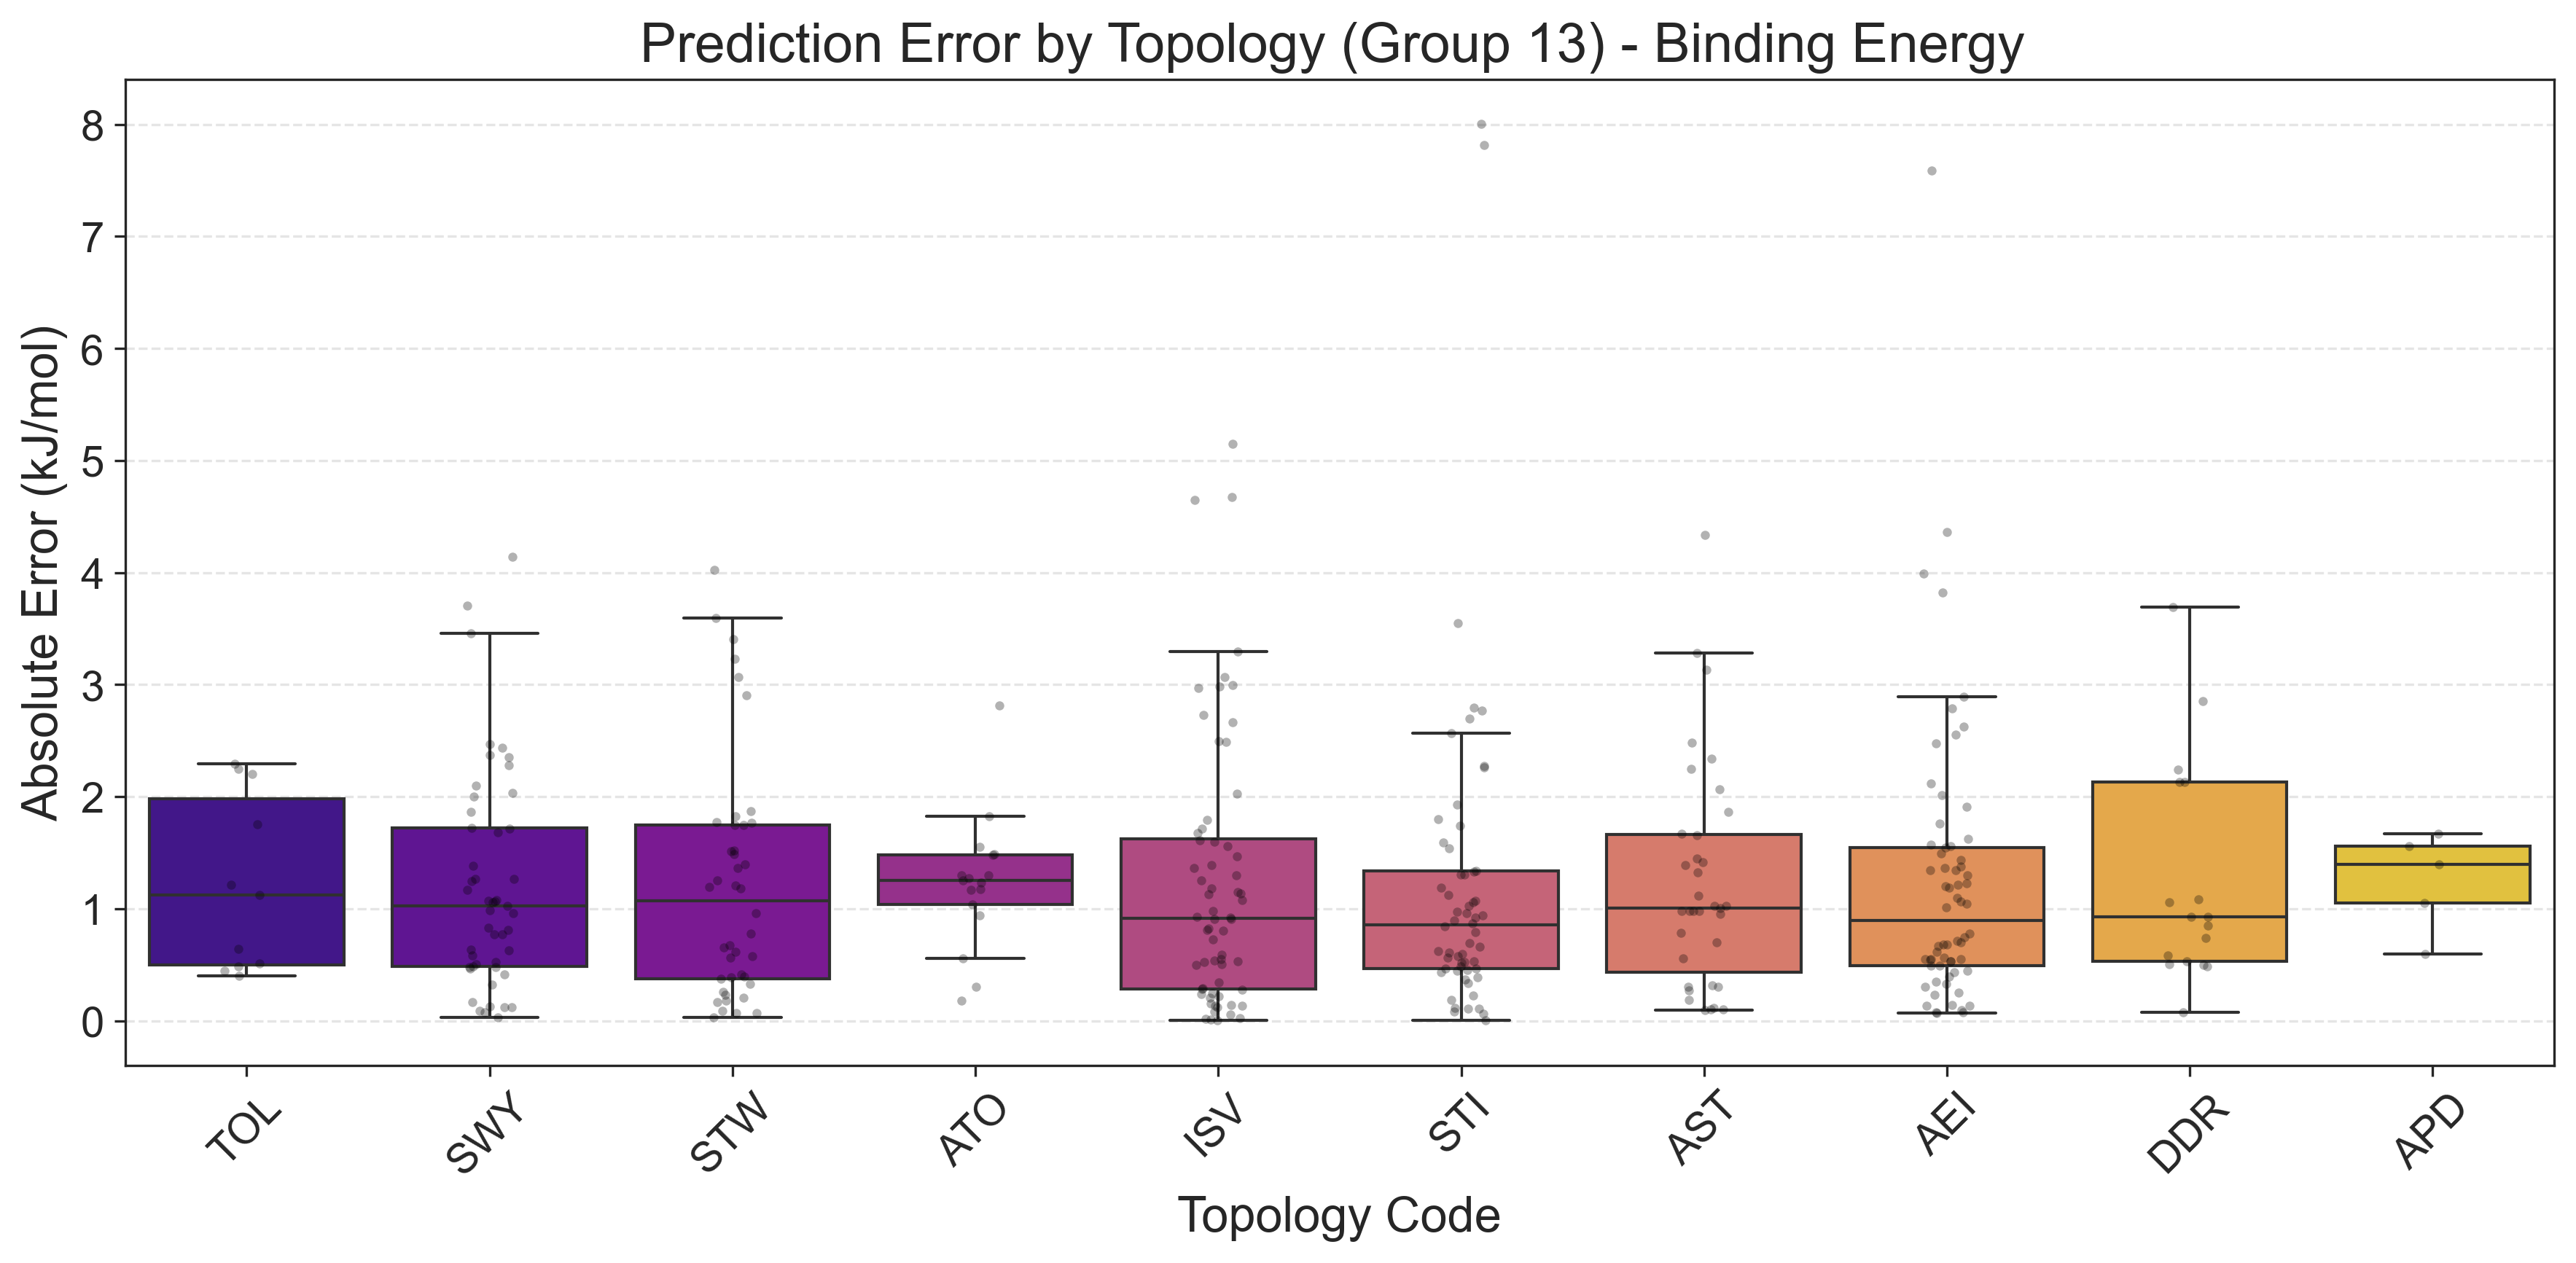

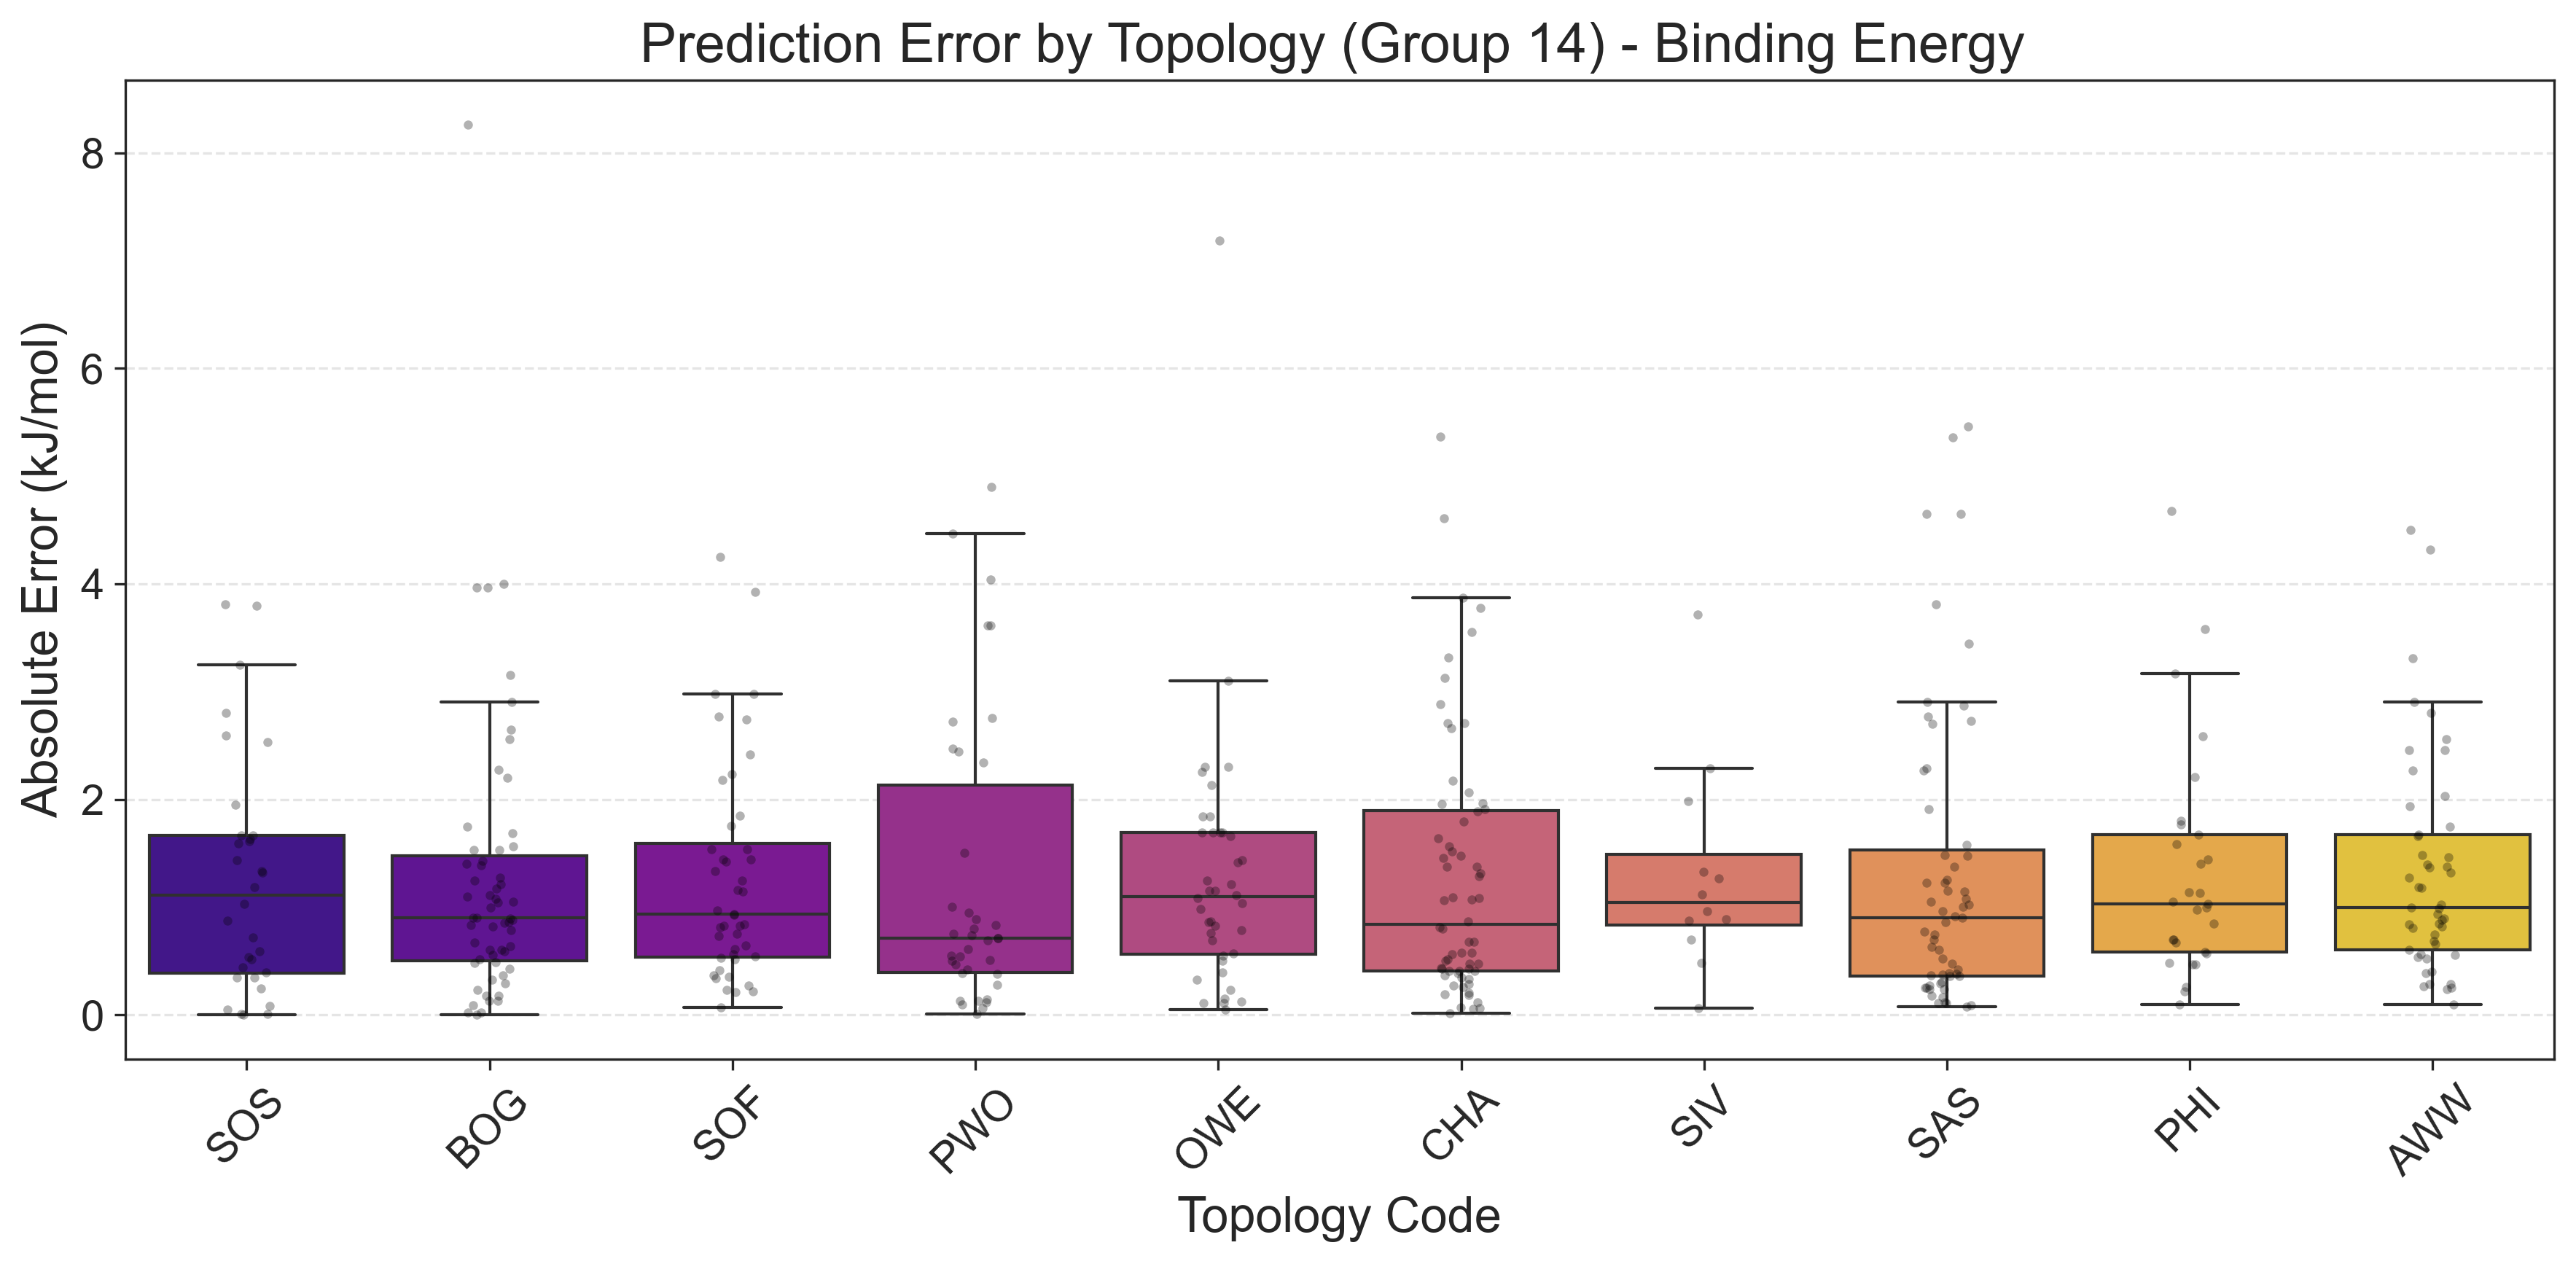

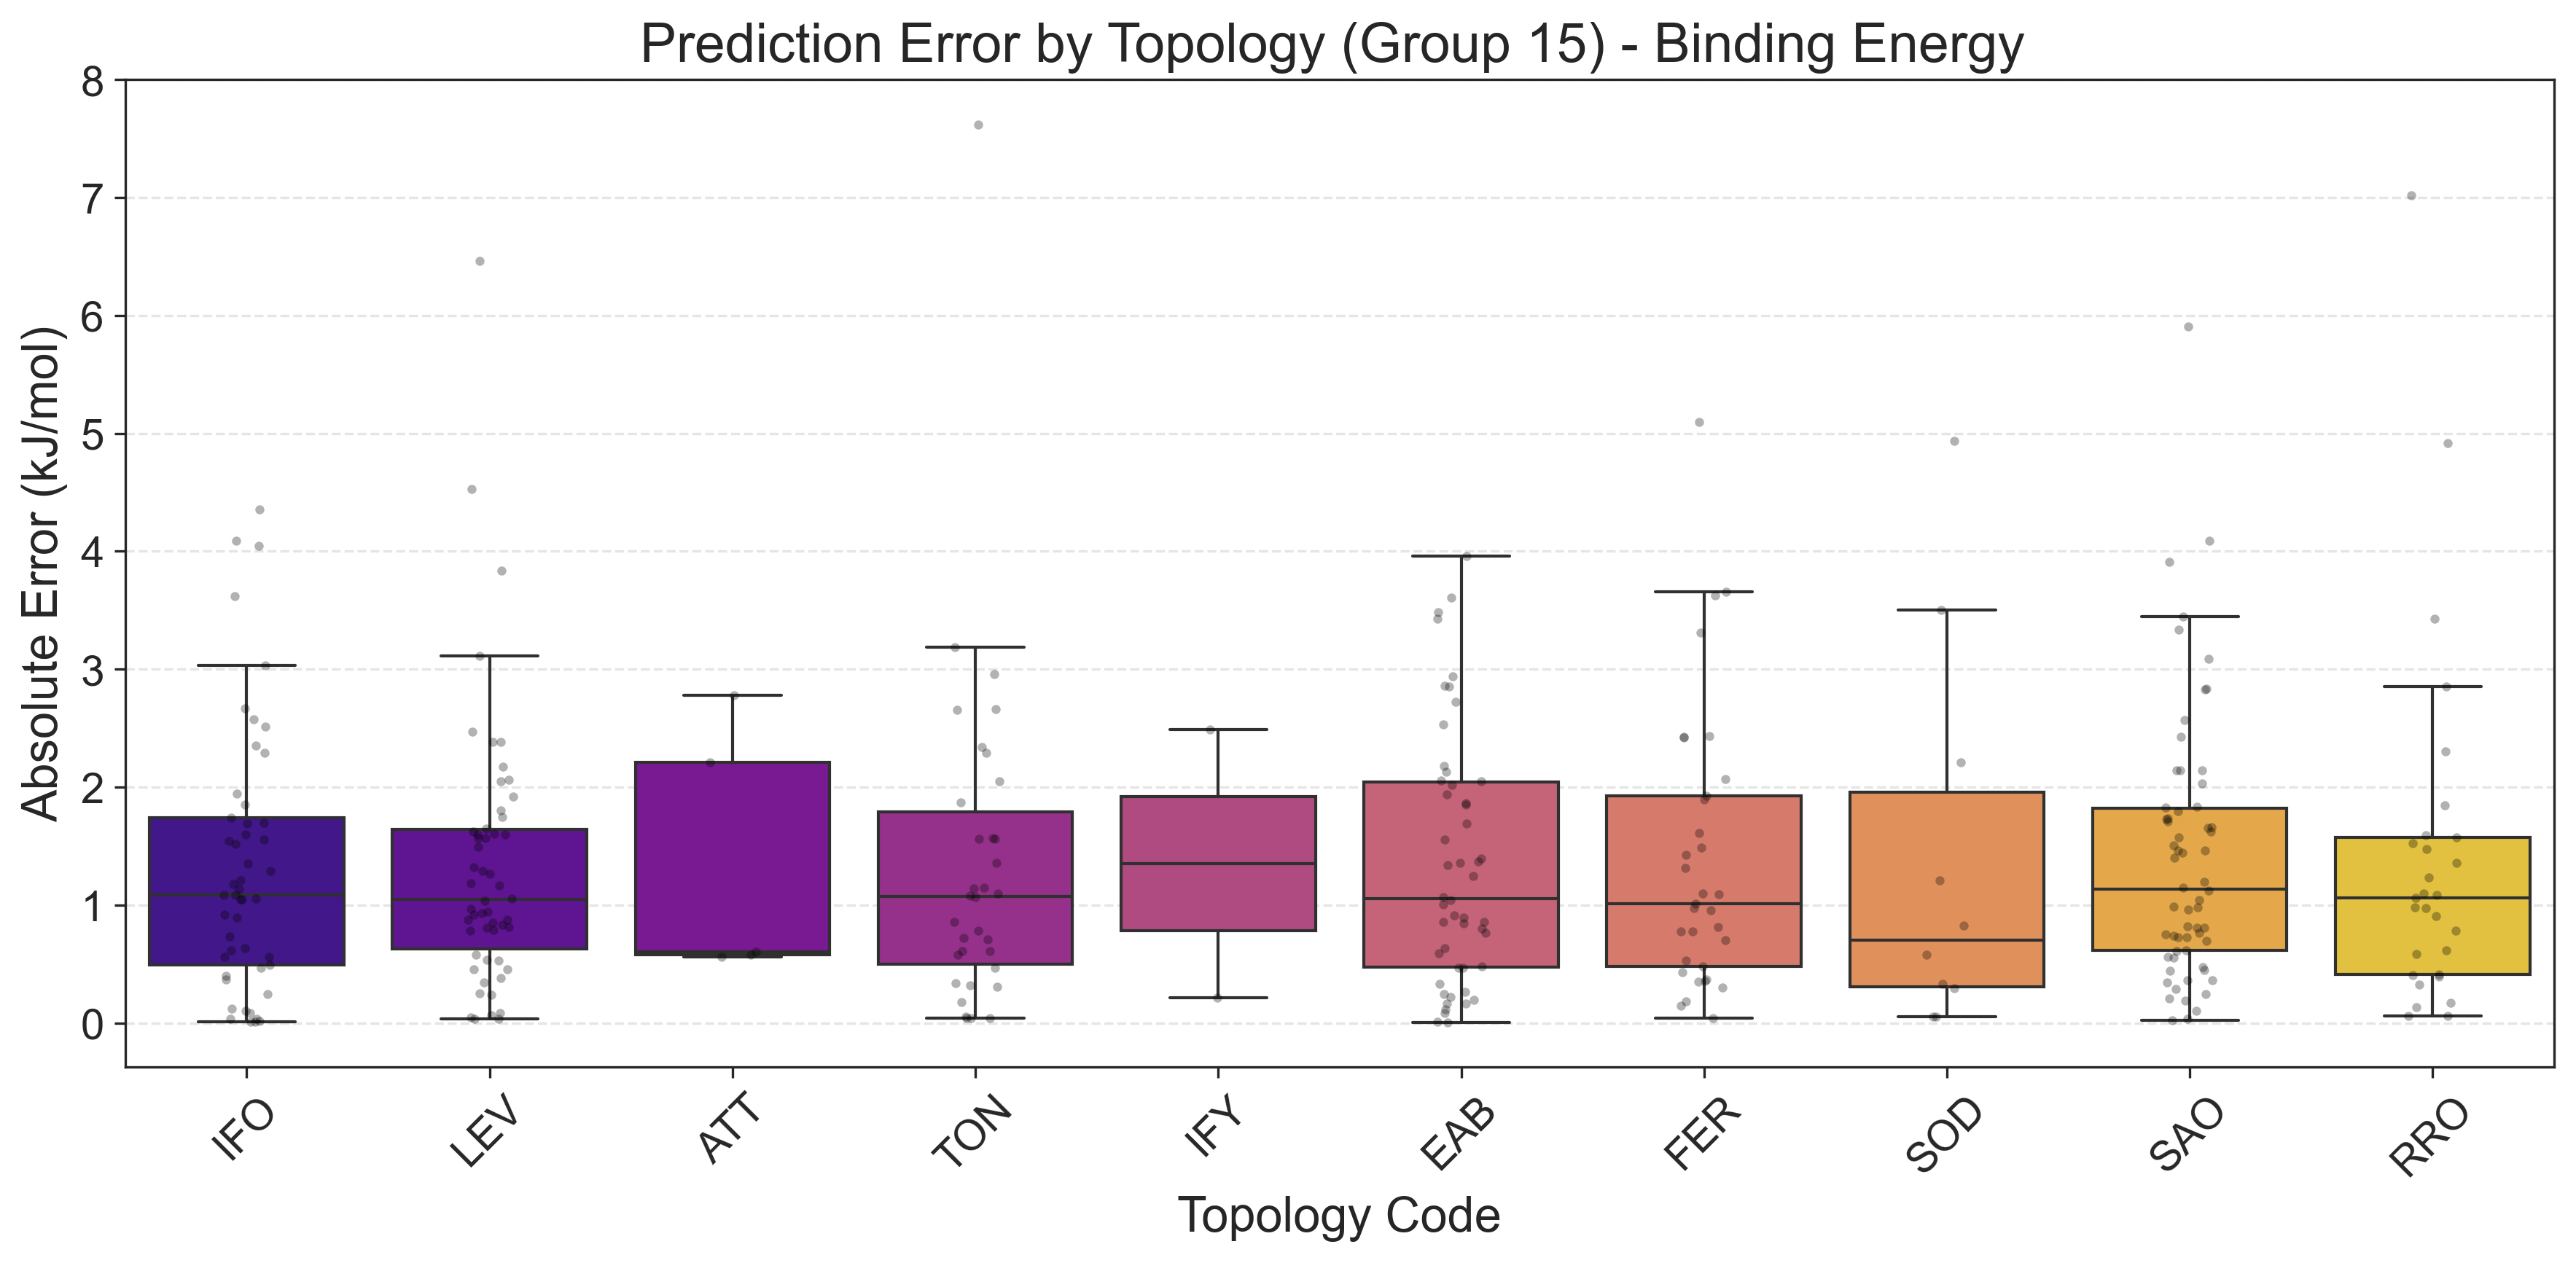

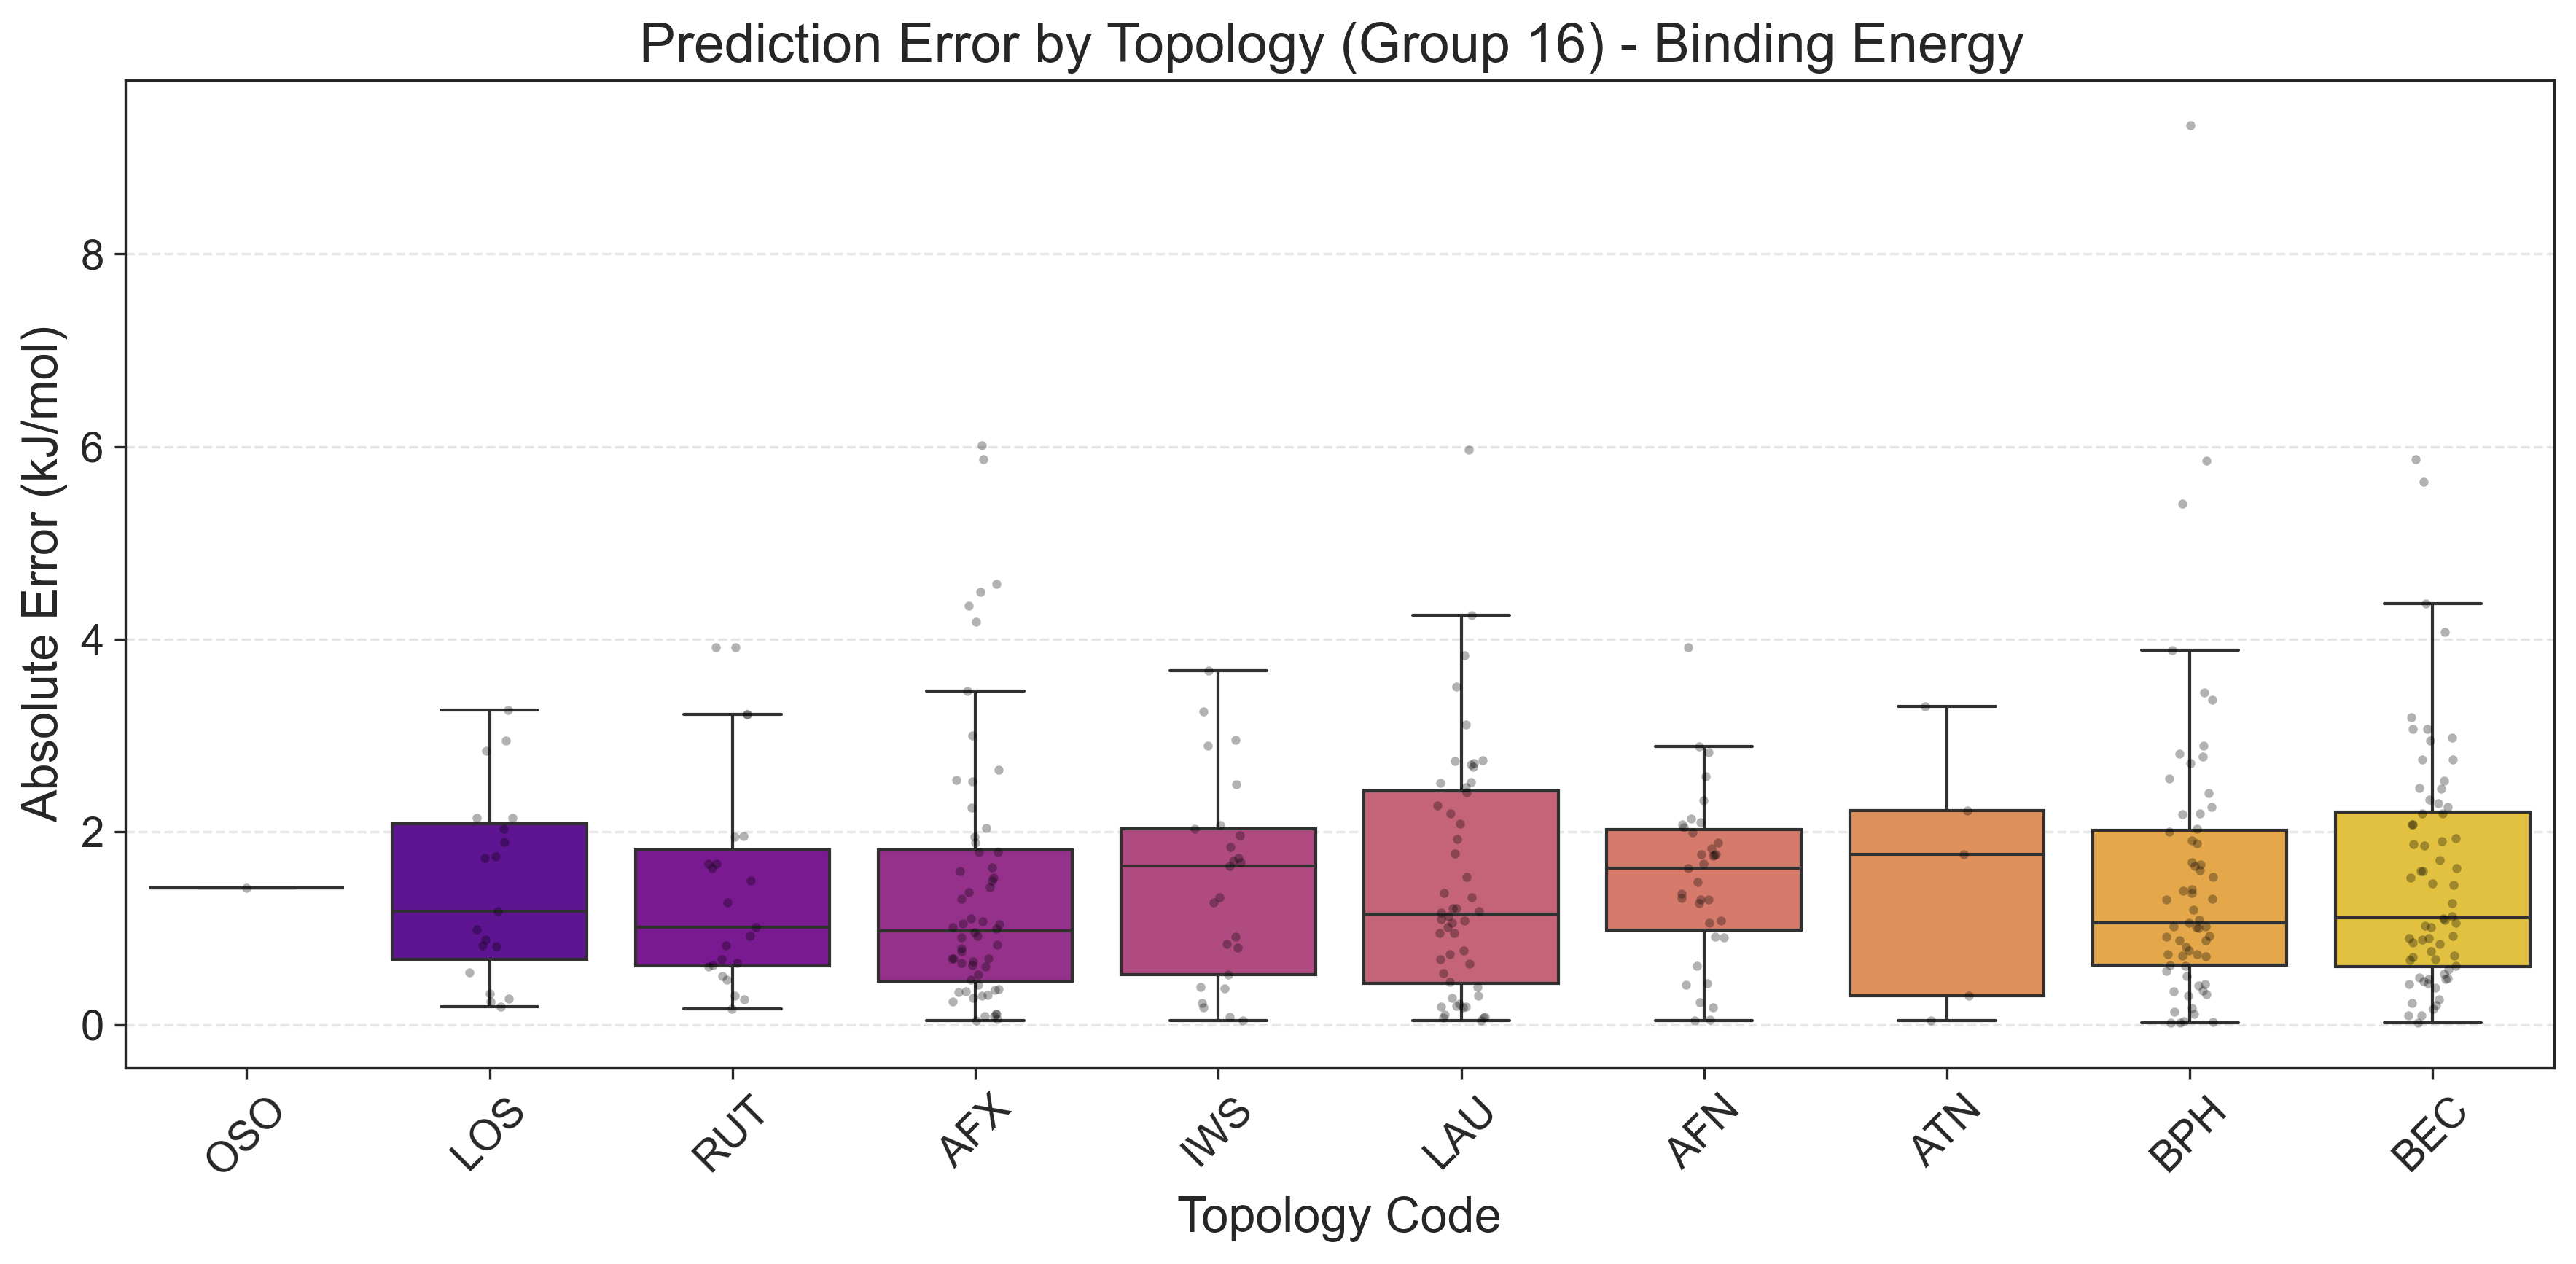

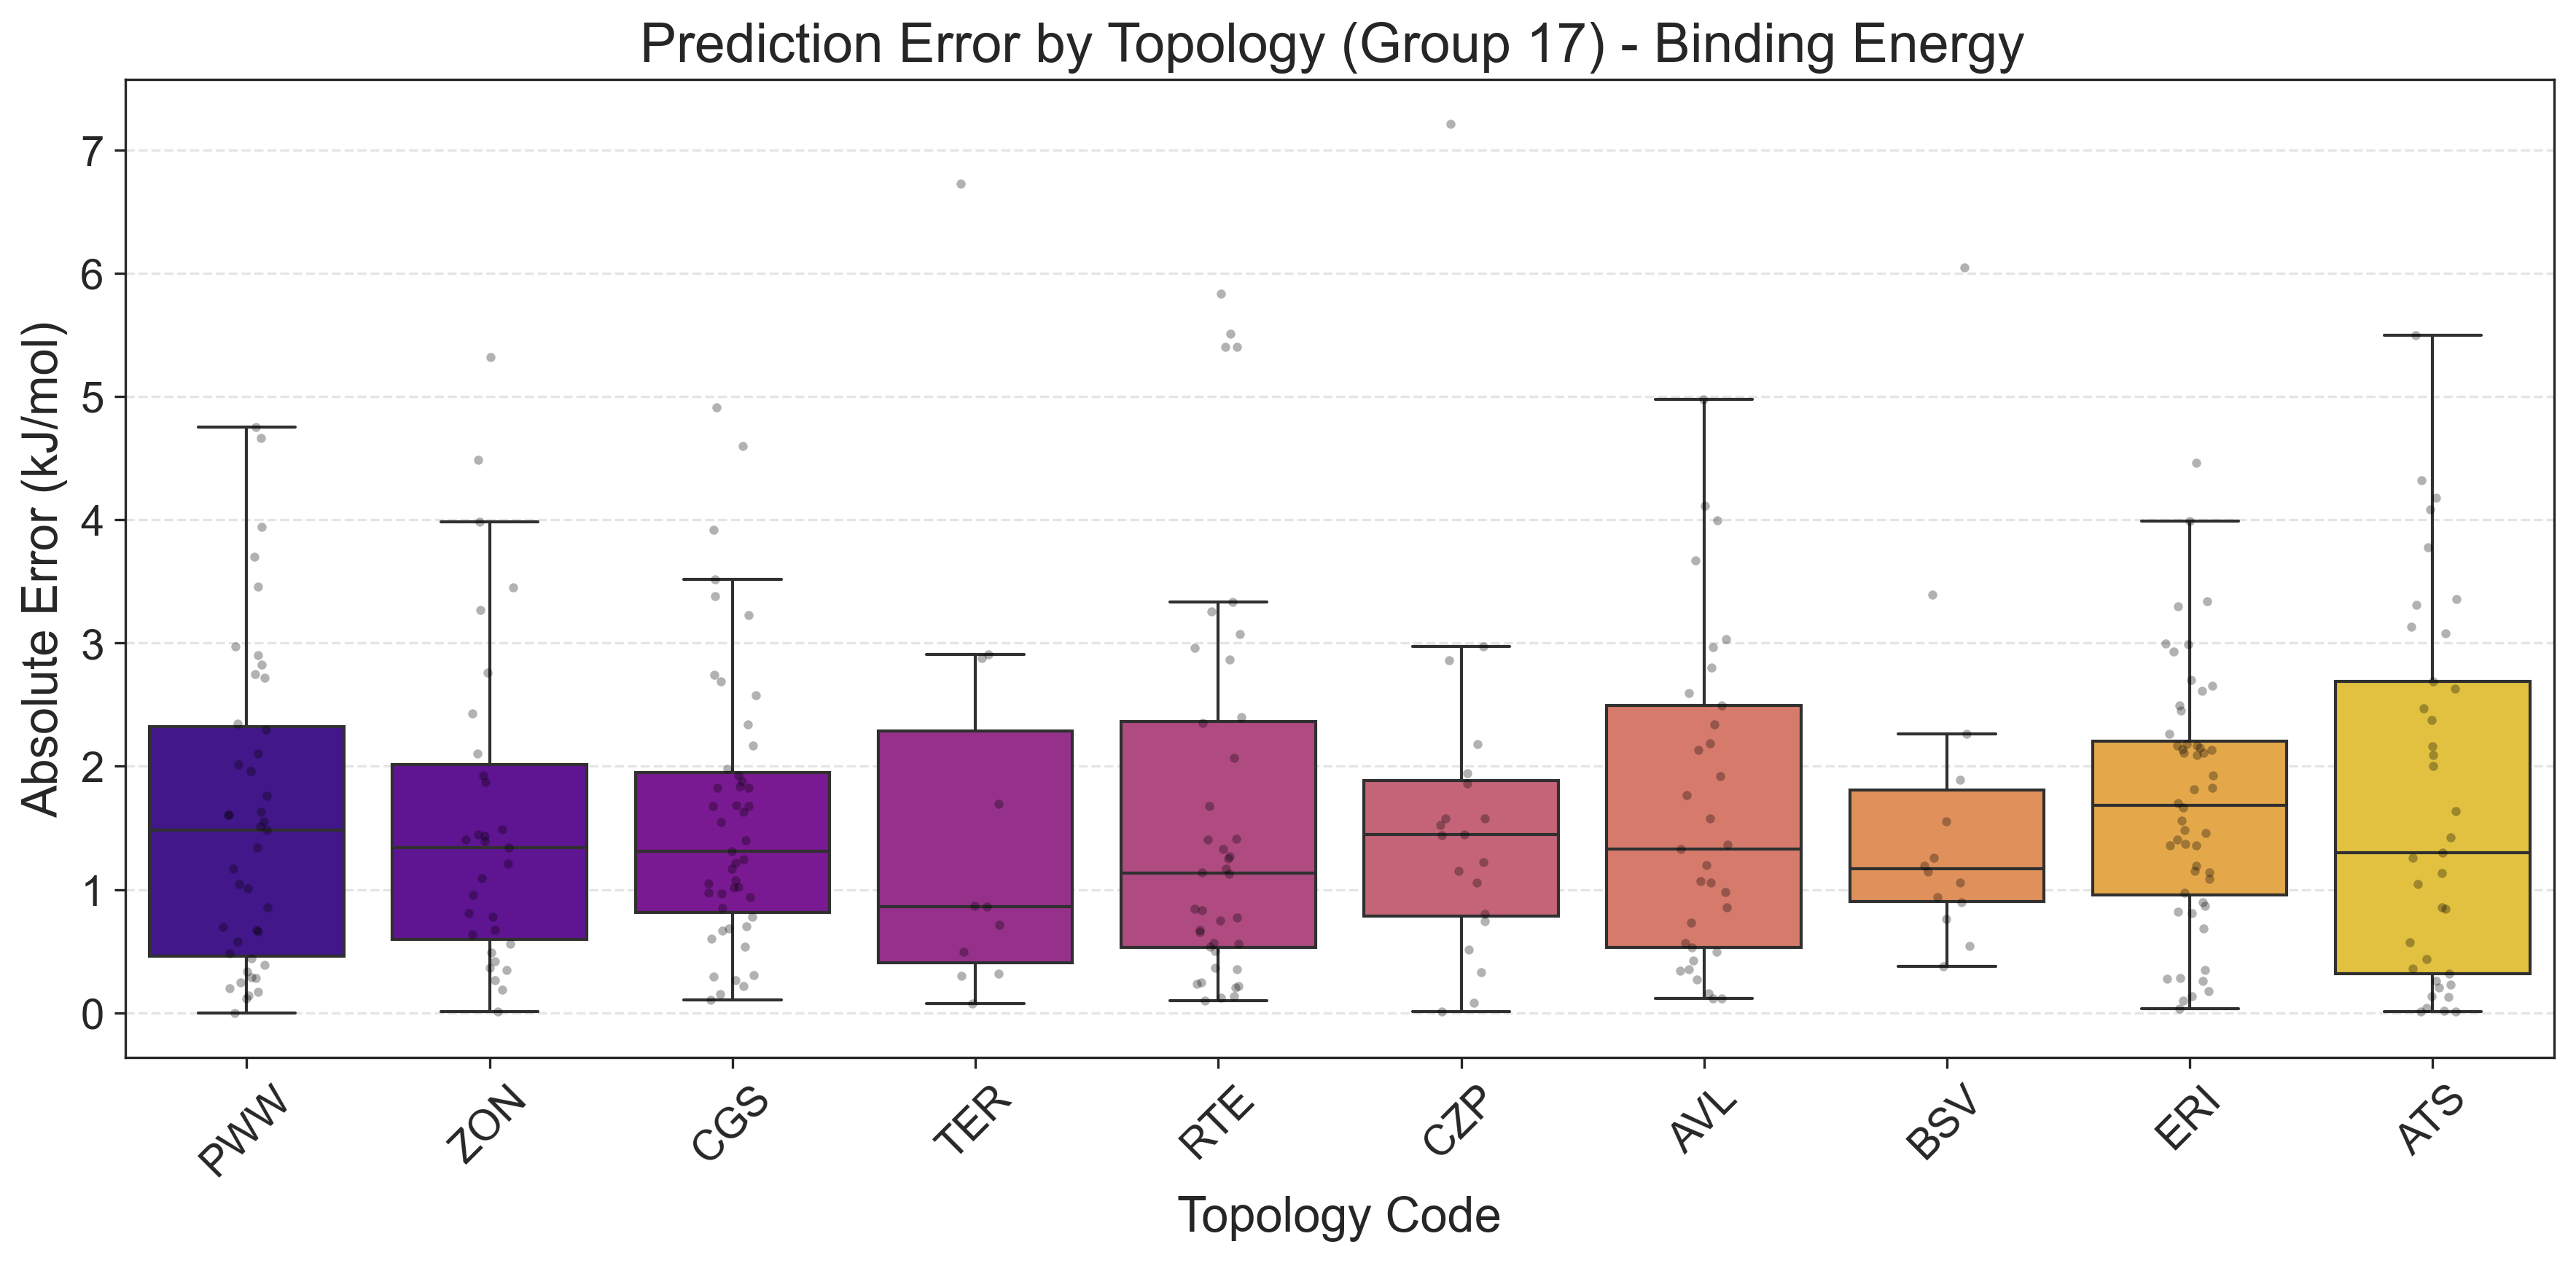

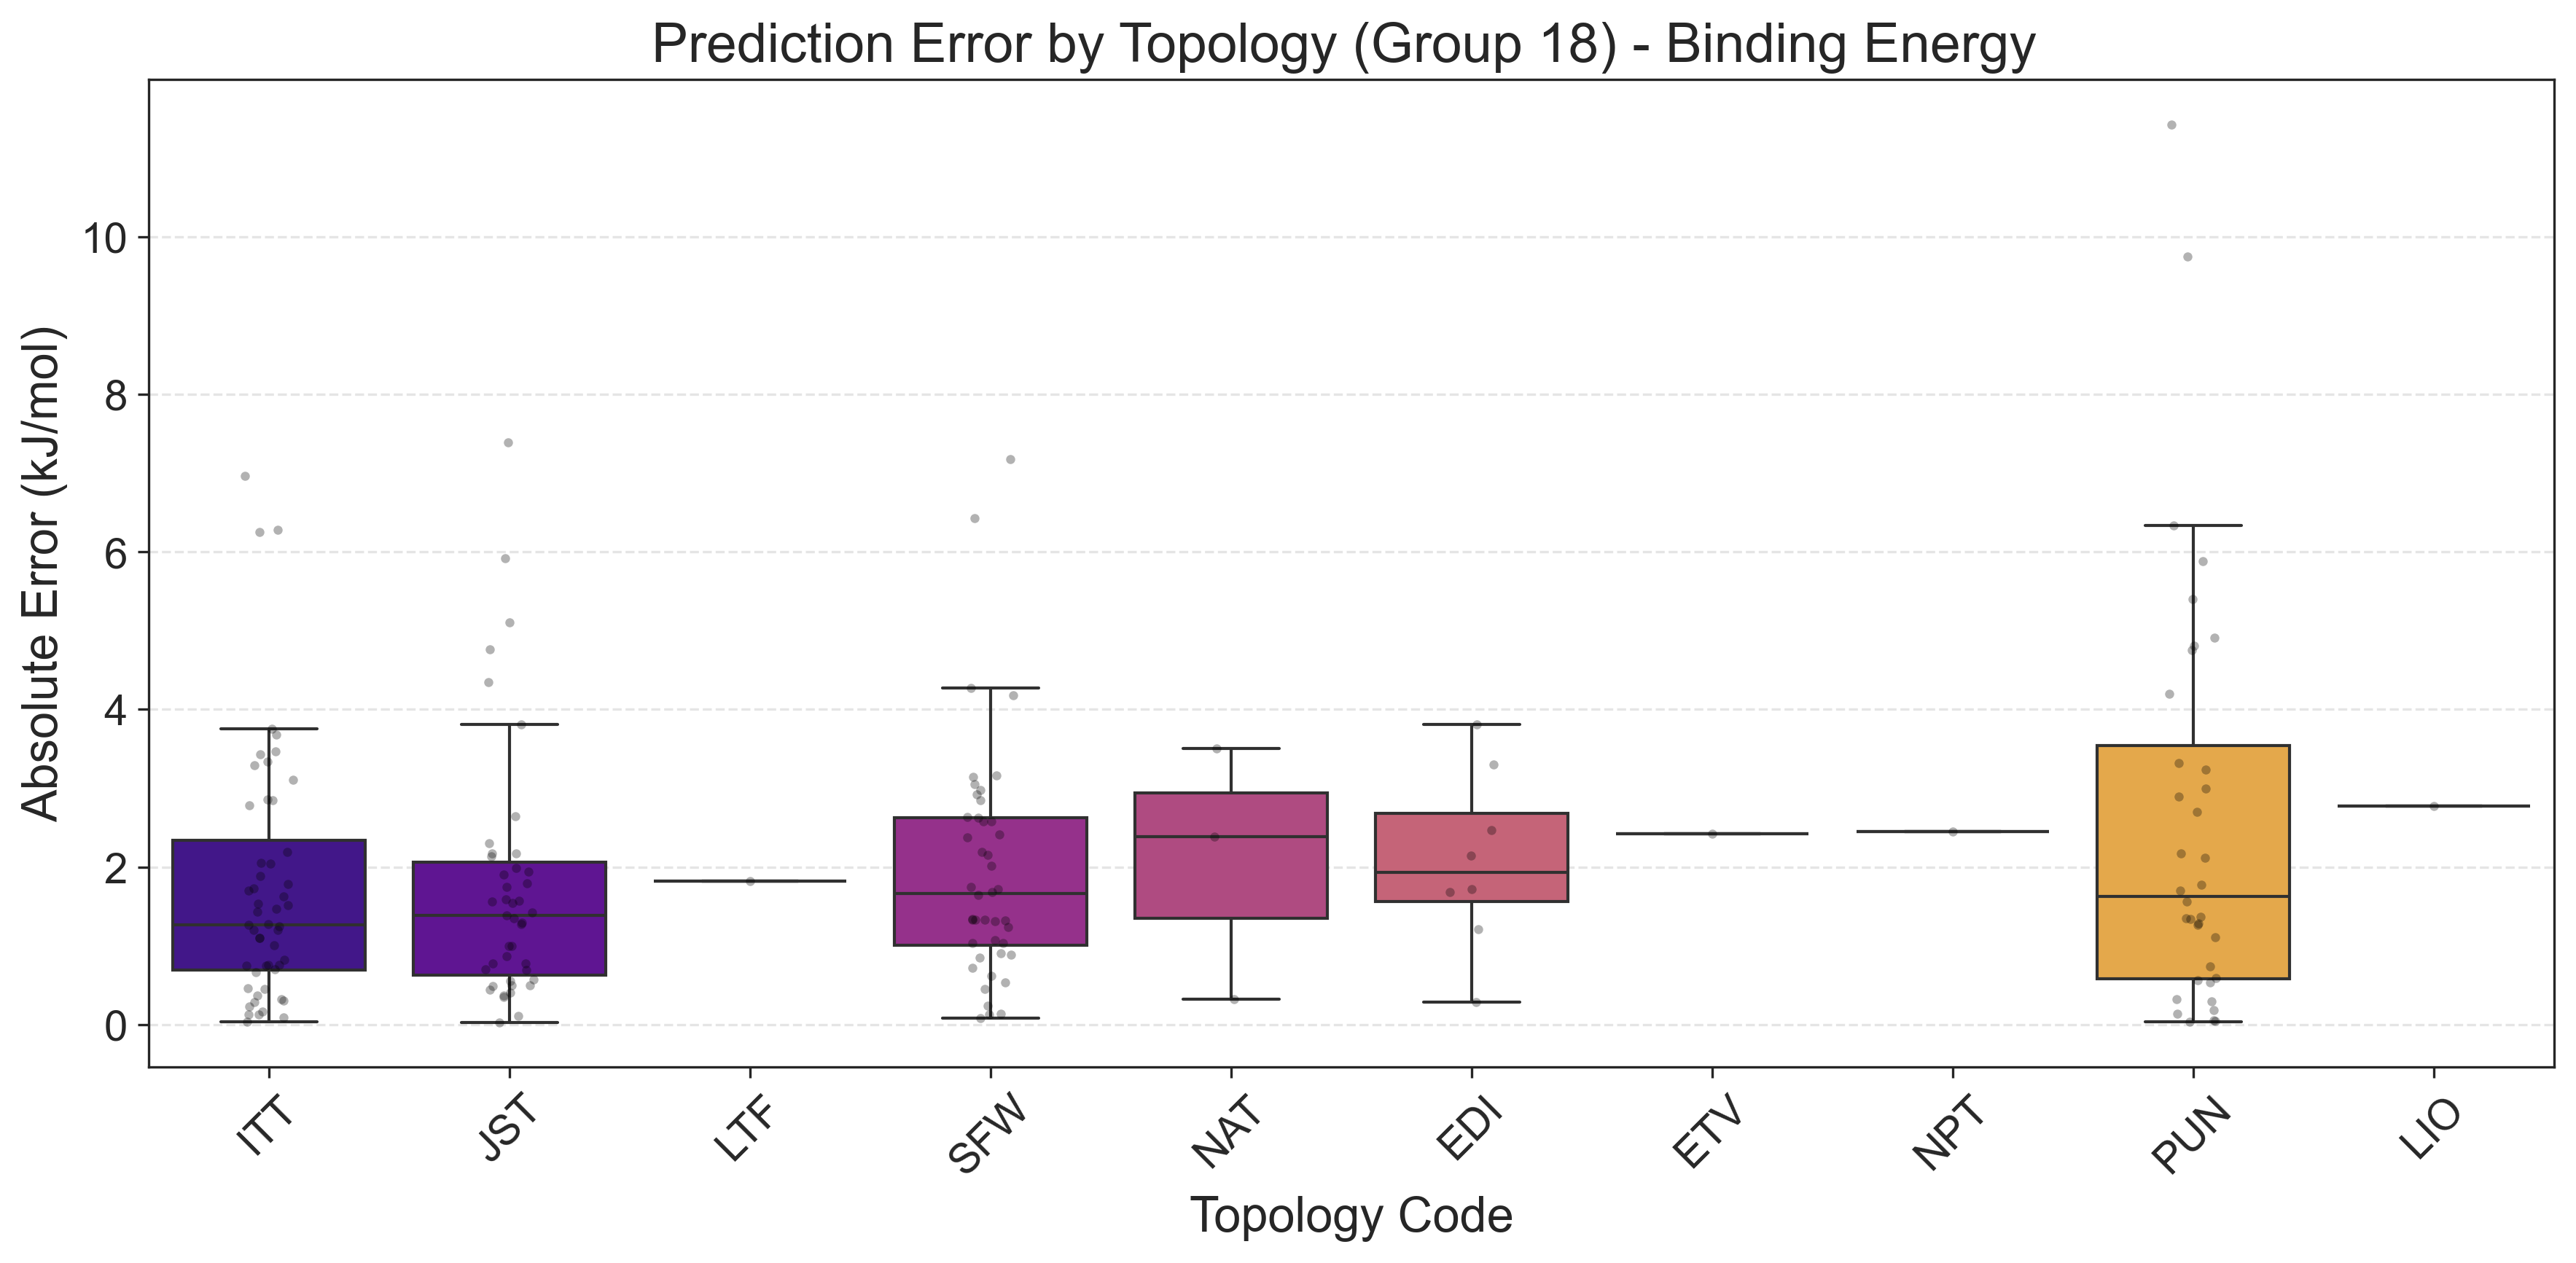


Binding Energy (kJ/mol Si) Range Performance:
Energy_Range
High (>75%)        1.161802
Low (<25%)         1.269735
Medium (25-75%)    0.924626
Name: Abs_Error_Binding Energy (kJ/mol Si), dtype: float32


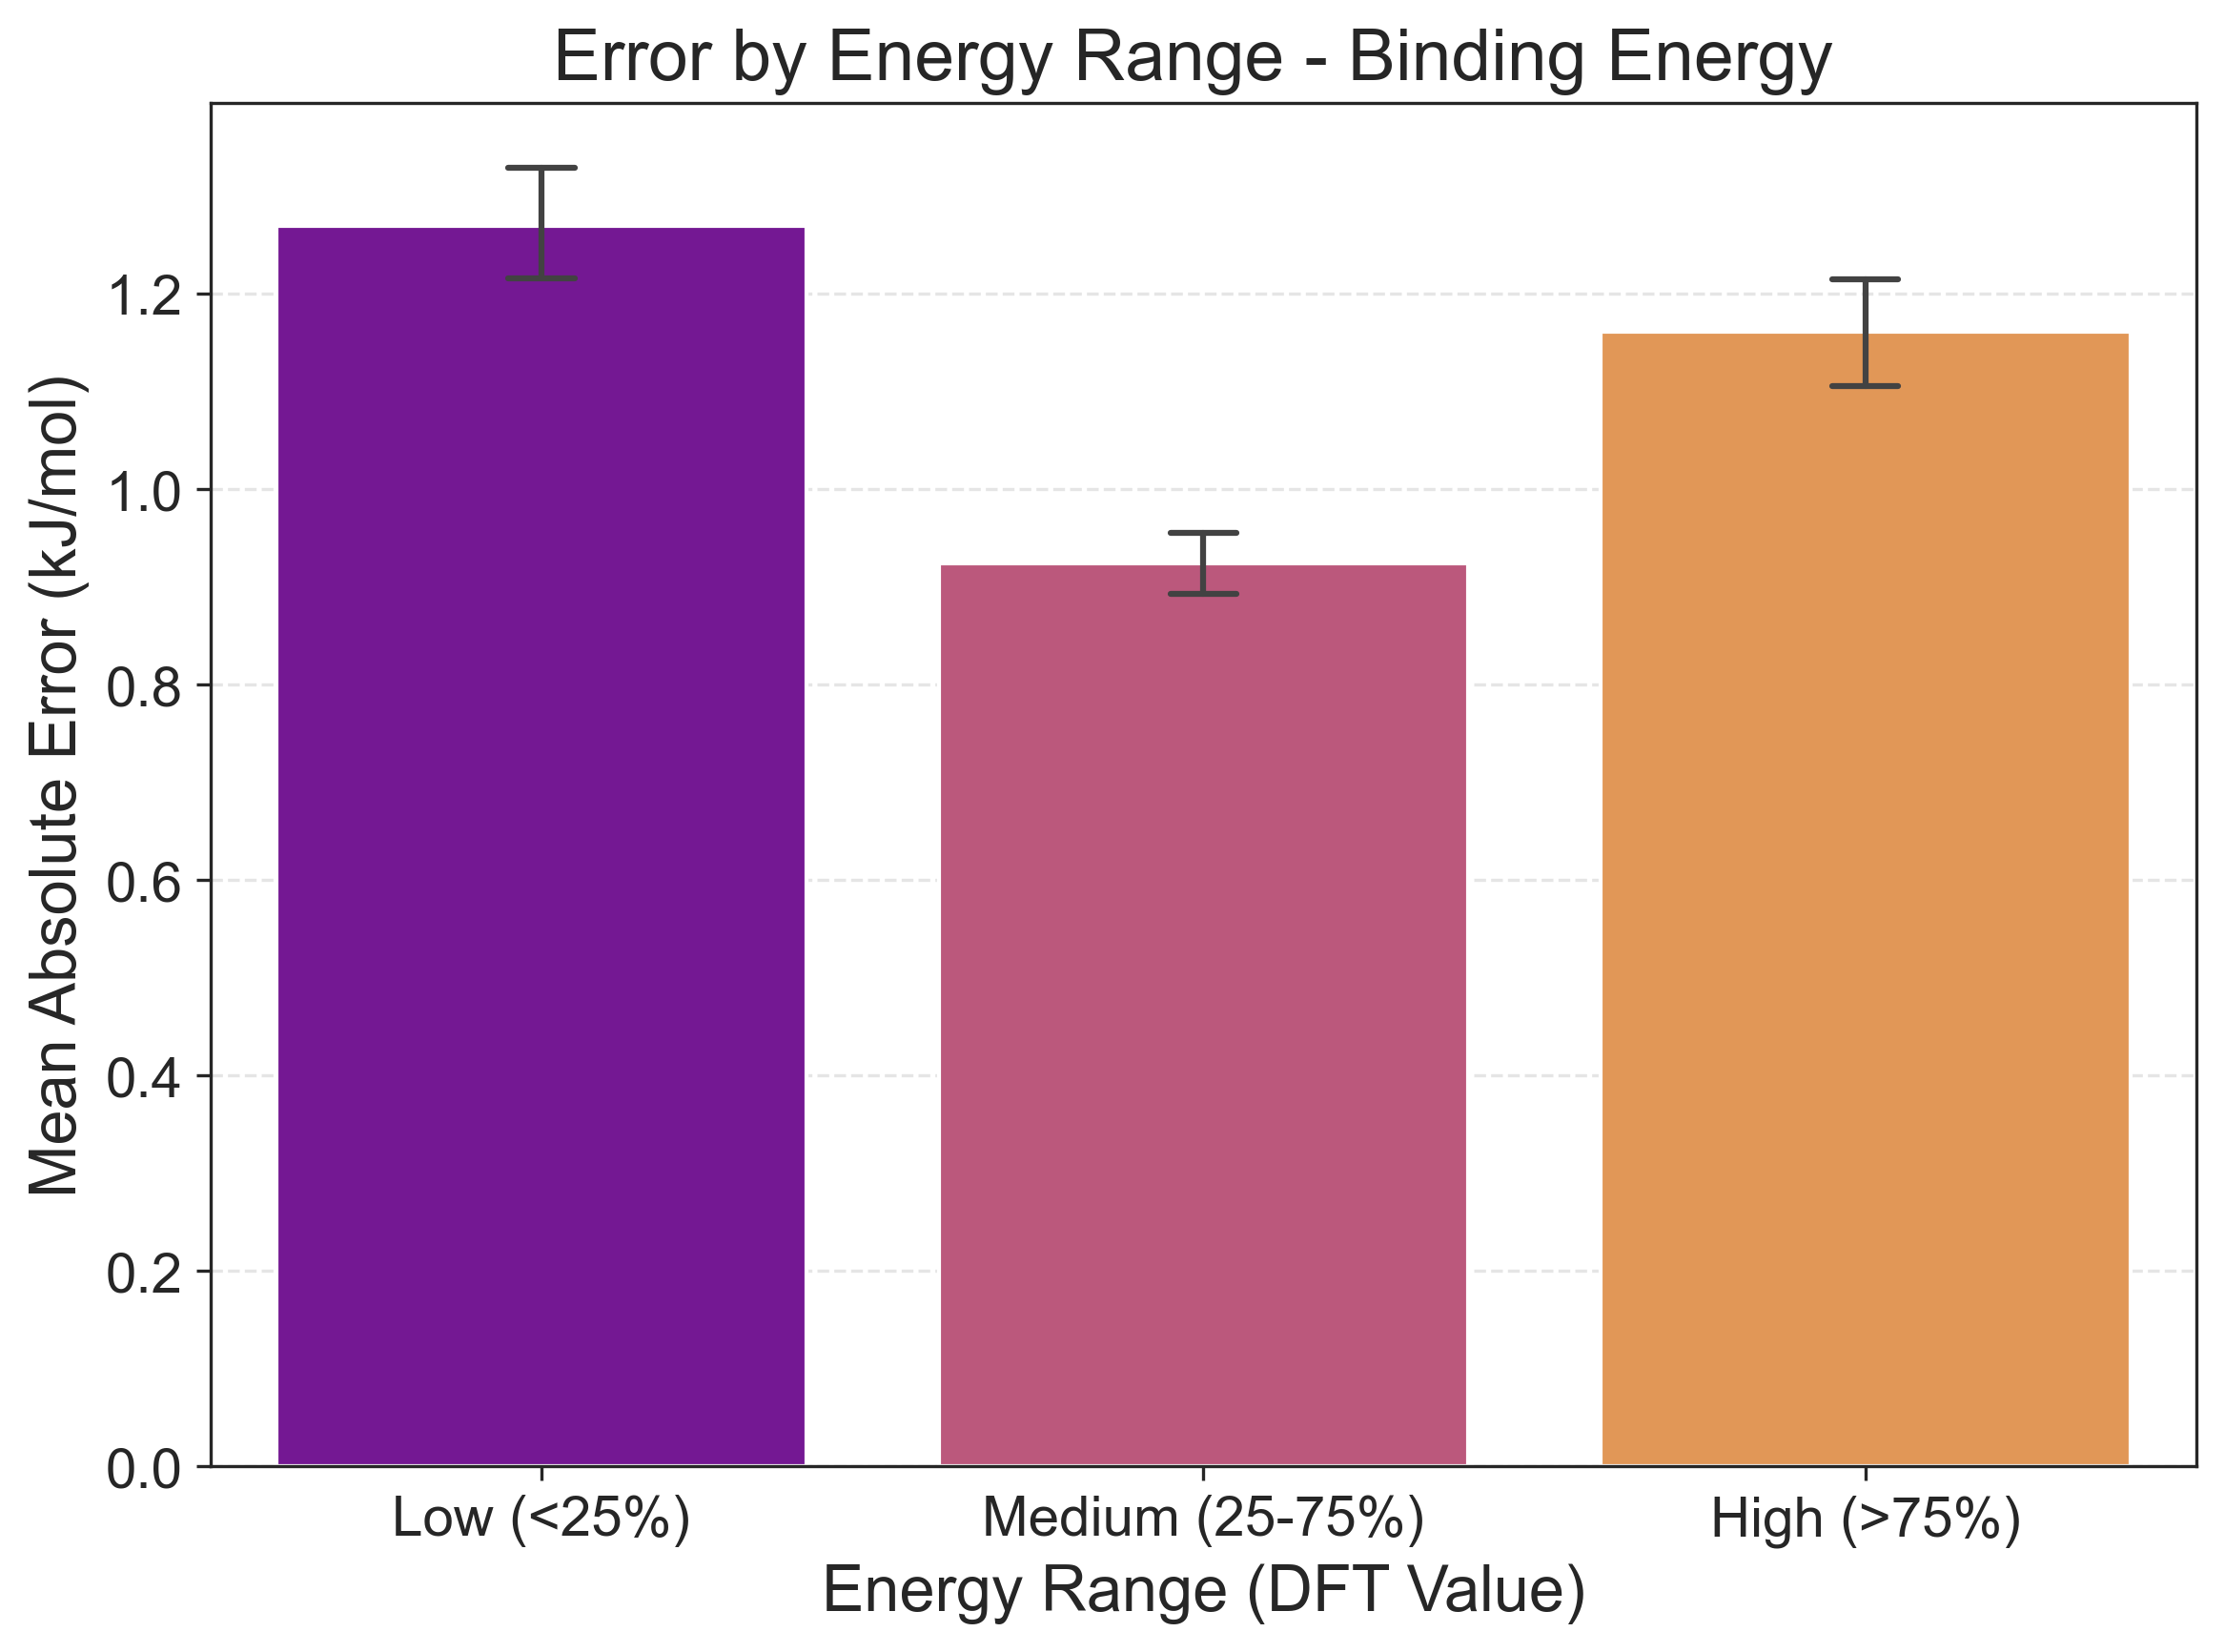


分析完成！所有图片已保存。


In [1]:
import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, Batch, Dataset
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings

# ==========================================
# 0. 全局绘图风格与保存路径设置
# ==========================================
warnings.filterwarnings('ignore')

# 图片保存路径
SAVE_DIR = r"C:\Users\admin\Energymodel\2-9"
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)
    print(f"创建保存目录: {SAVE_DIR}")

plt.rcParams.update({
    'font.size': 14,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans'],
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 20,
    'figure.dpi': 300,
    'savefig.dpi': 300,      # 保存分辨率
    'savefig.bbox': 'tight'  # 自动裁剪白边
})
sns.set_style("ticks")

# ==========================================
# 1. 配置参数
# ==========================================
class Config:
    BASE_PATH = r"C:\机器学习材料\季鏻"
    DATASET_PATH = os.path.join(BASE_PATH, "MEL数据集.xlsx")
    PROCESSED_CACHE_PATH = os.path.join(BASE_PATH, "cached_graphs_box64_cleaned.pt")
    MODEL_PATH = "zeolite_3d_gnn_enriched_cleaned.pth"
    
    TARGET_COLS = [
        'Binding Energy (kJ/mol Si)',
        'Directivity Energy (kJ/mol Si)',
        'Competition Energy (kJ/mol Si)',
        'Binding Energy (kJ/mol OSDA)',
        'Competition Energy (kJ/mol OSDA)'
    ]
    
    ATOM_EMBEDDING_DIM = 64
    HIDDEN_DIM = 128
    EMB_DIM_DEGREE = 8
    EMB_DIM_CHARGE = 8
    EMB_DIM_HYB = 8
    EMB_DIM_AROMATIC = 4
    EMB_DIM_CHIRAL = 4
    
    VOXEL_SIZE = 64
    VOXEL_RES = 0.5
    SIGMA = 0.5
    MIN_SAMPLES_PER_TOPO = 0

# ==========================================
# 2. 模型定义
# ==========================================
class Voxel3DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(2, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.pool1 = nn.MaxPool3d(2)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.pool2 = nn.MaxPool3d(2)
        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(64)
        self.pool3 = nn.MaxPool3d(2)
        self.fc = nn.Linear(64 * 8 * 8 * 8, 128)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        return x

class DualBranchGNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb_atom = nn.Embedding(120, Config.ATOM_EMBEDDING_DIM)
        self.emb_degree = nn.Embedding(12, Config.EMB_DIM_DEGREE)
        self.emb_charge = nn.Embedding(15, Config.EMB_DIM_CHARGE)
        self.emb_hyb = nn.Embedding(8, Config.EMB_DIM_HYB)
        self.emb_aromatic = nn.Embedding(2, Config.EMB_DIM_AROMATIC)
        self.emb_chiral = nn.Embedding(4, Config.EMB_DIM_CHIRAL)
        
        total_emb_dim = (Config.ATOM_EMBEDDING_DIM + Config.EMB_DIM_DEGREE + 
                         Config.EMB_DIM_CHARGE + Config.EMB_DIM_HYB + 
                         Config.EMB_DIM_AROMATIC + Config.EMB_DIM_CHIRAL)
        
        self.mol_conv1 = GCNConv(total_emb_dim + 1, Config.HIDDEN_DIM)
        self.mol_conv2 = GCNConv(Config.HIDDEN_DIM, Config.HIDDEN_DIM)
        self.zeo_conv1 = GCNConv(total_emb_dim, Config.HIDDEN_DIM)
        self.zeo_conv2 = GCNConv(Config.HIDDEN_DIM, Config.HIDDEN_DIM)
        self.voxel_cnn = Voxel3DCNN()
        
        self.global_feat_dim = 17
        self.global_encoder = nn.Sequential(
            nn.Linear(self.global_feat_dim, 64), nn.ReLU(),
            nn.Linear(64, Config.HIDDEN_DIM), nn.BatchNorm1d(Config.HIDDEN_DIM), nn.ReLU()
        )
        
        fusion_dim = Config.HIDDEN_DIM * 4
        self.head = nn.Sequential(
            nn.Linear(fusion_dim, 512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, len(Config.TARGET_COLS))
        )

    def _embed_features(self, x_idx):
        e1 = self.emb_atom(x_idx[:, 0])
        e2 = self.emb_degree(x_idx[:, 1])
        e3 = self.emb_charge(x_idx[:, 2])
        e4 = self.emb_hyb(x_idx[:, 3])
        e5 = self.emb_aromatic(x_idx[:, 4])
        e6 = self.emb_chiral(x_idx[:, 5])
        return torch.cat([e1, e2, e3, e4, e5, e6], dim=1)

    def forward(self, mol_batch, zeo_batch, voxel_batch):
        x_m, edge_index_m, batch_m = mol_batch.x, mol_batch.edge_index, mol_batch.batch
        x_m_emb = self._embed_features(x_m)
        x_m_in = torch.cat([x_m_emb, mol_batch.x_charge], dim=1)
        x_m_out = F.relu(self.mol_conv2(F.relu(self.mol_conv1(x_m_in, edge_index_m, edge_weight=mol_batch.edge_weight)), edge_index_m, edge_weight=mol_batch.edge_weight))
        feat_m = global_mean_pool(x_m_out, batch_m)
        
        x_z, edge_index_z, batch_z = zeo_batch.x, zeo_batch.edge_index, zeo_batch.batch
        x_z_out = F.relu(self.zeo_conv2(F.relu(self.zeo_conv1(self._embed_features(x_z), edge_index_z)), edge_index_z))
        feat_z = global_mean_pool(x_z_out, batch_z)
        
        feat_v = self.voxel_cnn(voxel_batch)
        
        global_attr = mol_batch.global_attr
        if global_attr.dim() == 3: global_attr = global_attr.squeeze(1)
        feat_global = self.global_encoder(global_attr)
        
        return self.head(torch.cat([feat_m, feat_z, feat_global, feat_v], dim=1))

# ==========================================
# 3. 数据集与辅助函数
# ==========================================
def coords_to_voxel(coords, grid_size=32, res=0.5, sigma=0.5):
    grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.float32)
    limit = (grid_size * res) / 2.0
    valid_coords = coords[(coords[:, 0] > -limit) & (coords[:, 0] < limit) & 
                          (coords[:, 1] > -limit) & (coords[:, 1] < limit) & 
                          (coords[:, 2] > -limit) & (coords[:, 2] < limit)]
    if len(valid_coords) == 0: return grid
    indices = ((valid_coords + limit) / res).astype(int)
    indices = np.clip(indices, 0, grid_size - 1)
    for idx in indices:
        x, y, z = idx
        grid[max(0, x-1):min(grid_size, x+2), max(0, y-1):min(grid_size, y+2), max(0, z-1):min(grid_size, z+2)] += 1.0
    return np.clip(grid, 0, 1.0)

class ZeoliteDataset(Dataset):
    def __init__(self, df, cache_data, target_scaler=None):
        super().__init__()
        self.df = df
        self.target_scaler = target_scaler
        self.mol_list = []
        self.zeo_list = []
        self.y_list = []
        self.valid_indices = []
        
        mol_cache = cache_data['mol_cache']
        zeo_cache = cache_data['zeo_cache']
        
        for idx, row in df.iterrows():
            cid = row['CID']
            topo = row['Topology Code']
            targets = row[Config.TARGET_COLS].values.astype(float)
            
            if cid in mol_cache and topo in zeo_cache and not np.isnan(targets).any():
                self.mol_list.append(mol_cache[cid])
                self.zeo_list.append(zeo_cache[topo])
                self.y_list.append(targets)
                self.valid_indices.append(idx)
        
        self.props_scaler = StandardScaler()
        if len(self.mol_list) > 0:
            all_props = torch.cat([m.global_attr for m in self.mol_list], dim=0).numpy()
            self.props_scaler.fit(all_props)

    def __len__(self):
        return len(self.mol_list)

    def __getitem__(self, idx):
        mol_data = self.mol_list[idx].clone()
        zeo_data = self.zeo_list[idx].clone()
        y_raw = self.y_list[idx]
        
        props_raw = mol_data.global_attr.numpy()
        mol_data.global_attr = torch.tensor(self.props_scaler.transform(props_raw), dtype=torch.float)
        y = self.target_scaler.transform(y_raw.reshape(1, -1)).flatten()
        
        mol_coords = mol_data.pos_variants[0].numpy() if hasattr(mol_data, 'pos_variants') else mol_data.pos.numpy()
        if hasattr(mol_data, 'pos_variants'): del mol_data.pos_variants
        
        zeo_coords = zeo_data.pos_super.numpy() if hasattr(zeo_data, 'pos_super') else zeo_data.pos.numpy()
        if hasattr(zeo_data, 'pos_super'): del zeo_data.pos_super
            
        grid_mol = coords_to_voxel(mol_coords, Config.VOXEL_SIZE, Config.VOXEL_RES, Config.SIGMA)
        grid_zeo = coords_to_voxel(zeo_coords, Config.VOXEL_SIZE, Config.VOXEL_RES, Config.SIGMA)
        voxel_tensor = torch.tensor(np.stack([grid_mol, grid_zeo], axis=0), dtype=torch.float)
        
        return mol_data, zeo_data, voxel_tensor, torch.tensor(y, dtype=torch.float)

    @staticmethod
    def gpu_collate(batch):
        return (Batch.from_data_list([i[0] for i in batch]),
                Batch.from_data_list([i[1] for i in batch]),
                torch.stack([i[2] for i in batch]),
                torch.stack([i[3] for i in batch]))

# ==========================================
# 4. 分析核心代码
# ==========================================
def analyze_model():
    print("--- 1. 加载数据与缓存 ---")
    df = pd.read_excel(Config.DATASET_PATH, engine='openpyxl')
    
    topo_counts = df['Topology Code'].value_counts()
    valid_topos = topo_counts[topo_counts >= Config.MIN_SAMPLES_PER_TOPO].index
    df_filtered = df[df['Topology Code'].isin(valid_topos)].reset_index(drop=True)
    
    print(f"Loading cache from {Config.PROCESSED_CACHE_PATH}")
    cache_data = torch.load(Config.PROCESSED_CACHE_PATH, weights_only=False)
    
    print("--- 2. 复现数据集划分 (Train/Test) ---")
    indices = list(range(len(df_filtered)))
    train_idx, temp_idx = train_test_split(indices, train_size=0.8, random_state=42)
    val_idx, test_idx = train_test_split(temp_idx, train_size=0.5, random_state=42)
    
    target_scaler = StandardScaler().fit(df_filtered.iloc[train_idx][Config.TARGET_COLS].values)
    
    test_df_raw = df_filtered.iloc[test_idx].reset_index(drop=True)
    test_dataset = ZeoliteDataset(test_df_raw, cache_data, target_scaler)
    
    print(f"Dataset 过滤情况: 原始 {len(test_df_raw)} -> 有效 {len(test_dataset)}")
    
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, 
                             collate_fn=ZeoliteDataset.gpu_collate, num_workers=0)
    
    print("--- 3. 加载模型 ---")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DualBranchGNN().to(device)
    state_dict = torch.load(Config.MODEL_PATH, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    
    print(f"--- 4. 在测试集上进行预测 ({len(test_dataset)} 样本) ---")
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for mol, zeo, voxel, y in tqdm(test_loader):
            mol, zeo, voxel = mol.to(device), zeo.to(device), voxel.to(device)
            pred = model(mol, zeo, voxel)
            all_preds.append(pred.cpu().numpy())
            all_targets.append(y.numpy())
            
    y_pred_norm = np.vstack(all_preds)
    y_true_norm = np.vstack(all_targets)
    y_pred_real = target_scaler.inverse_transform(y_pred_norm)
    y_true_real = target_scaler.inverse_transform(y_true_norm)
    
    results = test_df_raw.iloc[test_dataset.valid_indices].copy()
    
    mol_vols = []
    for cid in results['CID']:
        if cid in cache_data['mol_cache']:
            vol = cache_data['mol_cache'][cid].global_attr[0, 5].item()
            mol_vols.append(vol)
        else:
            mol_vols.append(np.nan)
    results['Mol_Volume'] = mol_vols

    for i, col in enumerate(Config.TARGET_COLS):
        results[f'Pred_{col}'] = y_pred_real[:, i]
        results[f'True_{col}'] = y_true_real[:, i]
        results[f'Abs_Error_{col}'] = np.abs(results[f'Pred_{col}'] - results[f'True_{col}'])
    
    return results

# ==========================================
# 5. 绘图与分析函数
# ==========================================
def plot_overall_parity(results, target_col):
    """绘制总体的奇偶校验图 (Parity Plot) - 配色：Plasma (紫开始)"""
    y_true = results[f'True_{target_col}']
    y_pred = results[f'Pred_{target_col}']
    
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    plt.figure(figsize=(8, 7))
    # 【修改】cmap='plasma' (紫色->黄色)
    hb = plt.hexbin(y_true, y_pred, gridsize=40, cmap='plasma', mincnt=1, edgecolors='none')
    cb = plt.colorbar(hb, label='Count')
    
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, alpha=0.7)
    
    plt.xlabel(f'DFT Calculated {target_col}')
    plt.ylabel(f'ML Predicted {target_col}')
    plt.title(f'Overall Performance: {target_col.split("(")[0]}')
    
    textstr = f'$R^2 = {r2:.3f}$\n$MAE = {mae:.3f}$ kJ/mol'
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=16,
             verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    # 【修改】保存图片
    save_name = f"Overall_Parity_{target_col.split('(')[0].strip().replace(' ', '_')}.png"
    plt.savefig(os.path.join(SAVE_DIR, save_name))
    plt.show()

def plot_topology_analysis(results, target_col):
    """按拓扑结构分组分析 MAE - 配色：Plasma"""
    topo_mae = results.groupby('Topology Code')[f'Abs_Error_{target_col}'].mean().sort_values()
    chunk_size = 10
    topos = topo_mae.index.tolist()
    chunks = [topos[i:i + chunk_size] for i in range(0, len(topos), chunk_size)]
    
    print(f"--- Topology Analysis for {target_col} ---")
    
    for i, chunk in enumerate(chunks):
        plt.figure(figsize=(12, 6))
        subset = results[results['Topology Code'].isin(chunk)]
        order = chunk 
        
        # 【修改】palette='plasma'
        sns.boxplot(x='Topology Code', y=f'Abs_Error_{target_col}', data=subset, 
                    order=order, palette="plasma", showfliers=False)
        sns.stripplot(x='Topology Code', y=f'Abs_Error_{target_col}', data=subset, 
                      order=order, color='black', alpha=0.3, size=3)
        
        plt.title(f'Prediction Error by Topology (Group {i+1}) - {target_col.split("(")[0]}')
        plt.ylabel('Absolute Error (kJ/mol)')
        plt.xlabel('Topology Code')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        
        # 【修改】保存图片
        save_name = f"Topology_Analysis_Group_{i+1}_{target_col.split('(')[0].strip().replace(' ', '_')}.png"
        plt.savefig(os.path.join(SAVE_DIR, save_name))
        plt.show()

def plot_energy_range_analysis(results, target_col):
    """能量区间误差分析 - 配色：Plasma"""
    y_true = results[f'True_{target_col}']
    low_thresh = y_true.quantile(0.25)
    high_thresh = y_true.quantile(0.75)
    
    def get_range(val):
        if val < low_thresh: return 'Low (<25%)'
        elif val > high_thresh: return 'High (>75%)'
        else: return 'Medium (25-75%)'
        
    results['Energy_Range'] = results[f'True_{target_col}'].apply(get_range)
    
    plt.figure(figsize=(8, 6))
    order = ['Low (<25%)', 'Medium (25-75%)', 'High (>75%)']
    
    # 【修改】palette='plasma'
    sns.barplot(x='Energy_Range', y=f'Abs_Error_{target_col}', data=results, 
                order=order, palette='plasma', capsize=0.1, errwidth=1.5)
    
    plt.title(f'Error by Energy Range - {target_col.split("(")[0]}')
    plt.ylabel('Mean Absolute Error (kJ/mol)')
    plt.xlabel('Energy Range (DFT Value)')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    range_perf = results.groupby('Energy_Range')[f'Abs_Error_{target_col}'].mean()
    print(f"\n{target_col} Range Performance:\n{range_perf}")
    
    plt.tight_layout()
    # 【修改】保存图片
    save_name = f"Energy_Range_{target_col.split('(')[0].strip().replace(' ', '_')}.png"
    plt.savefig(os.path.join(SAVE_DIR, save_name))
    plt.show()

# 【已删除 plot_molecule_size_analysis 函数】

# ==========================================
# 6. 主执行逻辑
# ==========================================
if __name__ == "__main__":
    results_df = analyze_model()
    
    print("\n" + "="*50)
    print("开始绘图分析")
    print(f"图片将保存至: {SAVE_DIR}")
    print("="*50)
    
    # 分析主要目标 (默认为 Binding Energy Si)
    primary_target = Config.TARGET_COLS[0]  
    
    print(f"\n正在分析目标: {primary_target}")
    
    # 1. 总体奇偶校验图
    plot_overall_parity(results_df, primary_target)
    
    # 2. 拓扑结构详细分析
    plot_topology_analysis(results_df, primary_target)
    
    # 3. 能量区间分析
    plot_energy_range_analysis(results_df, primary_target)
    
    # 【已删除分子大小分析调用】
    
    print("\n分析完成！所有图片已保存。")